In [2]:
# load model

import pickle
import os
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten, TimeDistributed
from tensorflow.keras.layers import Dropout, Bidirectional, LSTM, Attention, Multiply, Reshape, Permute, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

T = 200
tau = 3



with open('Data/Feature/k_data (200, {})'.format(tau), 'rb') as f:
    k_data = pickle.load(f)
    
with open('Data/Feature/alpha_data (200, {})'.format(tau), 'rb') as f:
    alpha_data = pickle.load(f)
    
with open('Data/Feature/length_data (200, {})'.format(tau), 'rb') as f:
    length_data = pickle.load(f)
    
with open('Data/Feature/cp_data (200, {})'.format(tau), 'rb') as f:
    cp_data = pickle.load(f)
    
with open("Data/Feature/Trajectories ({})".format(T),"rb") as f:
    trajectories = pickle.load(f)
    
model_k_path = 'Models/' + 'trajectories_model_k_(12.05) (T = {}, ks = {}, 3_cnn, causal).hdf5'.format(
    T, 3)


model_alpha_path = 'Models/' + 'trajectories_model_alpha_(12/05) (T = {}, ks = {}, 3_cnn, causal).hdf5'.format(
        T, 8)


model_k = keras.models.load_model(model_k_path)
model_alpha = keras.models.load_model(model_alpha_path)

In [4]:
input_data = trajectories
train_input = np.zeros((300000,T,2))
val_input = np.zeros((60000,T,2))
test_input = np.zeros((60000,T,2))

train_output = np.zeros((300000,T))
val_output = np.zeros((60000,T))
test_output = np.zeros((60000,T))

cases = ['single', 'multi', 'immobile', 'dimerization','confinement']


for case_num, case in enumerate(cases):
    ns_t = int(case_num*60000)
    ne_t = int((case_num+1)*60000)

    ns_v = int(case_num*12000)
    ne_v = int((case_num+1)*12000)

    train_input[ns_t:ne_t,:,0] = input_data['x'][case][0]
    train_input[ns_t:ne_t,:,1] = input_data['y'][case][0]
    val_input[ns_v:ne_v,:,0] = input_data['x'][case][1]
    val_input[ns_v:ne_v,:,1] = input_data['y'][case][1]
    test_input[ns_v:ne_v,:,0] = input_data['x'][case][2]
    test_input[ns_v:ne_v,:,1] = input_data['y'][case][2]
    
    train_output[ns_t:ne_t] = alpha_data[case][0]
    val_output[ns_v:ne_v] = alpha_data[case][1]
    test_output[ns_v:ne_v] = alpha_data[case][2]
        
        




    
print('train_input shape = {}'.format(train_input.shape))
print('train_output shape = {}'.format(train_output.shape))
print('val_input shape = {}'.format(val_input.shape))
print('val_output shape = {}'.format(val_output.shape))
print('test_input shape = {}'.format(test_input.shape))
print('test_output shape = {}'.format(test_output.shape))

train_input shape = (300000, 200, 2)
train_output shape = (300000, 200)
val_input shape = (60000, 200, 2)
val_output shape = (60000, 200)
test_input shape = (60000, 200, 2)
test_output shape = (60000, 200)


In [5]:
cases = ['single', 'multi', 'immobile', 'dimerization','confinement']


input_data = {}


true_alpha = {}
true_k = {}
for case_num, case in enumerate(cases):

    ns_v = int(case_num*12000)
    ne_v = int((case_num+1)*12000)
    
   
    input_data[case] = test_input[ns_v:ne_v]
    true_alpha[case] = alpha_data[case][2]
    true_k[case] = k_data[case][2]

In [6]:
pred_test = {}

pred_test_alpha = {}
pred_test_k = {}


for case in cases:
    print('{} starting..'.format(case))
    pred_test_alpha[case] = model_alpha.predict(input_data[case])
    pred_test_k[case] = model_k.predict(input_data[case]) 

pred_test = {}
pred_test['alpha'] = pred_test_alpha
pred_test['k'] = pred_test_k

single starting..
multi starting..
immobile starting..
dimerization starting..
confinement starting..


In [7]:
for case in cases:
    print(pred_test['k'][case].shape)
    print(pred_test['alpha'][case].shape)

(12000, 200)
(12000, 200)
(12000, 200)
(12000, 200)
(12000, 200)
(12000, 200)
(12000, 200)
(12000, 200)
(12000, 200)
(12000, 200)


In [8]:


for case in cases:
    print(k_data[case][2].shape)
    print(alpha_data[case][2].shape)

(12000, 200)
(12000, 200)
(12000, 200)
(12000, 200)
(12000, 200)
(12000, 200)
(12000, 200)
(12000, 200)
(12000, 200)
(12000, 200)


In [9]:
n = 20
T = length_data[case][2][n]
cp = cp_data[case][2][n]
print(T,cp)

200 [11, 109, 144, 200]


In [693]:
# test_loss
import tensorflow.keras as keras



loss_test = {}

loss_test_alpha = {}

loss_test_k = {}



for case in cases:
    
    loss_test_alpha[case] = np.mean(keras.losses.mean_absolute_error(alpha_data[case][2], pred_test['alpha'][case]))
    loss_test_k[case] = np.mean(keras.losses.mean_absolute_error(k_data[case][2],pred_test['k'][case]))

loss_test['alpha'] = loss_test_alpha
loss_test['k'] = loss_test_k


print('---------------------------')
print('---------------------------')
print('---------------------------')
for case in cases:
    print('{} alpha_loss = {}'.format(('test', case), loss_test['alpha'][case]))
    print('{} k_loss = {}'.format(('test', case), loss_test['k'][case]))
    print('---------------------------')

---------------------------
---------------------------
---------------------------
('test', 'single') alpha_loss = 0.028668537735939026
('test', 'single') k_loss = 0.09979495406150818
---------------------------
('test', 'multi') alpha_loss = 0.071770079433918
('test', 'multi') k_loss = 0.17114855349063873
---------------------------
('test', 'immobile') alpha_loss = 0.03692192956805229
('test', 'immobile') k_loss = 0.12443428486585617
---------------------------
('test', 'dimerization') alpha_loss = 0.08036895841360092
('test', 'dimerization') k_loss = 0.21840111911296844
---------------------------
('test', 'confinement') alpha_loss = 0.053463585674762726
('test', 'confinement') k_loss = 0.1422278881072998
---------------------------


In [694]:
loss_alpha = 0
loss_k = 0
for case in cases:
    loss_alpha += loss_test['alpha'][case]
    loss_k += loss_test['k'][case]
    
print(loss_alpha/5)
print(loss_k/5)

0.05423861816525459
0.15120135992765427


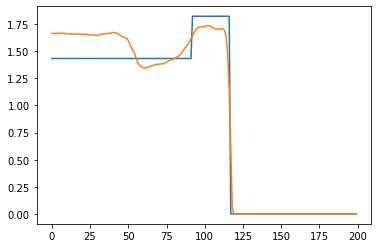

In [695]:
n = 8000

plt.plot(alpha_data['multi'][2][n])
plt.plot(pred_test['alpha']['multi'][n])

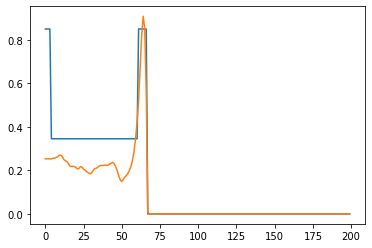

In [696]:
n = 200

plt.plot(k_data['multi'][2][n])
plt.plot(pred_test['k']['multi'][n])

In [697]:
with open('Data/Feature/length_data (200, {})'.format(3), 'rb') as f:
    length_data = pickle.load(f)
    
with open('Data/Feature/cp_data (200, {})'.format(3), 'rb') as f:
    cp_data = pickle.load(f)

In [698]:
index = {}

for case in cases:
    if case == 'single':
        index_case = []
        for n in range(len(length_data[case][2])):
            length = np.max(length_data[case][2][n])
            cp = cp_data[case][2][n]
            alpha = (alpha_data[case][2][n])
            k = (k_data[case][2][n])
            cp.insert(0,0)
            min_persistent_time = np.min(np.abs(np.diff(cp)))

    

            if length == 200 and min_persistent_time > 20 and np.max(alpha) > 1.0 and np.max(k) > 1.5:
                index_case.append(n)

 
    
    else:
        index_case = []
        for n in range(len(length_data[case][2])):
            length = np.max(length_data[case][2][n])
            cp = cp_data[case][2][n]
            alpha = (alpha_data[case][2][n])
            k = (k_data[case][2][n])
            cp.insert(0,0)
            min_persistent_time = np.min(np.abs(np.diff(cp)))
            del_alpha = np.max(alpha) - np.min(alpha)
            del_k = np.max(k) - np.min(k)
            if len(cp) == 4 and length == 200 and min_persistent_time > 20 and np.max(alpha) > 1.0 and np.max(k) > 1.5 and del_alpha > 0.3 and del_k > 0.3:
                index_case.append(n)
    
    index[case] = index_case
            
            


In [699]:
for case in cases:
    print(len(index[case]))

165
147
112
180
104


In [700]:
# 오차가 특정 값 이하인 데이터 인덱스 찾기/

good_performance_indexs = {}
for case in cases:
    index_case = []
    for n in index[case]:
        T = length_data[case][2][n]
        loss_alpha = np.mean(np.abs(alpha_data[case][2][n][:T] - pred_test['alpha'][case][n][:T]))
        loss_k = np.mean(np.abs(k_data[case][2][n][:T] - pred_test['k'][case][n][:T]))
        
        if loss_alpha < 0.1 and loss_k < 0.1:
            index_case.append(n)
            
    good_performance_indexs[case] = (index_case)
    
for case in cases:
    print('{} fraction = {}'.format(case, (len(good_performance_indexs[case])/12000)))

single fraction = 0.007583333333333333
multi fraction = 0.003916666666666666
immobile fraction = 0.006416666666666667
dimerization fraction = 0.0028333333333333335
confinement fraction = 0.00175


In [701]:
good_performance_indexs

{'single': [6001,
  6017,
  6022,
  6051,
  6072,
  6085,
  6121,
  6126,
  6142,
  6147,
  6152,
  6167,
  6182,
  6209,
  6223,
  6233,
  6264,
  6285,
  6307,
  6312,
  6363,
  6364,
  6377,
  6390,
  6401,
  6418,
  6445,
  6463,
  6481,
  6494,
  6513,
  6536,
  6545,
  6560,
  6571,
  6594,
  6599,
  6611,
  6629,
  6633,
  6645,
  6648,
  6696,
  6715,
  6719,
  6743,
  6786,
  6800,
  6808,
  6845,
  6859,
  6904,
  6935,
  6983,
  6999,
  7096,
  7143,
  7165,
  7186,
  7232,
  7319,
  7323,
  7328,
  7355,
  7367,
  7441,
  7514,
  7561,
  7635,
  7655,
  7706,
  7737,
  7759,
  7764,
  7827,
  7861,
  7907,
  7996,
  8016,
  8116,
  8132,
  8422,
  8439,
  8567,
  8572,
  8870,
  8994,
  9207,
  9641,
  10026,
  11624],
 'multi': [76,
  126,
  166,
  245,
  276,
  371,
  661,
  856,
  866,
  1300,
  1397,
  1682,
  1850,
  1862,
  1933,
  2819,
  2871,
  3107,
  3180,
  3633,
  3804,
  5058,
  5244,
  5549,
  5616,
  5674,
  5728,
  6248,
  6290,
  7066,
  7531,
  7555,
  75

In [702]:
# case = 'multi'
# 각 특성의 오차 최솟값 인덱스

loss_alphas = {}
loss_ks = {}
for case in cases:
    loss_alpha = []
    loss_k = []
    for n in good_performance_indexs[case]:
        T = length_data[case][2][n]
        loss_alpha.append(np.mean(np.abs(alpha_data[case][2][n][:T] - pred_test['alpha'][case][n][:T])))
        loss_k.append(np.mean(np.abs(k_data[case][2][n][:T] - pred_test['k'][case][n][:T])))
    print('{}, minimum indexs = {}, {}'.format(case,np.argmin(loss_alpha),np.argmin(loss_k)))
    print('{}, loss_alpha = {}, loss_k = {}'.format(case,np.min(loss_alpha),np.min(loss_k)))
    
    print('minimum_alpha: {}, loss_alpha = {}, loss_k = {}'.format(case,loss_alpha[np.argmin(loss_alpha)]
                                                                   ,loss_k[np.argmin(loss_alpha)]))
    
    print('minimum_k: {}, loss_alpha = {}, loss_k = {}'.format(case,loss_alpha[np.argmin(loss_k)]
                                                                   ,loss_k[np.argmin(loss_k)]))
    
    loss_ks[case] = loss_k
    loss_alphas[case] = loss_alpha

single, minimum indexs = 6, 47
single, loss_alpha = 0.004694055809267756, loss_k = 0.012210875401466072
minimum_alpha: single, loss_alpha = 0.004694055809267756, loss_k = 0.035653142652179726
minimum_k: single, loss_alpha = 0.010326613791771794, loss_k = 0.012210875401466072
multi, minimum indexs = 36, 36
multi, loss_alpha = 0.008892060812228365, loss_k = 0.029790764176516535
minimum_alpha: multi, loss_alpha = 0.008892060812228365, loss_k = 0.029790764176516535
minimum_k: multi, loss_alpha = 0.008892060812228365, loss_k = 0.029790764176516535
immobile, minimum indexs = 51, 16
immobile, loss_alpha = 0.010358232312397965, loss_k = 0.020394106407330588
minimum_alpha: immobile, loss_alpha = 0.010358232312397965, loss_k = 0.03125639948763457
minimum_k: immobile, loss_alpha = 0.02378078589105683, loss_k = 0.020394106407330588
dimerization, minimum indexs = 26, 20
dimerization, loss_alpha = 0.02833200239770071, loss_k = 0.05117781544270009
minimum_alpha: dimerization, loss_alpha = 0.028332002

In [703]:
pred_test['alpha']['single'].shape

(12000, 200)

0 0
k loss = 0.09004925816573689
alpha loss = 0.044809837701337916


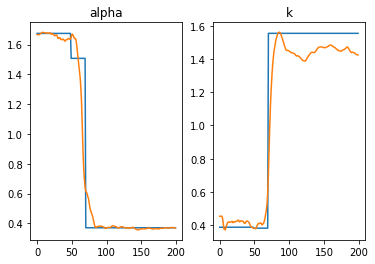

1 1
k loss = 0.05463569443778178
alpha loss = 0.07833704443447323


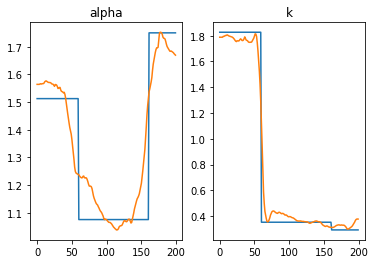

2 2
k loss = 0.08432611959662846
alpha loss = 0.08174608902744872


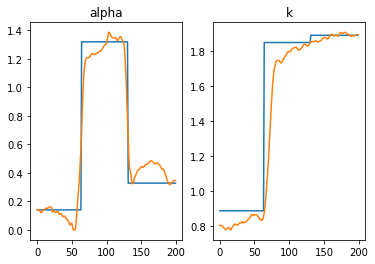

3 4
k loss = 0.07435181227248024
alpha loss = 0.043745380053017174


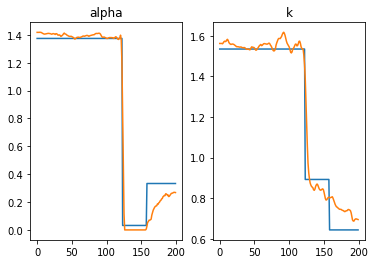

4 5
k loss = 0.04925744161733263
alpha loss = 0.054574558013133


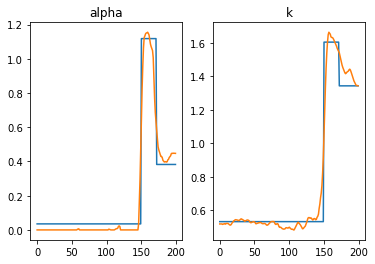

5 6
k loss = 0.04023151160992658
alpha loss = 0.05211124336490634


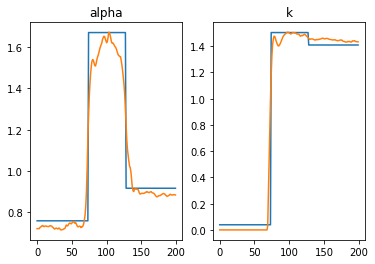

6 10
k loss = 0.04928809470876715
alpha loss = 0.05899605151251055


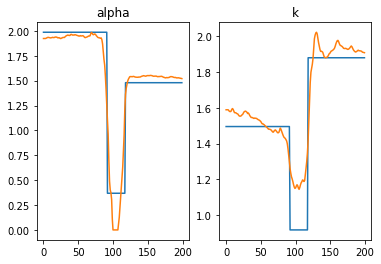

7 11
k loss = 0.04521519640193979
alpha loss = 0.021712911529598092


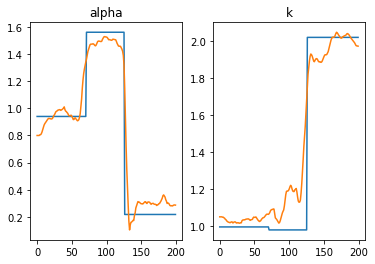

8 14
k loss = 0.03740682968145667
alpha loss = 0.029003357040126476


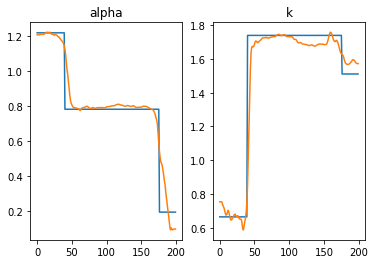

9 20
k loss = 0.0421721126852354
alpha loss = 0.02523011054587154


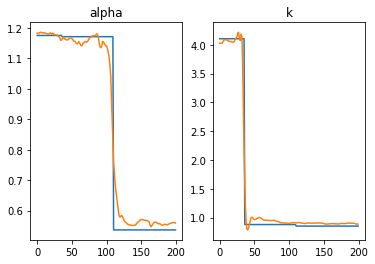

10 23
k loss = 0.08696281135051087
alpha loss = 0.09644312697025356


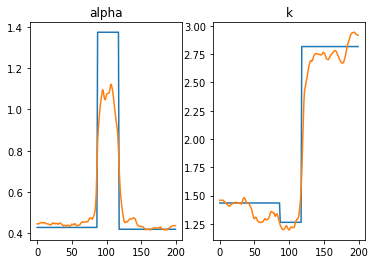

11 25
k loss = 0.0896868034538696
alpha loss = 0.08802570746142441


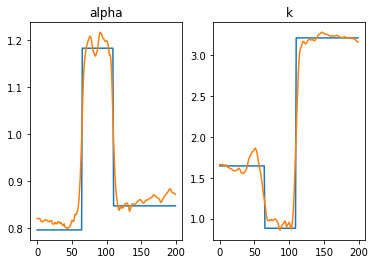

12 30
k loss = 0.07952411317148533
alpha loss = 0.020930438135777038


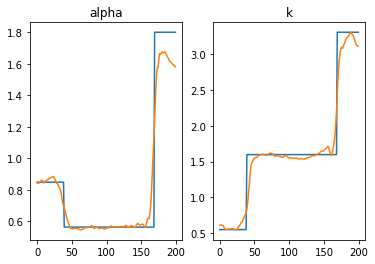

13 35
k loss = 0.03299347159010878
alpha loss = 0.029754337119300516


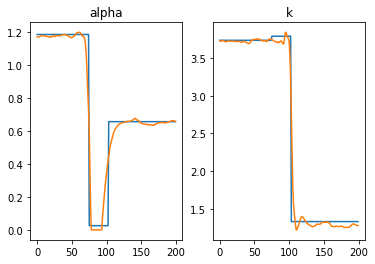

14 37
k loss = 0.05065951706156307
alpha loss = 0.040253428416893486


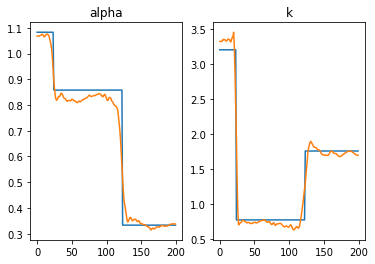

15 38
k loss = 0.09194894440781912
alpha loss = 0.06633885065641658


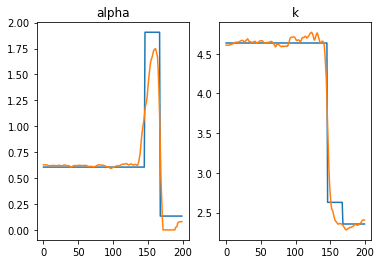

16 39
k loss = 0.09290636241463882
alpha loss = 0.08518967242949367


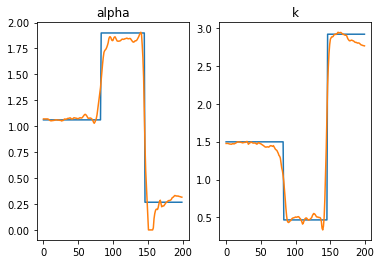

17 40
k loss = 0.09875485679019289
alpha loss = 0.07726969023078734


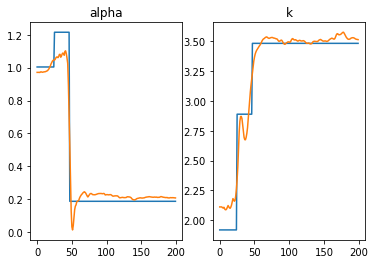

18 41
k loss = 0.0985660989319995
alpha loss = 0.07154584304462087


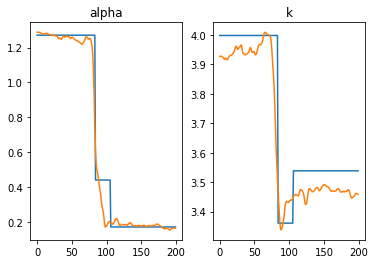

19 42
k loss = 0.08759300915713325
alpha loss = 0.07005194018510097


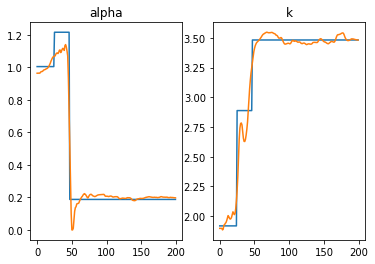

20 43
k loss = 0.0751784596789807
alpha loss = 0.02742783989524711


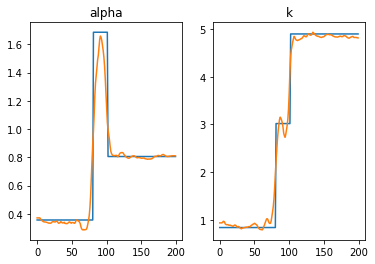

alpha best index = 12
k best index = 13


In [704]:
#  37로 결정! (multi, M = 3)
# 
#   47로 결정!('single')

case = 'multi'
i = 0
k_loss = []
alpha_loss = []
M = 3

for tn, n in enumerate(good_performance_indexs[case]):
    if np.unique(alpha_data[case][2][n][:length_data[case][2][n]]).shape[0] == M:
        plt.subplot(121)
        plt.title('alpha')
        plt.plot(alpha_data[case][2][n], label = 'Ground truth')
        plt.plot(pred_test['alpha'][case][n], label = 'Predict')

        plt.subplot(122)
        plt.title('k')
        plt.plot(k_data[case][2][n], label = 'Ground truth')
        plt.plot(pred_test['k'][case][n], label = 'Predict')



        print(i,tn)
        print('k loss = {}'.format(loss_ks[case][i]))
        print('alpha loss = {}'.format(loss_alphas[case][i]))
        
        k_loss.append(loss_ks[case][i])
        alpha_loss.append(loss_alphas[case][i])
        i += 1
        plt.show()
   
   
print('alpha best index = {}'.format(np.argmin(alpha_loss)))
print('k best index = {}'.format(np.argmin(k_loss)))

In [705]:
n_single = 47
n_multi = 37


# indexs_best = {'single':23,'multi':n_multi,'immobile':48,'dimerization':4,'confinement':3 }

# indexs_best = {'single':n_single,'multi':n_multi}
indexs_best = {'single':n_single,'multi':n_multi}
for case in cases:
    print(indexs_best[case])

47
37


KeyError: 'immobile'

In [706]:
with open('Data/Feature/length_data (200, {})'.format(3), 'rb') as f:
    length_data = pickle.load(f)
    
with open('Data/Feature/cp_data (200, {})'.format(3), 'rb') as f:
    cp_data = pickle.load(f)

In [707]:
cases

['single', 'multi', 'immobile', 'dimerization', 'confinement']

In [708]:
case = 'single'

n = indexs_best[case]
x = trajectories['x'][case][2][good_performance_indexs[case][n]]
print(x[-1]*0.1)

4.246660537243068


In [709]:
good_performance_indexs[case][n]

6800

[0, 200]


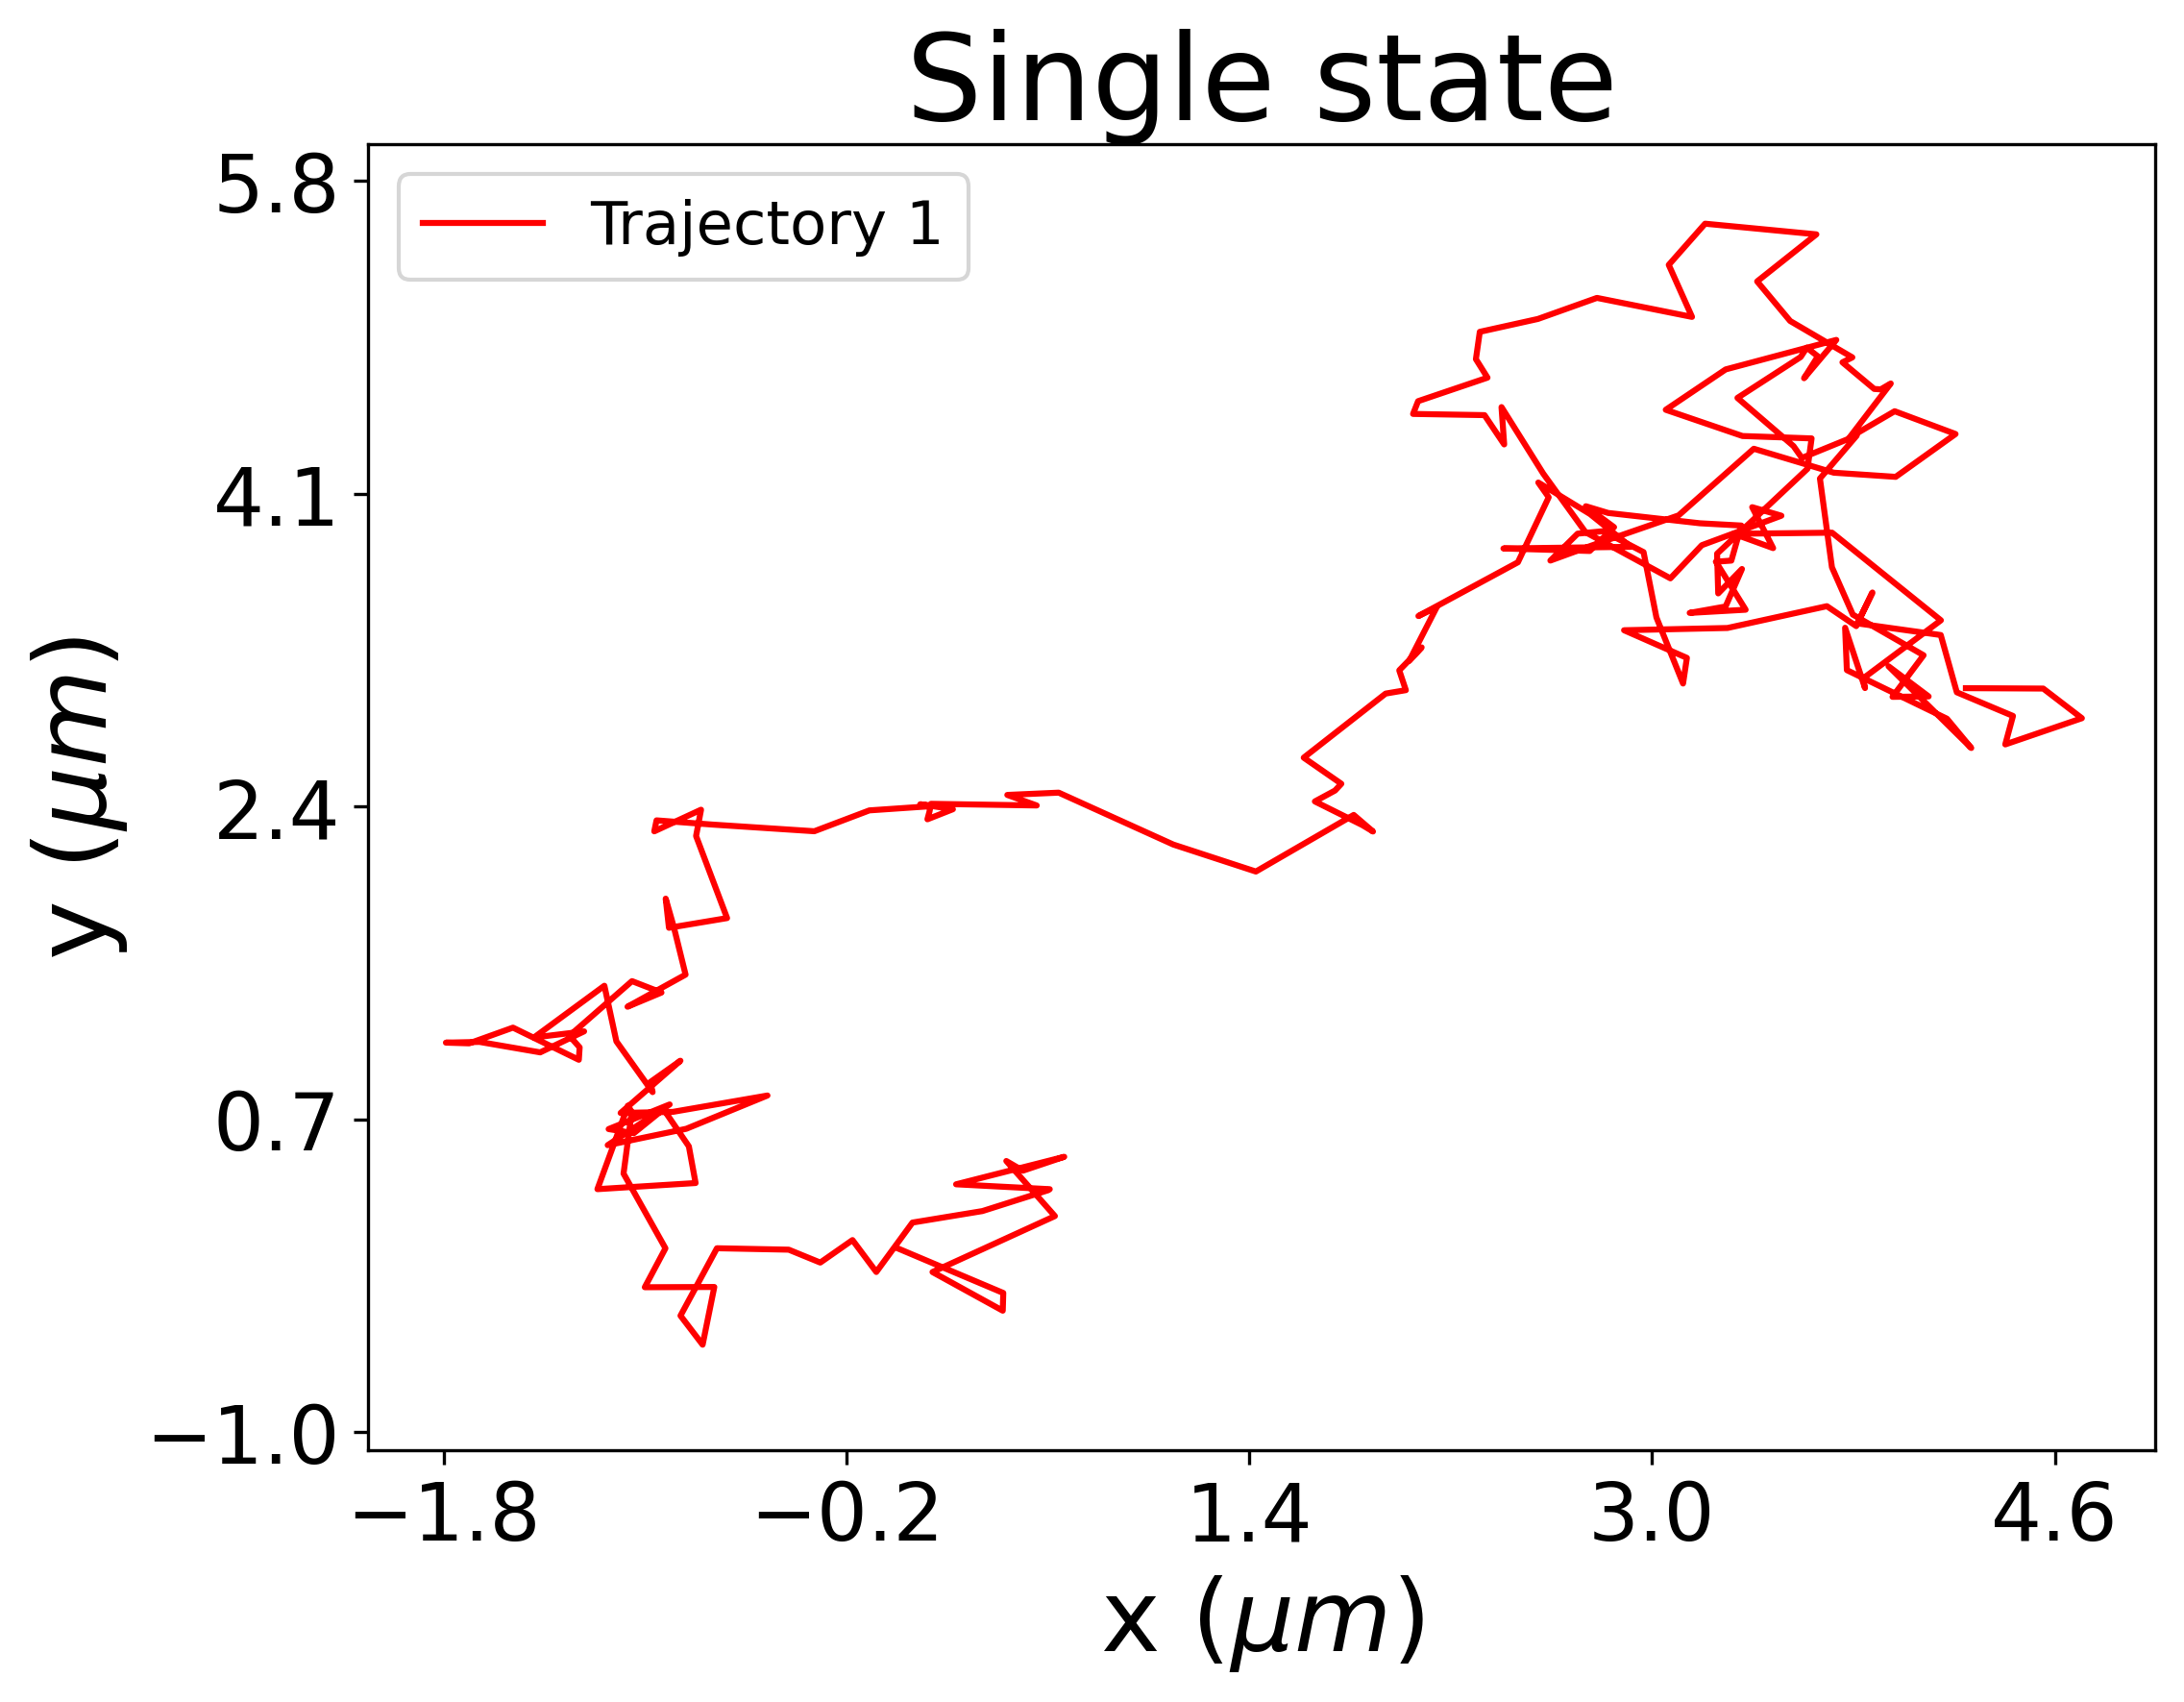

[0, 24, 123, 200]


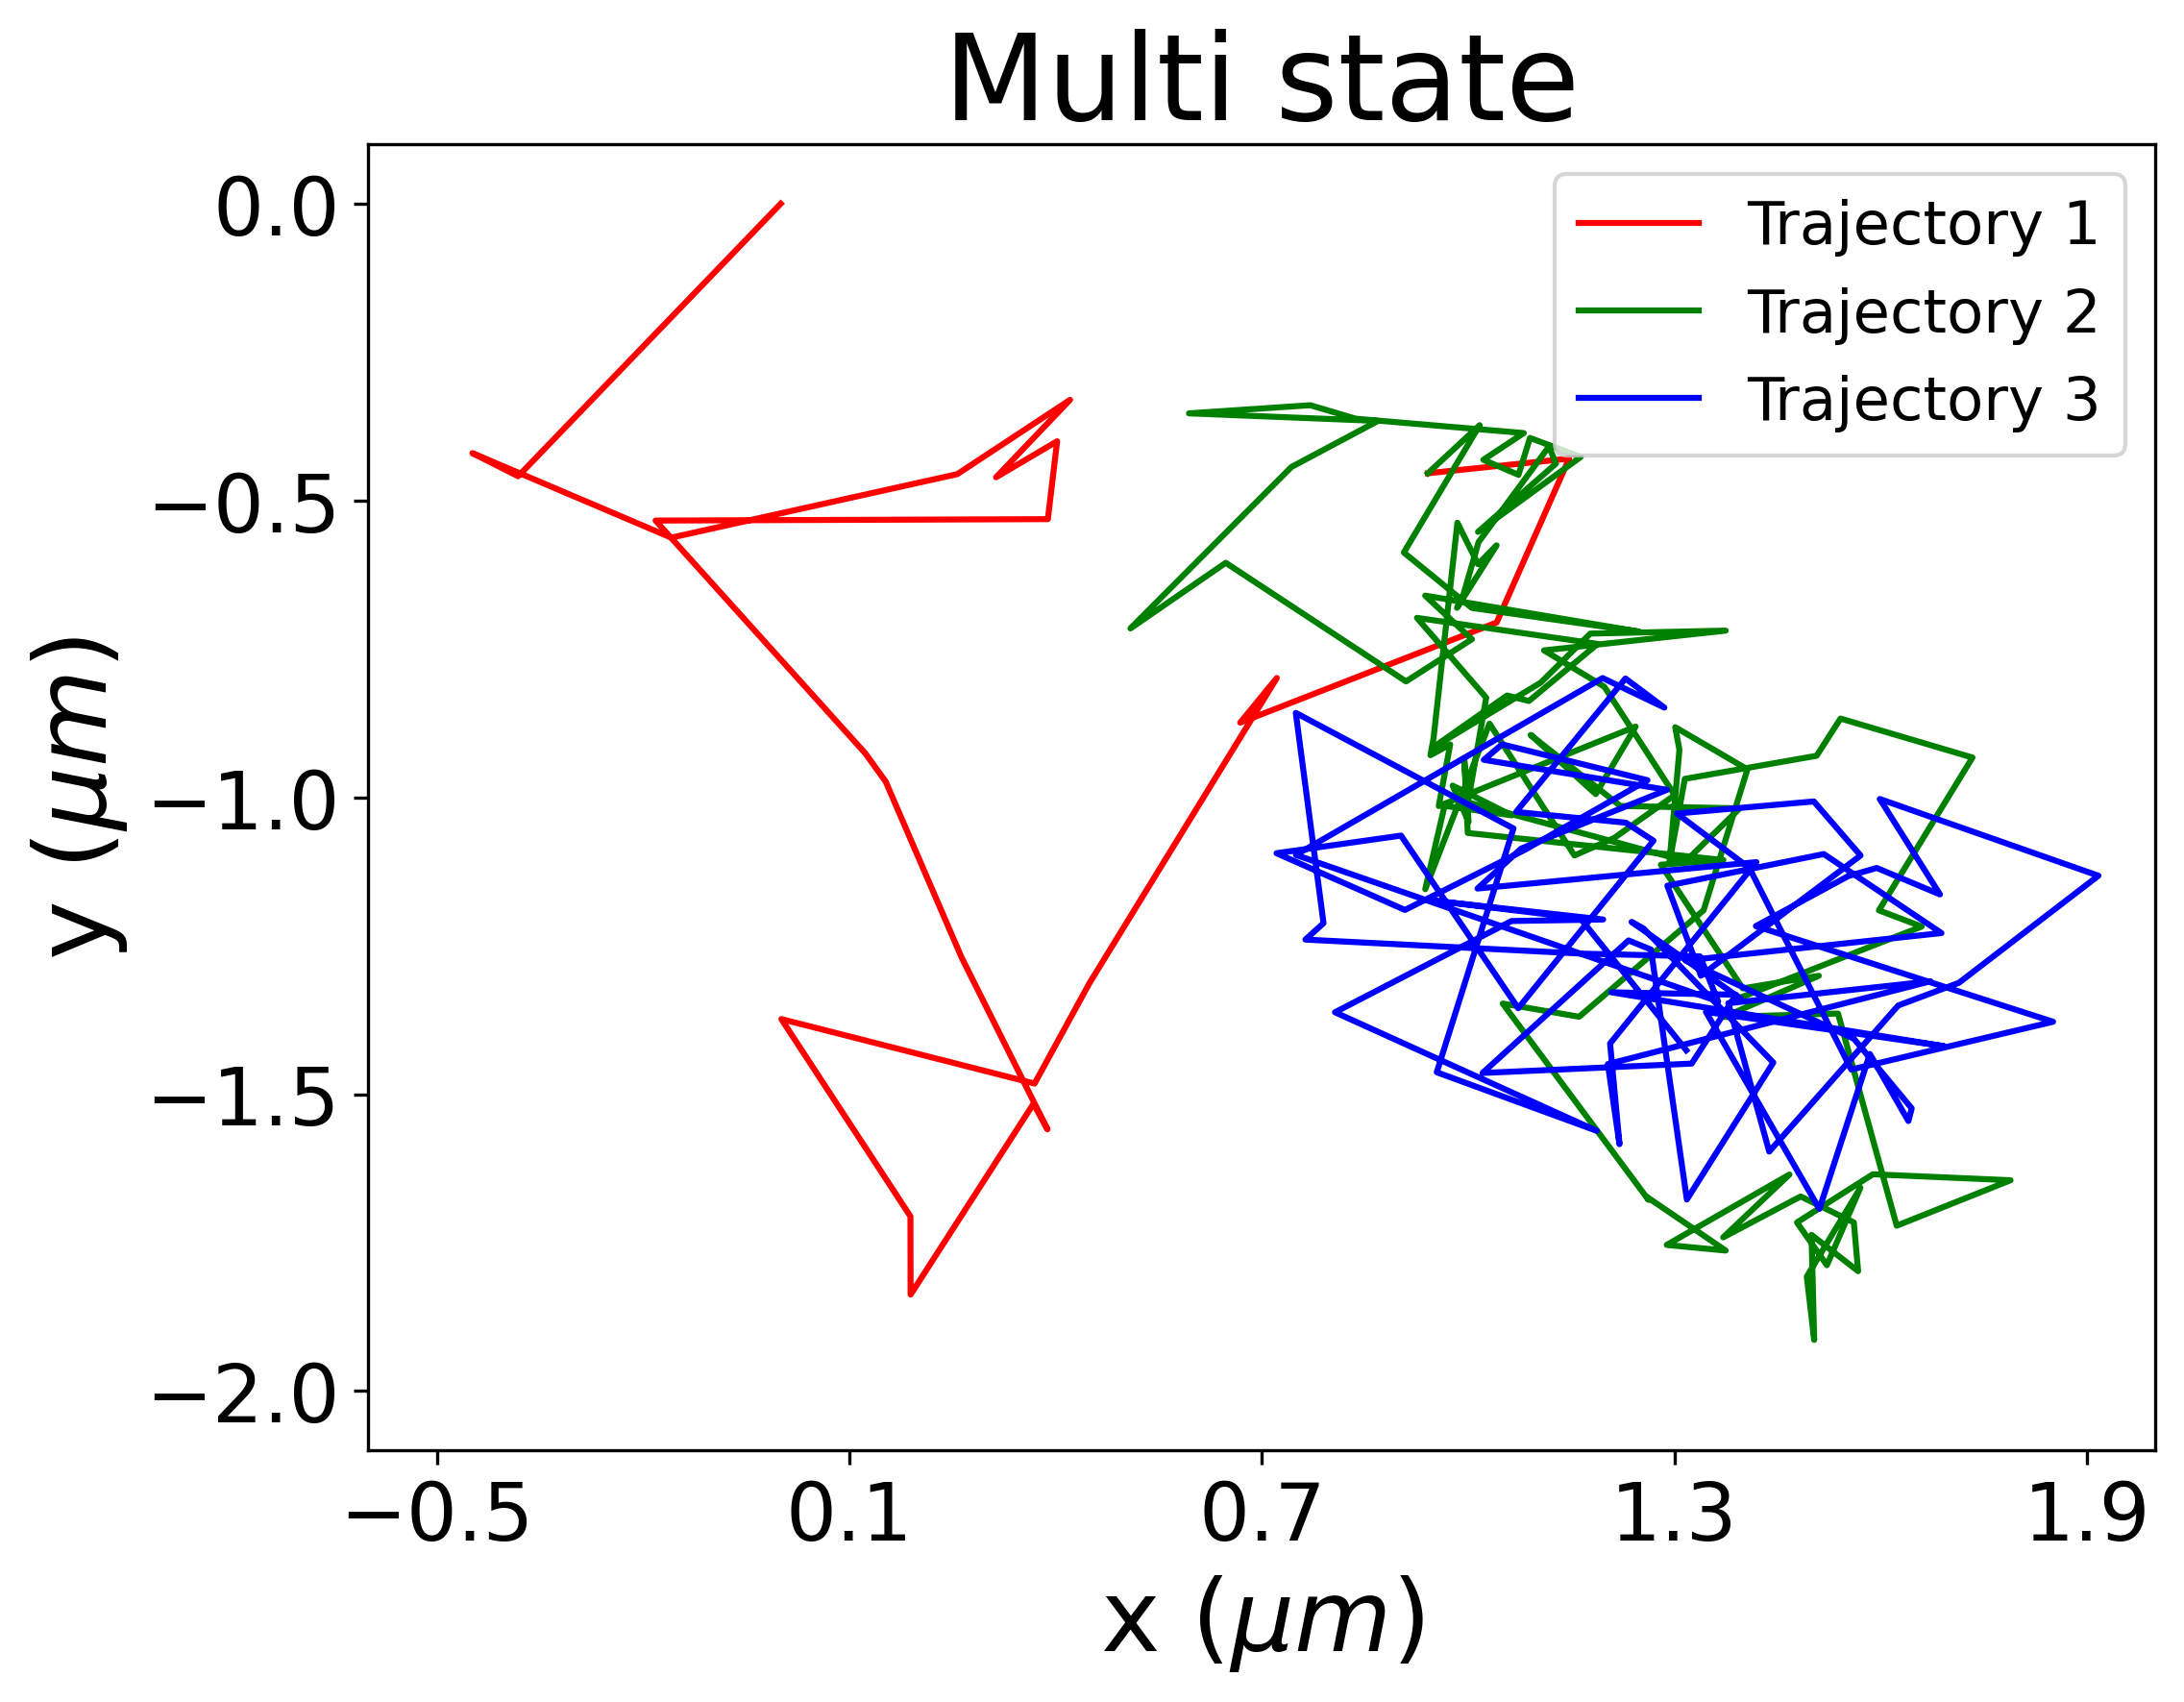

In [710]:
# Fig 1. Representative examples of trajectories with various diffusion features.

# 가장 예측을 잘한 Trajectories

T = 200




for case in cases[:2]:

    n = indexs_best[case]
    plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)
    
    length = length_data[case][2][good_performance_indexs[case][n]]
    x = trajectories['x'][case][2][good_performance_indexs[case][n]]
    y = trajectories['y'][case][2][good_performance_indexs[case][n]]
#     alpha = alpha_data[case][2][good_performance_indexs[case][n]]
#     k = k_data[case][2][good_performance_indexs[case][n]]
    cp_n = cp_data[case][2][good_performance_indexs[case][n]]
    
    cp = [0]
    for cp_value in cp_n:
        cp.append(cp_value)
   
    print(cp)
    
    c_zip = ['r', 'g', 'b']
    colors = {}
    for c_num in range(len(cp)-1):
        colors[c_num] = c_zip[c_num]
    
    
    if case == 'multi':

        case = case.capitalize()
        plt.title('{}'.format(case + ' ' + 'state'), fontsize =30)
        for i,cp_num in enumerate(range(len(cp)-1)):

    
            plt.plot(x[cp[i]:cp[i+1]+1]*0.1, y[cp[i]:cp[i+1]+1]*0.1,color = colors[cp_num], label = 'Trajectory {}'.format(i+1))
               
      
#                 plt.plot(x[cp[i]:cp[i+1]]*0.1, y[cp[i]:cp[i+1]]*0.1,color = colors[cp_num],label = 'Trajectory {}'.format(i+1))
              
                
            plt.xlabel('x' + ' ' +r'($\mu m$)', fontsize = 25)
            plt.ylabel('y' + ' ' +r'($\mu m$)', fontsize = 25)
            
            plt.xticks([-0.5,0.1,0.7,1.3,1.9], fontsize = 20)
            
            plt.xlim([-0.6,2.0])
            
            plt.yticks([-2.0,-1.5,-1.0,-0.5,0],fontsize = 20)
            
            plt.ylim([-2.1,0.1])
        plt.legend(fontsize = 15)
        plt.show()
    else:
        case = case.capitalize()
        plt.title('{}'.format(case + ' ' + 'state'), fontsize =30)
        plt.plot(x[cp[0]:cp[1]+1]*0.1, y[cp[0]:cp[1]+1]*0.1,color = colors[0], label = 'Trajectory 1')
        plt.xlabel('x' + ' ' +r'($\mu m$)', fontsize = 25)
        plt.ylabel('y' + ' ' +r'($\mu m$)', fontsize = 25)
        plt.xticks([-1.8,-0.2,1.4,3.0,4.6],fontsize = 20)
        plt.xlim([-2.1,5.0])
        plt.yticks([-1.0,0.7,2.4,4.1,5.8],fontsize = 20)
        plt.ylim([-1.1,6.0])
   
        plt.legend(fontsize = 15)
        plt.show()


    



        






In [711]:
alpha_data['single'][2][good_performance_indexs['single'][indexs_best['single']]]

array([1.04843454, 1.04843454, 1.04843454, 1.04843454, 1.04843454,
       1.04843454, 1.04843454, 1.04843454, 1.04843454, 1.04843454,
       1.04843454, 1.04843454, 1.04843454, 1.04843454, 1.04843454,
       1.04843454, 1.04843454, 1.04843454, 1.04843454, 1.04843454,
       1.04843454, 1.04843454, 1.04843454, 1.04843454, 1.04843454,
       1.04843454, 1.04843454, 1.04843454, 1.04843454, 1.04843454,
       1.04843454, 1.04843454, 1.04843454, 1.04843454, 1.04843454,
       1.04843454, 1.04843454, 1.04843454, 1.04843454, 1.04843454,
       1.04843454, 1.04843454, 1.04843454, 1.04843454, 1.04843454,
       1.04843454, 1.04843454, 1.04843454, 1.04843454, 1.04843454,
       1.04843454, 1.04843454, 1.04843454, 1.04843454, 1.04843454,
       1.04843454, 1.04843454, 1.04843454, 1.04843454, 1.04843454,
       1.04843454, 1.04843454, 1.04843454, 1.04843454, 1.04843454,
       1.04843454, 1.04843454, 1.04843454, 1.04843454, 1.04843454,
       1.04843454, 1.04843454, 1.04843454, 1.04843454, 1.04843

In [712]:
indexs_best

{'single': 47, 'multi': 37}

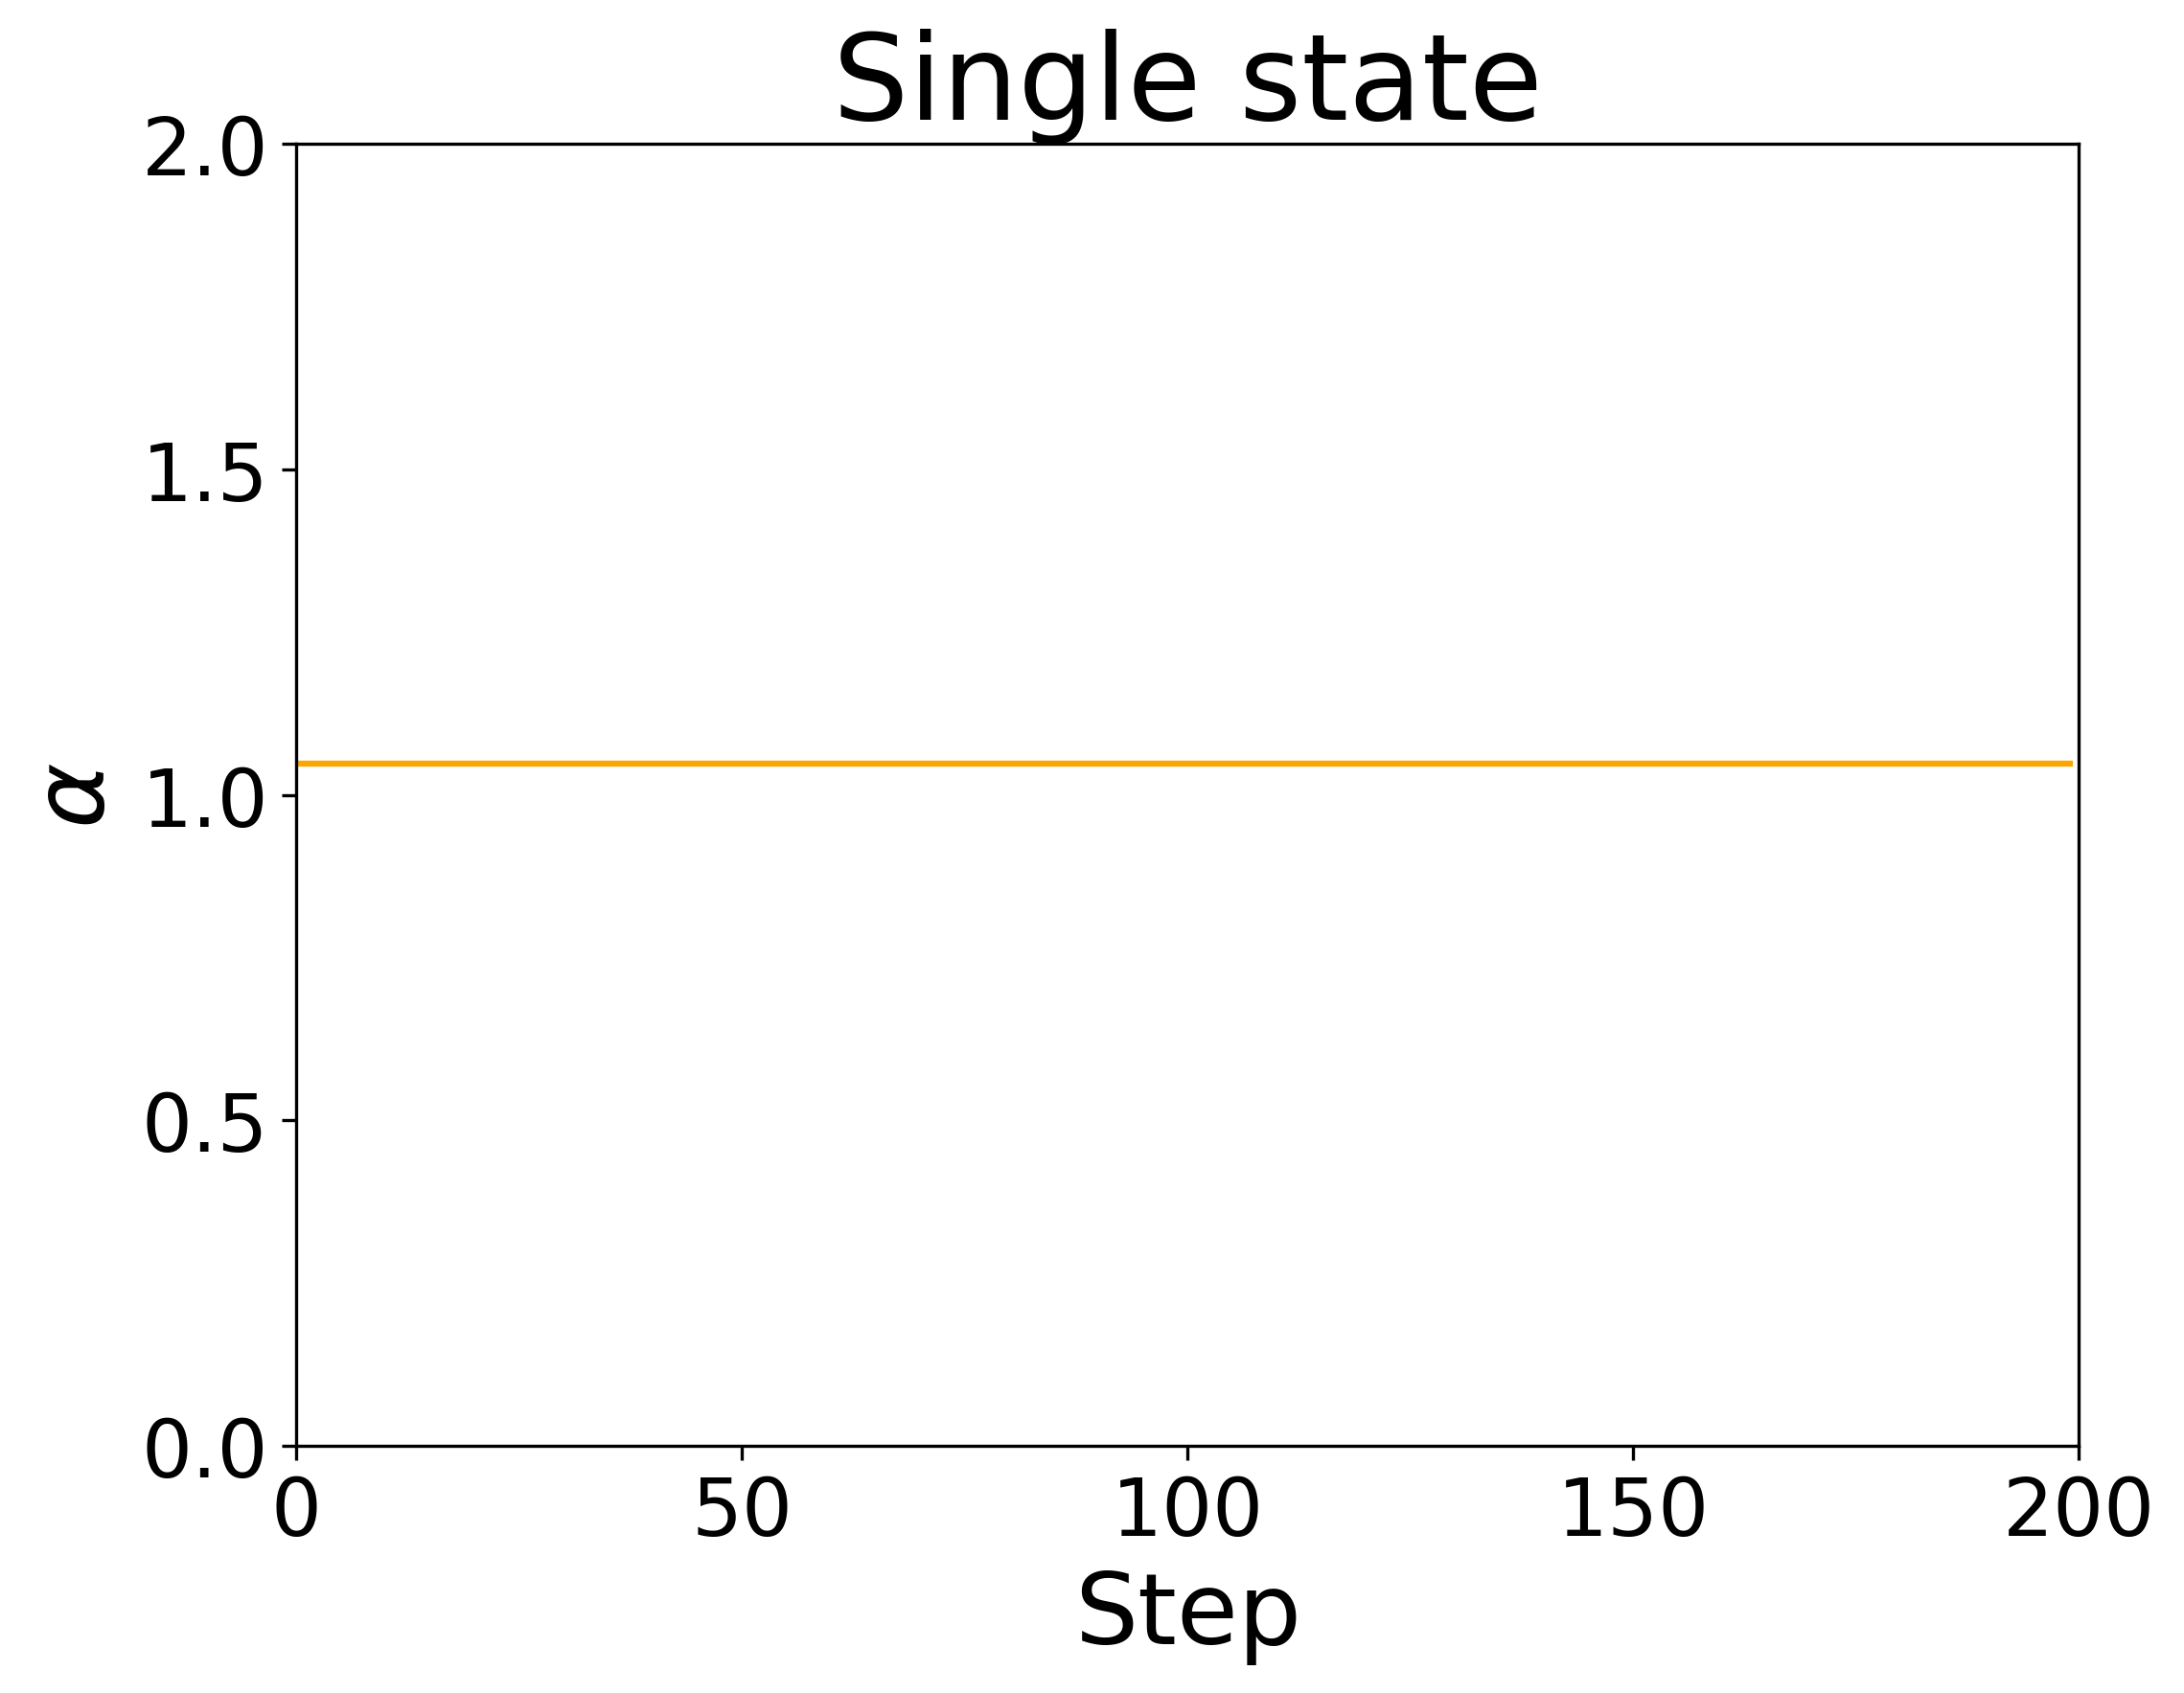

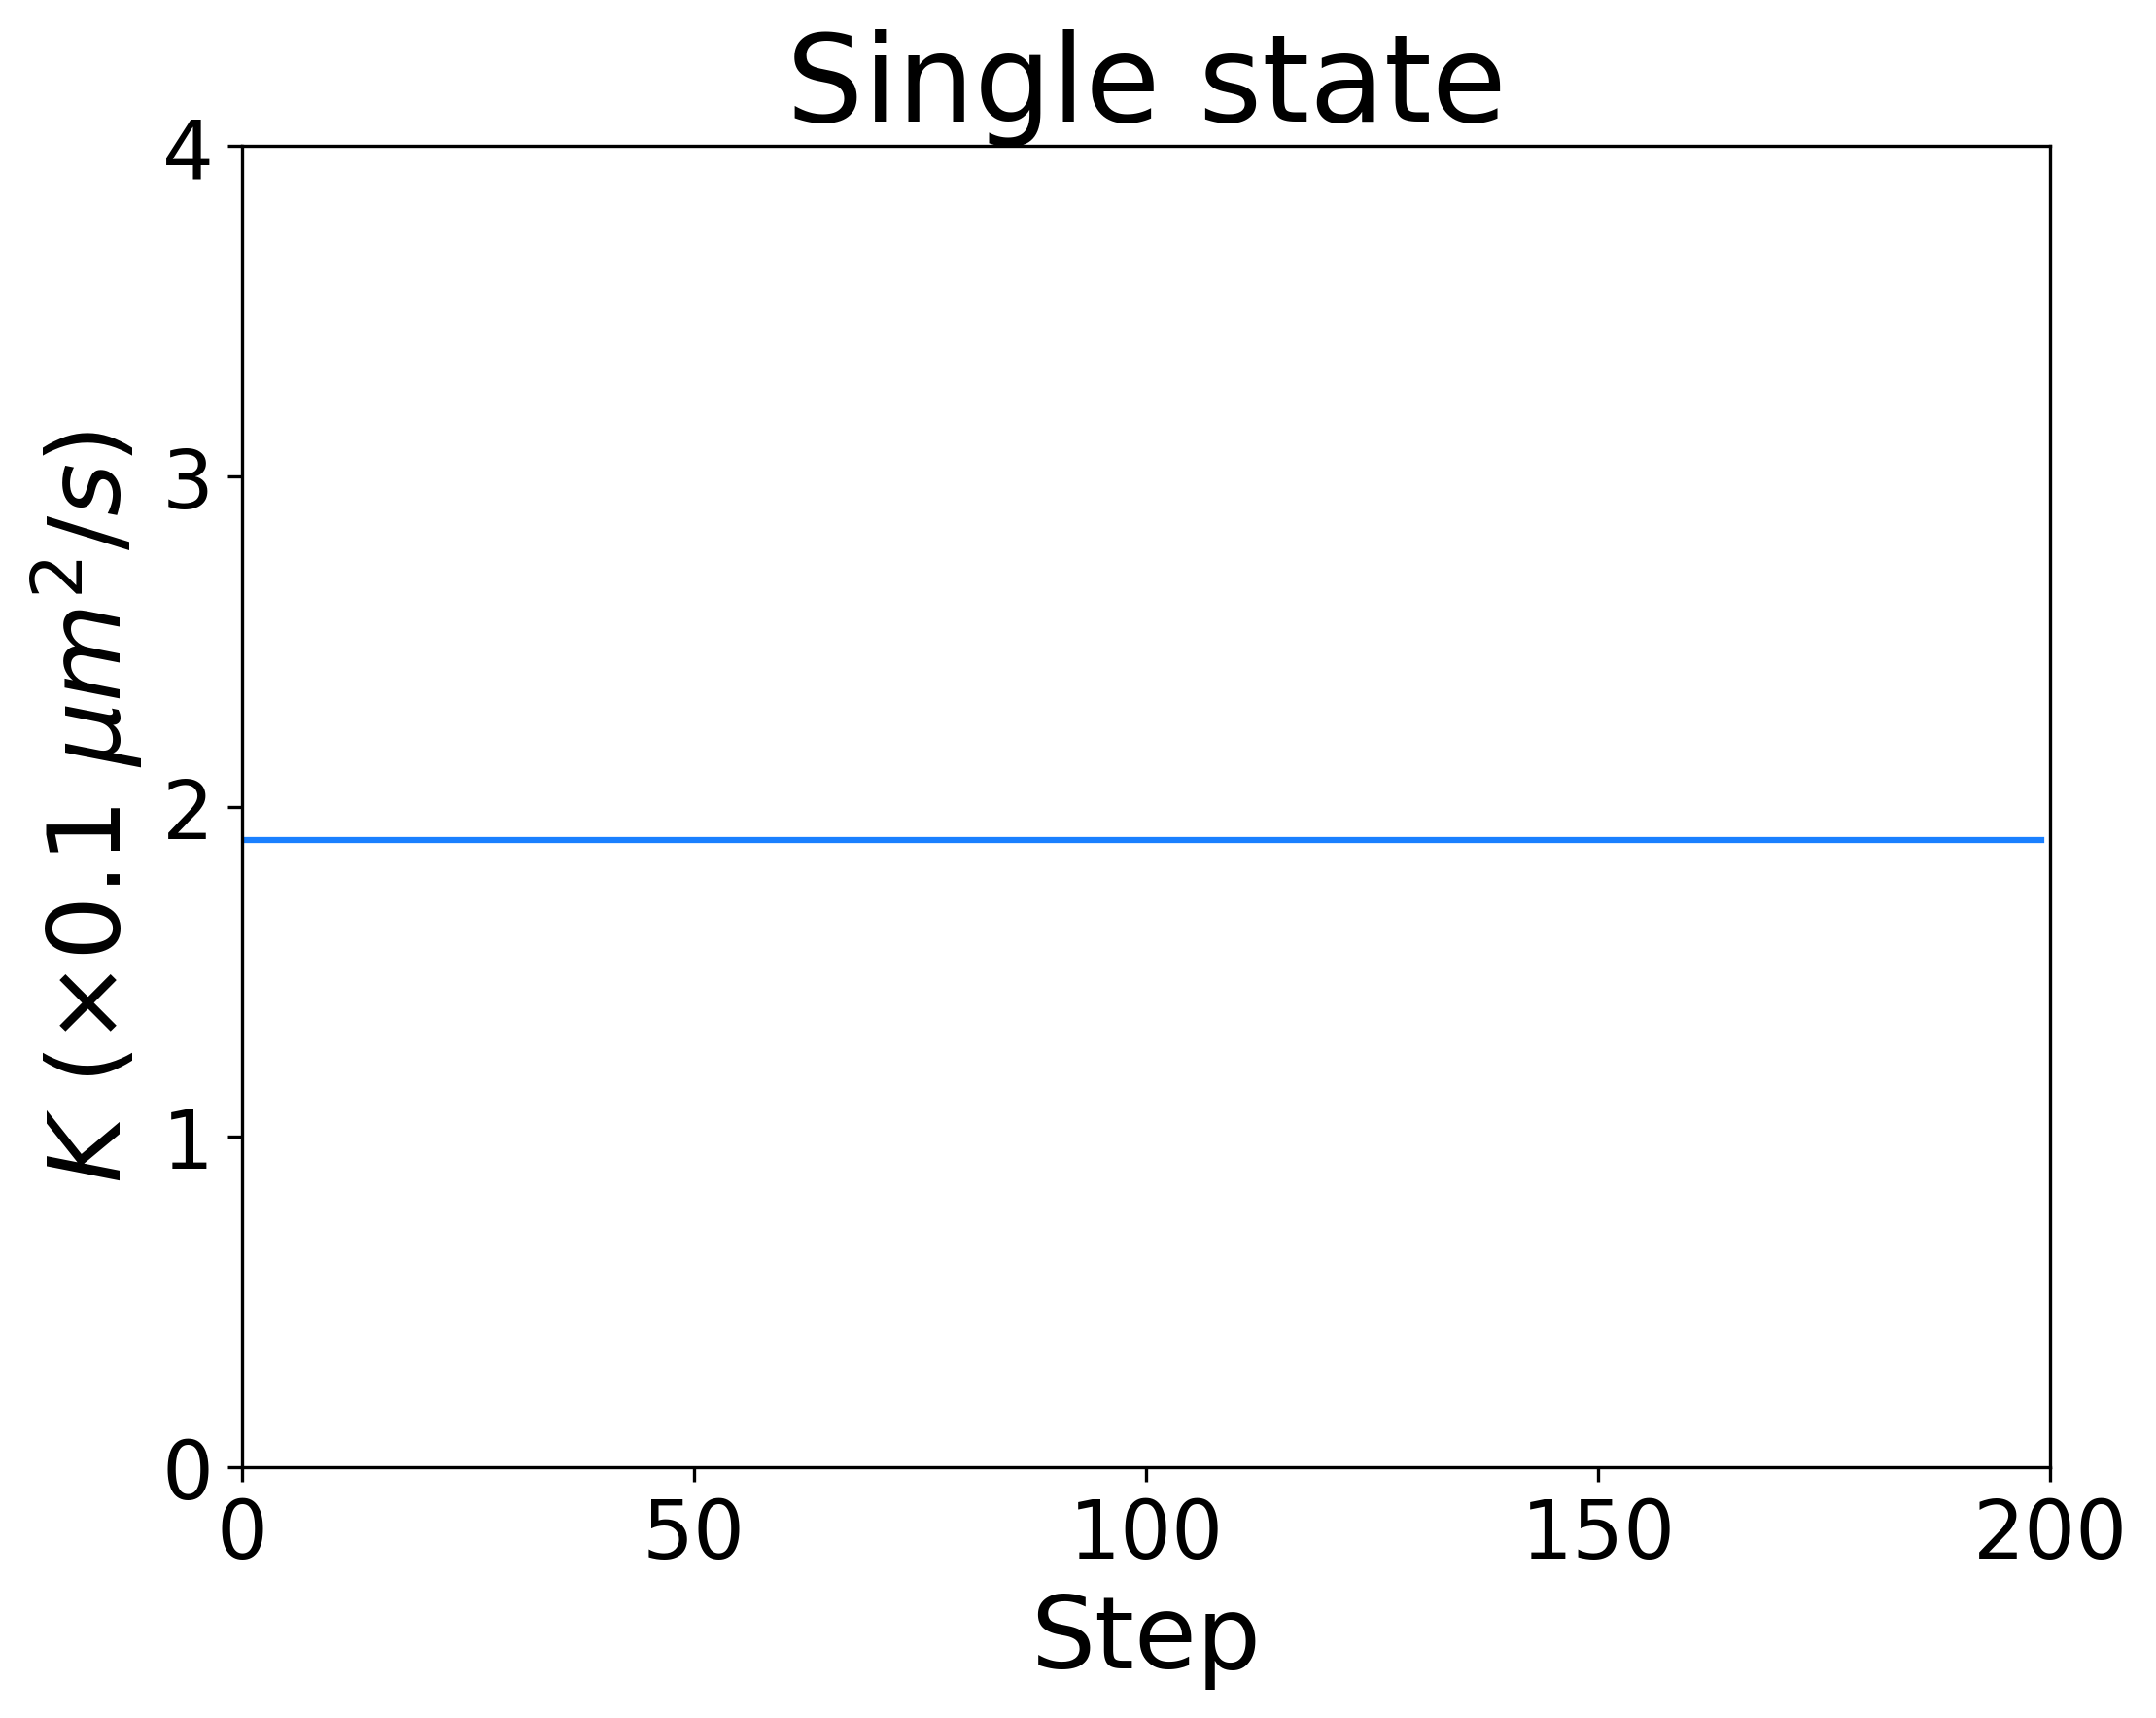

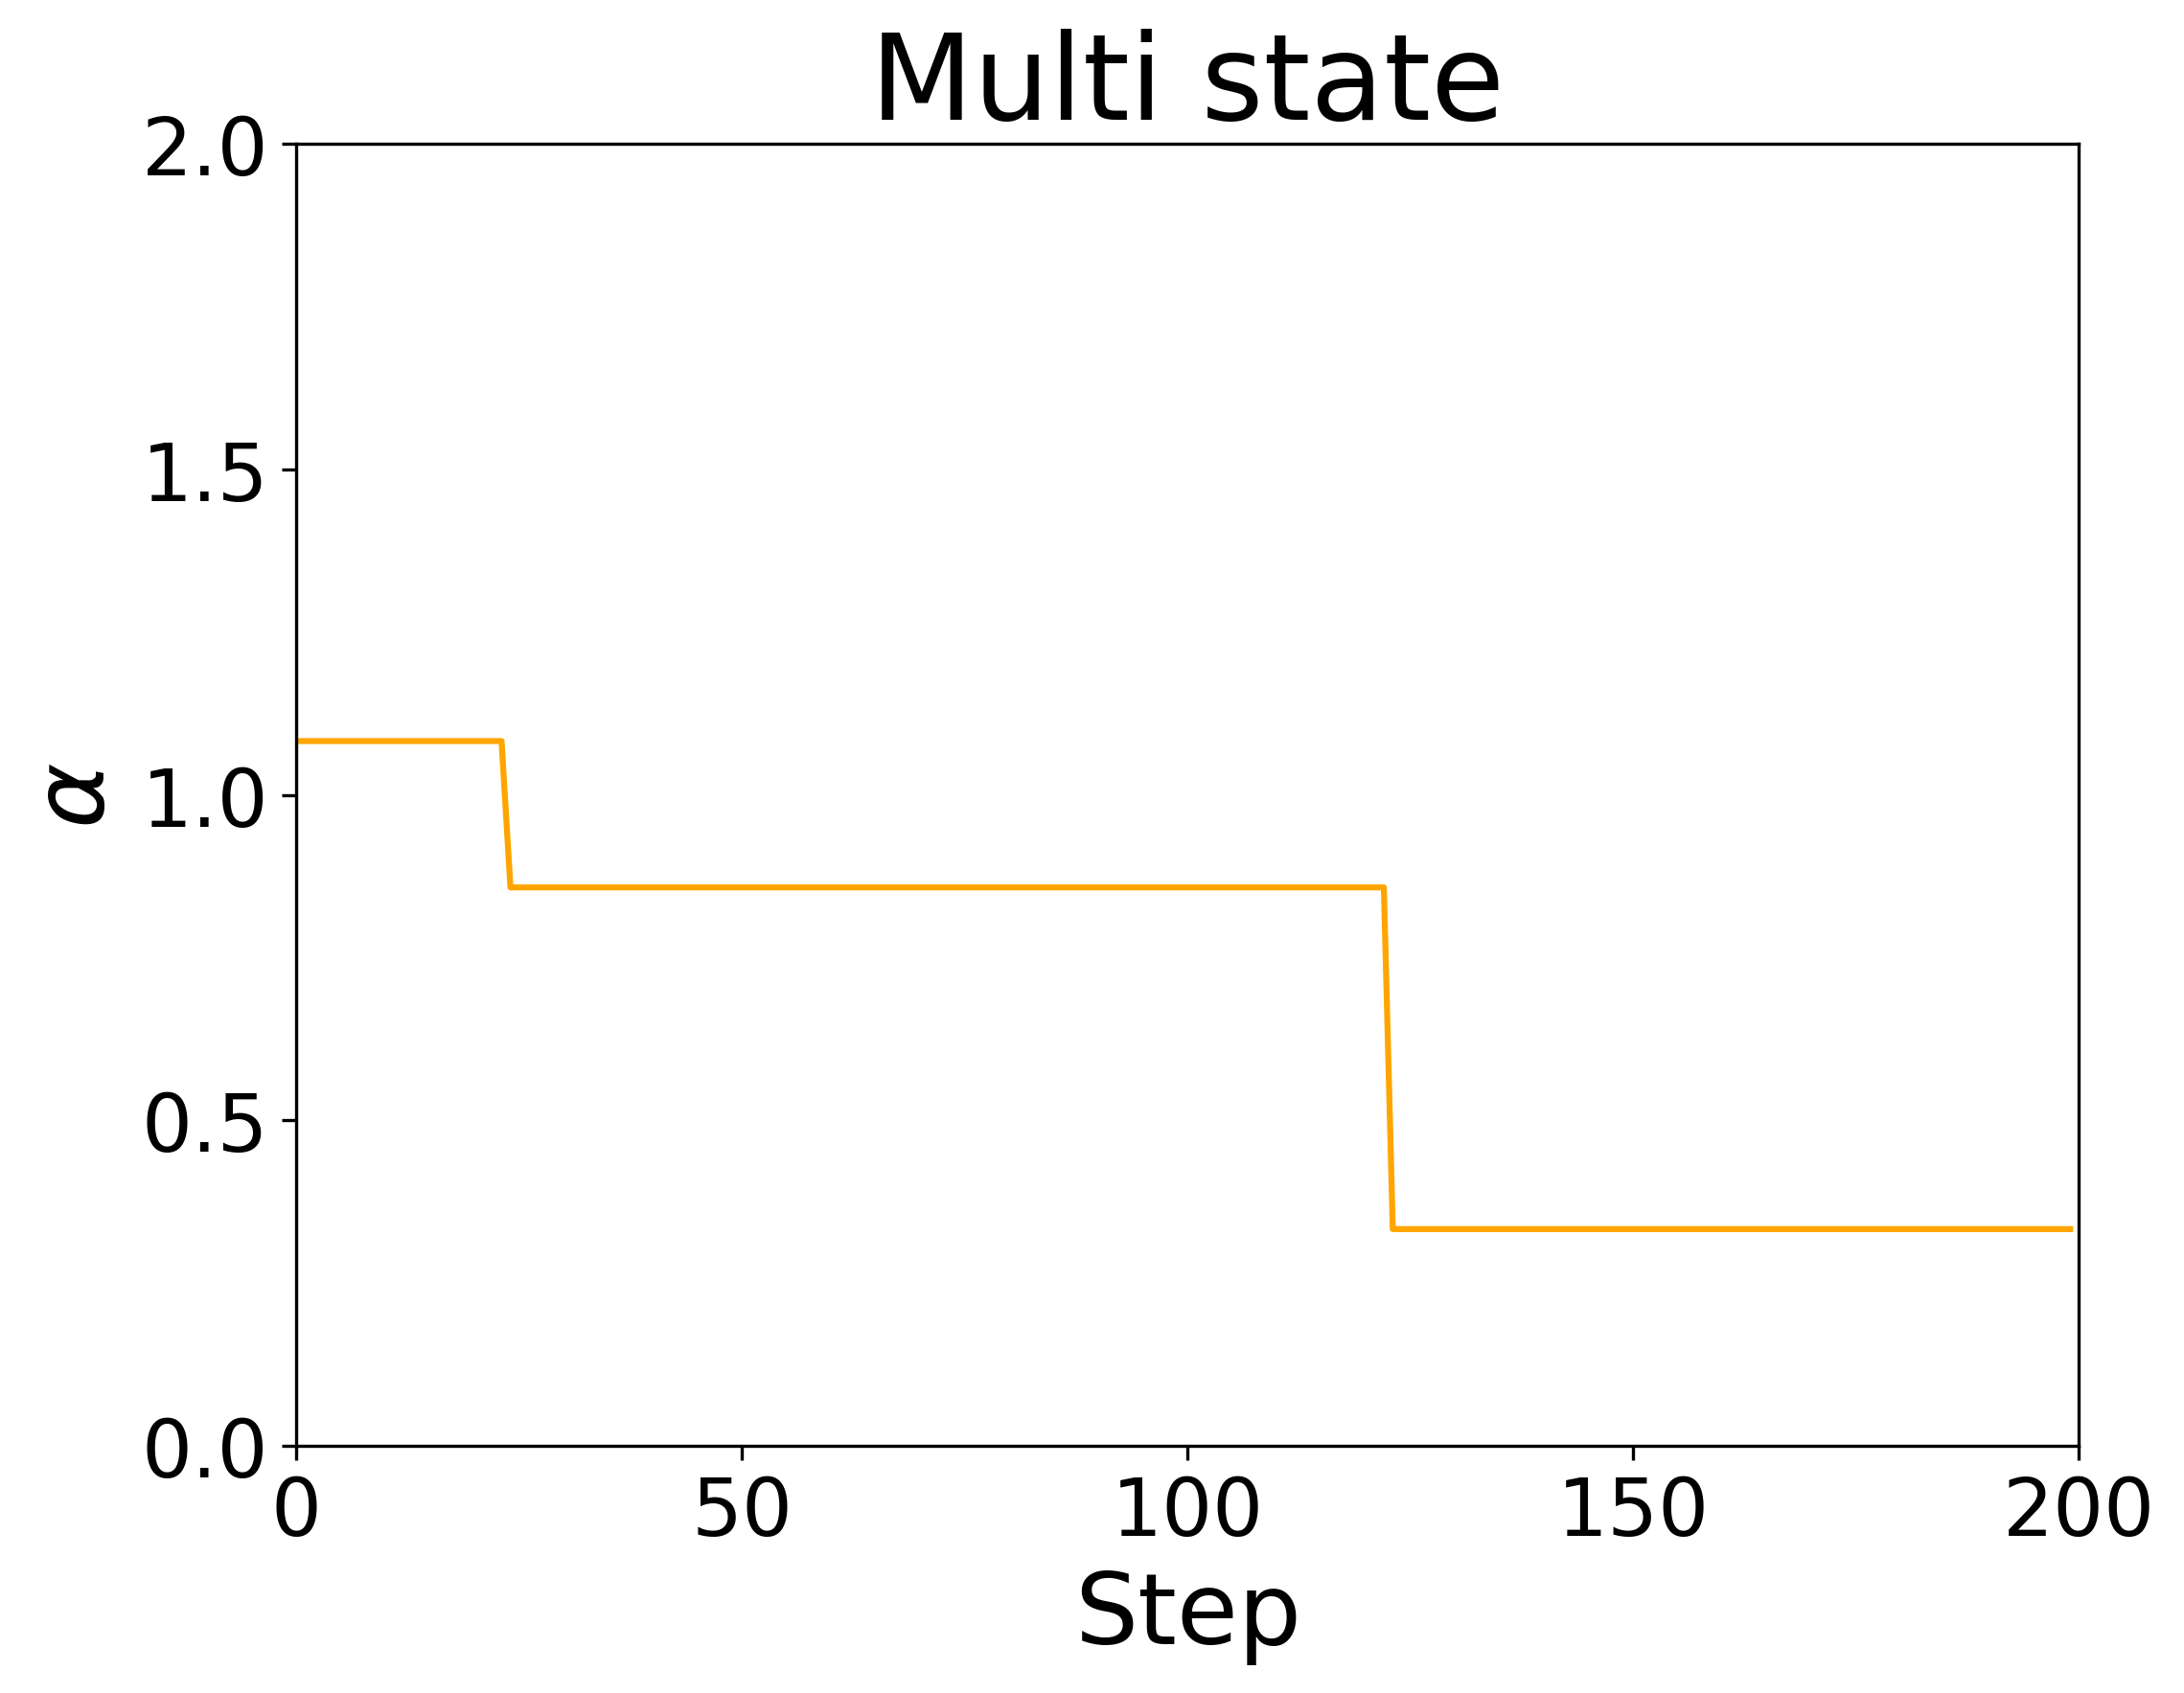

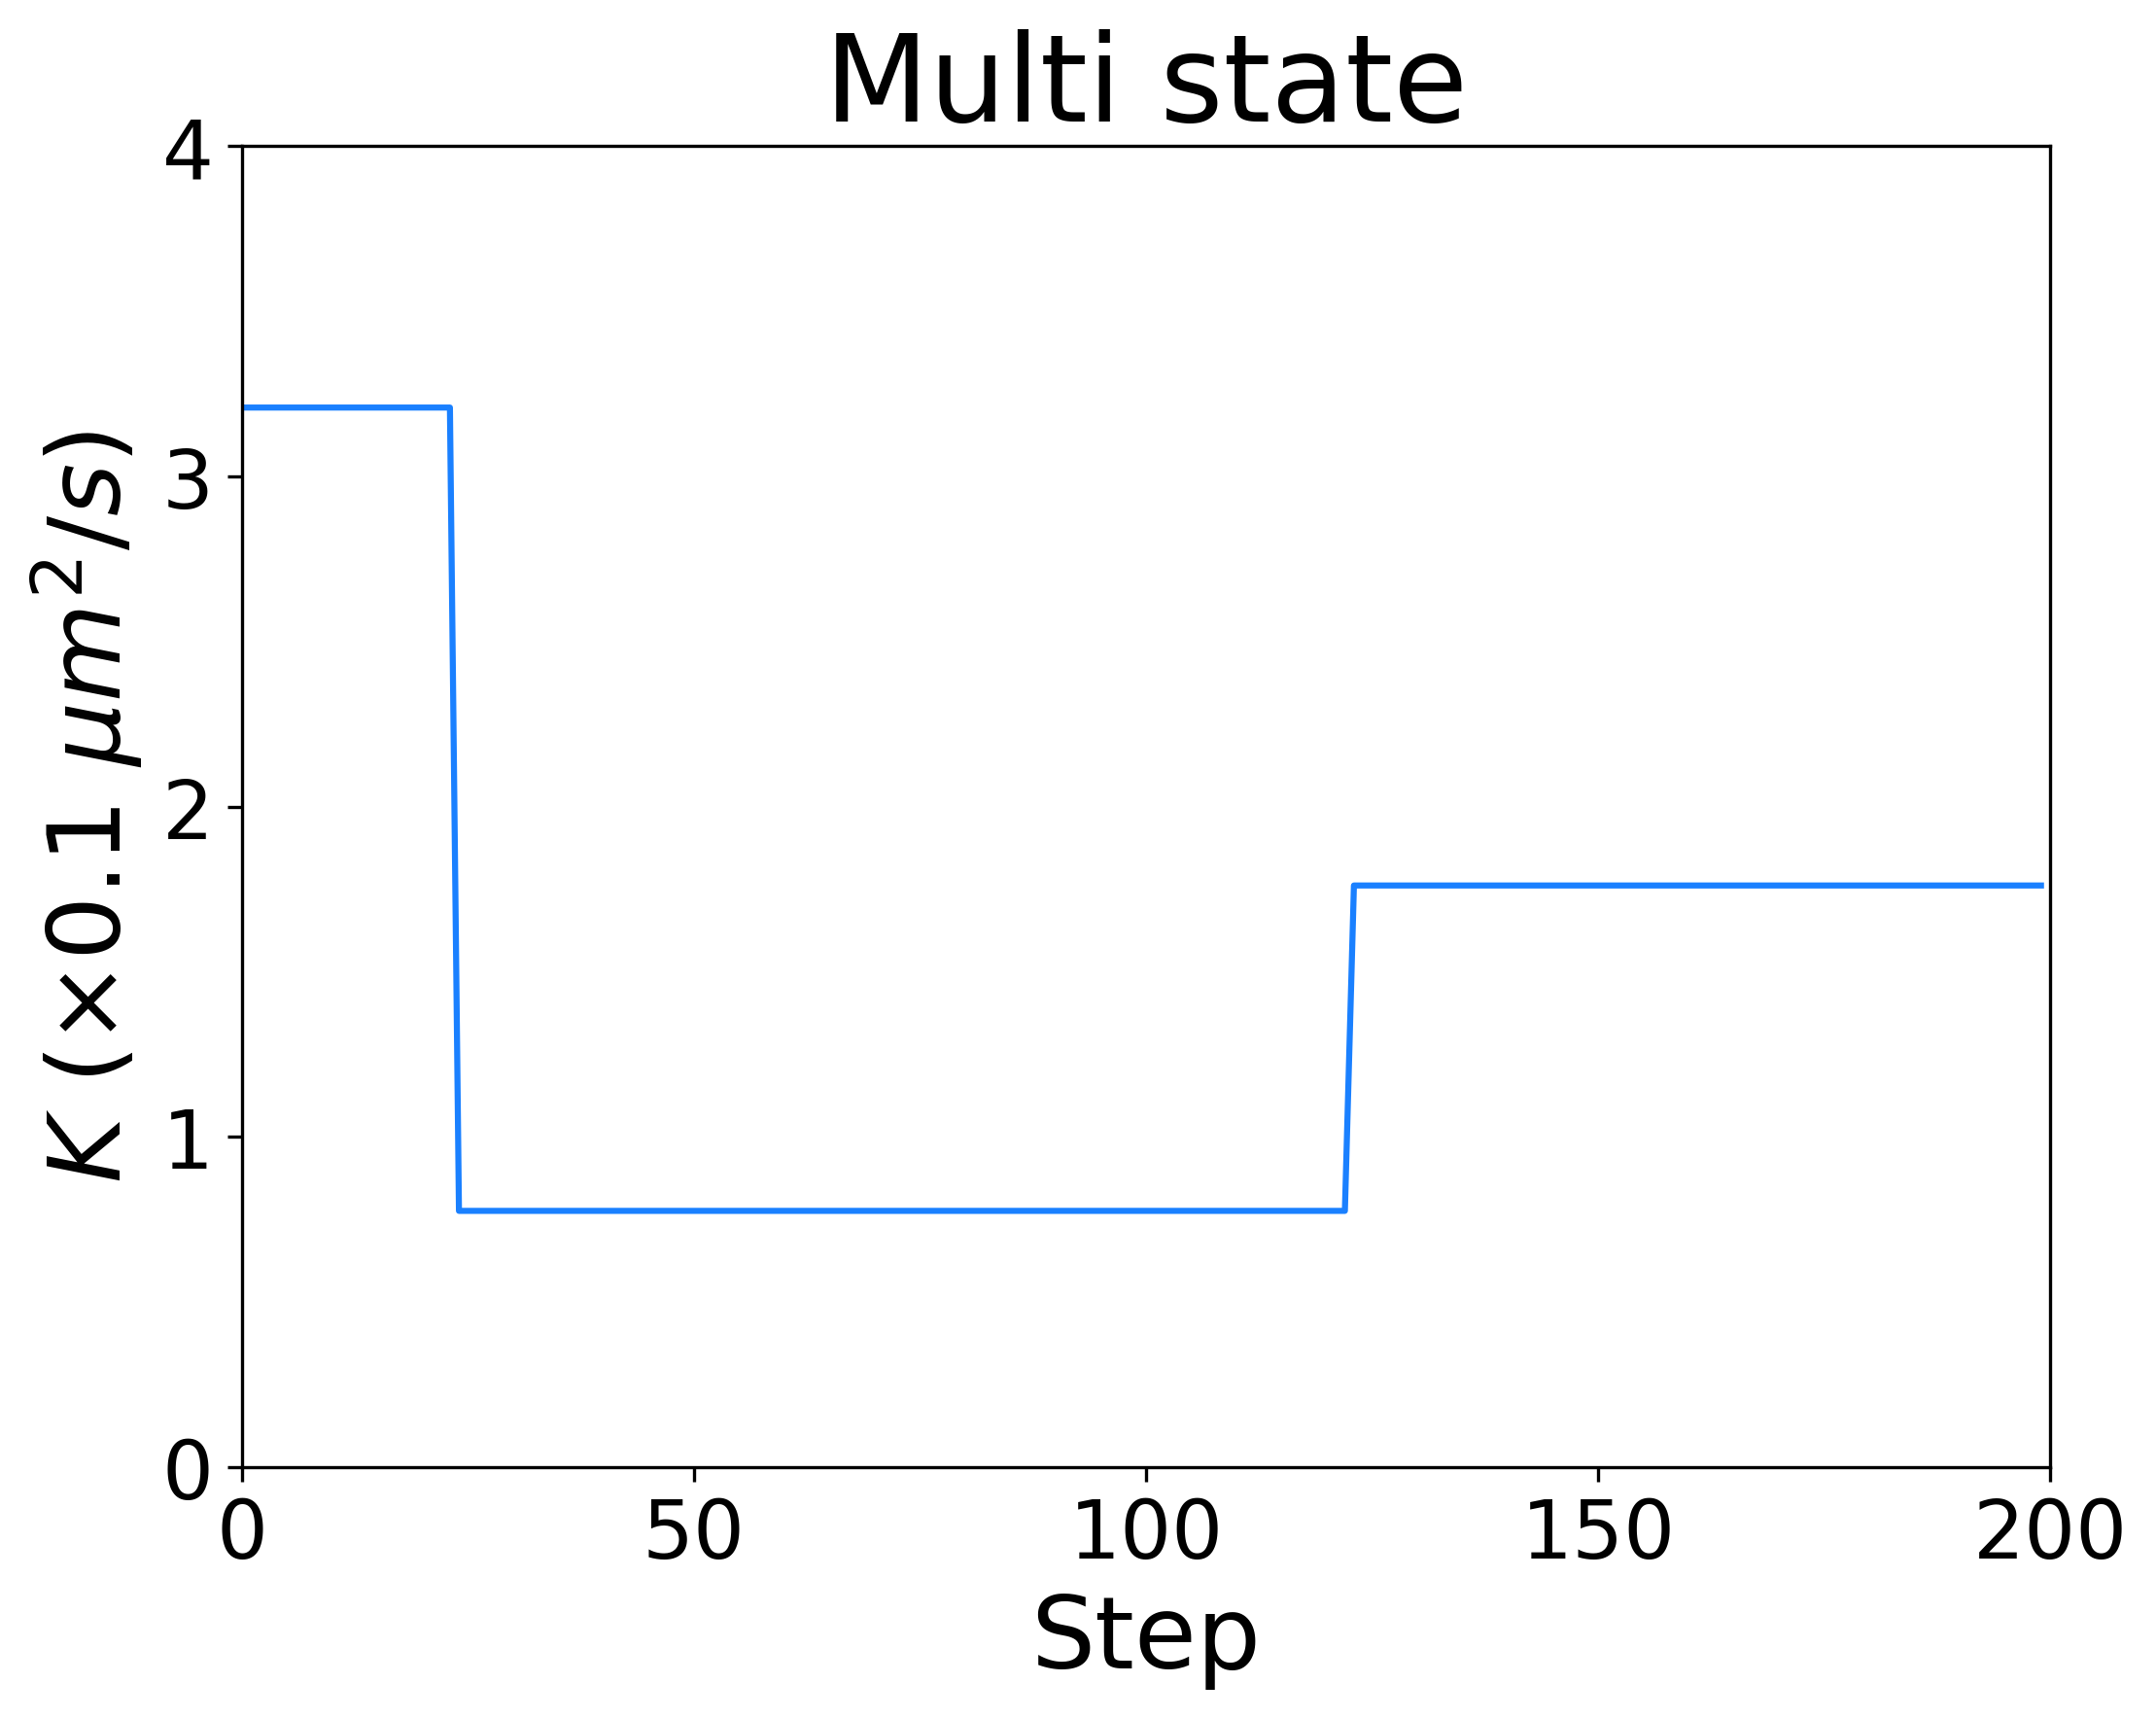

In [713]:
# Features

Time = np.linspace(0.1,18.6,186)
for case in cases[:2]:
    
    n = indexs_best[case]
    plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)
    
    length = length_data[case][2][good_performance_indexs[case][n]]
    alpha_feature = alpha_data[case][2][good_performance_indexs[case][n]]

    
   
    case_cap = case.capitalize()
    plt.title('{}'.format(case_cap + ' ' + 'state'), fontsize =30)


        

    plt.xlabel('Step', fontsize = 25)
    plt.ylabel(r'$\alpha$', fontsize = 25)
    plt.xticks([0,50,100,150,200],fontsize = 20)
    plt.yticks([0,0.5,1.0,1.5,2.0],fontsize = 20)
    plt.ylim([0,2])
    plt.xlim([0,200])
    plt.plot(alpha_feature,'orange')
    plt.show()

    plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)
    
    length = length_data[case][2][good_performance_indexs[case][n]]
    k_feature = k_data[case][2][good_performance_indexs[case][n]]
#     print(k_data[case][2][good_performance_indexs[case][n]])
    

    plt.title('{}'.format(case_cap + ' ' + 'state'), fontsize =30)



    plt.xlabel('Step', fontsize = 25)
    plt.ylabel(r'$K\ (\times0.1\ \mu m^2/s)$', fontsize=25)
    plt.xticks([0,50,100,150,200],fontsize = 20)
    plt.yticks([0,1,2,3,4],fontsize = 20)
    plt.ylim([0,4])
    plt.xlim([0,200])
    plt.plot(k_feature,color = (0.1,0.5,1))
    
    
    plt.show()

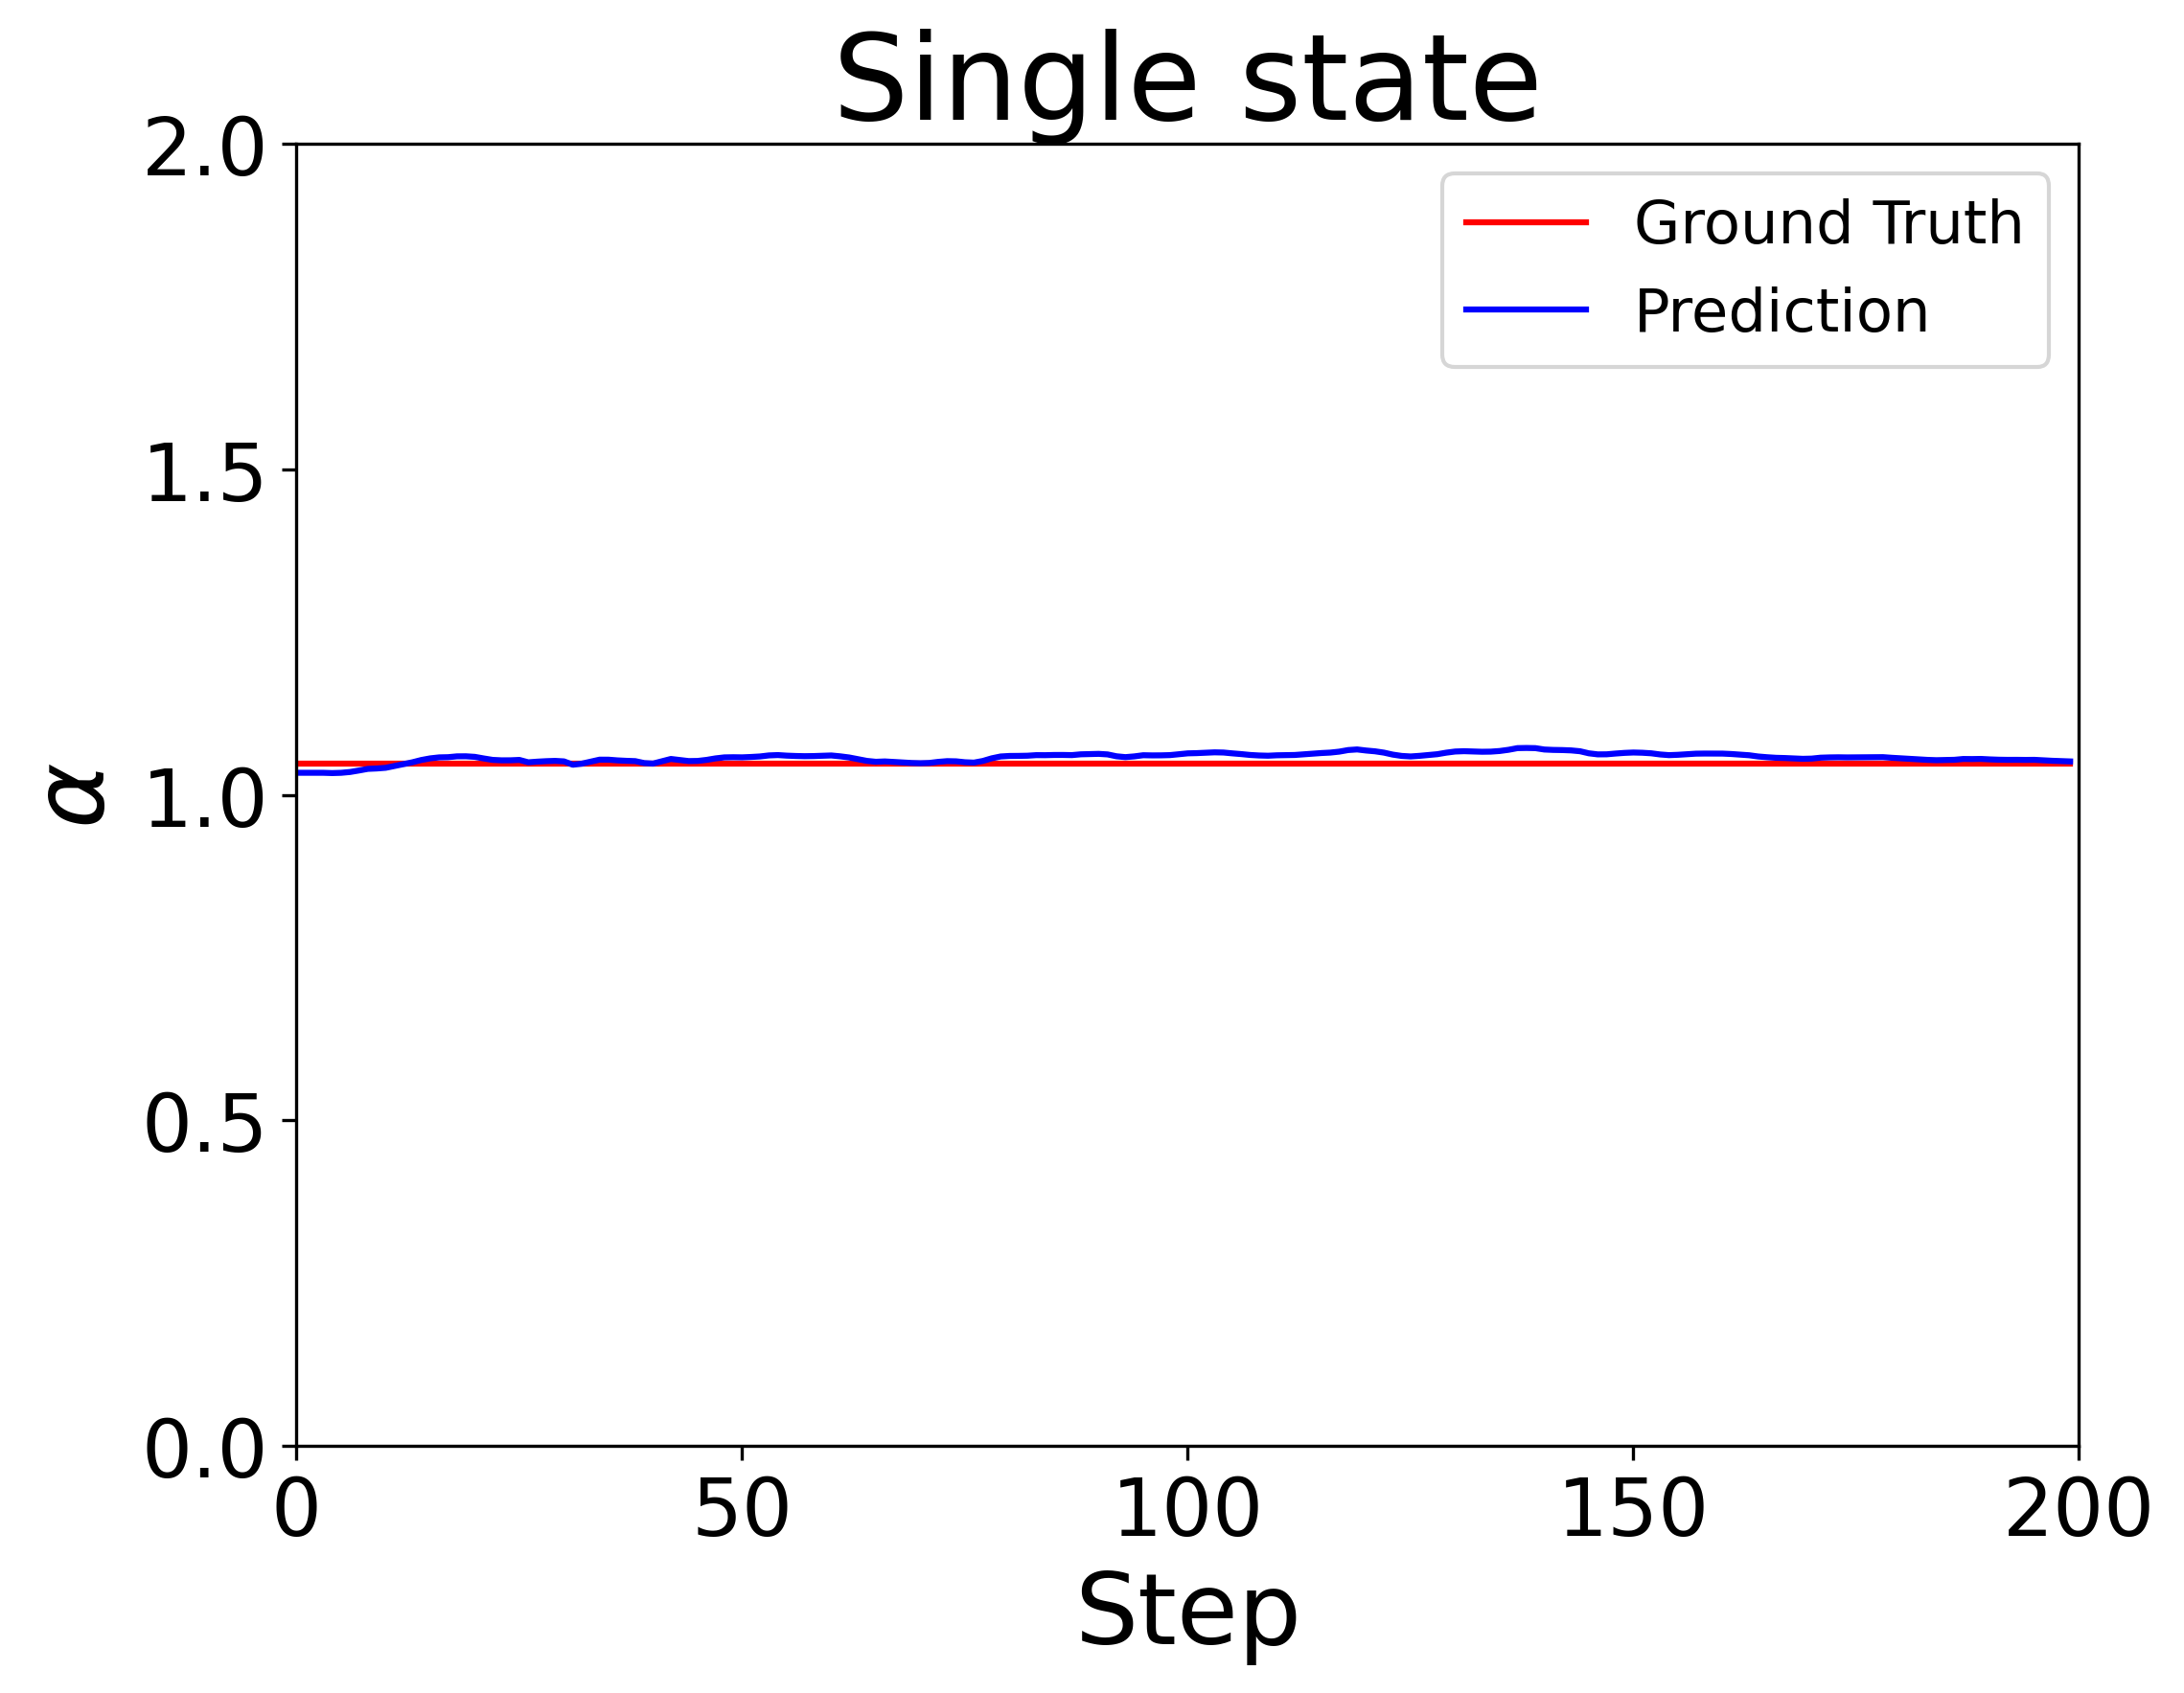

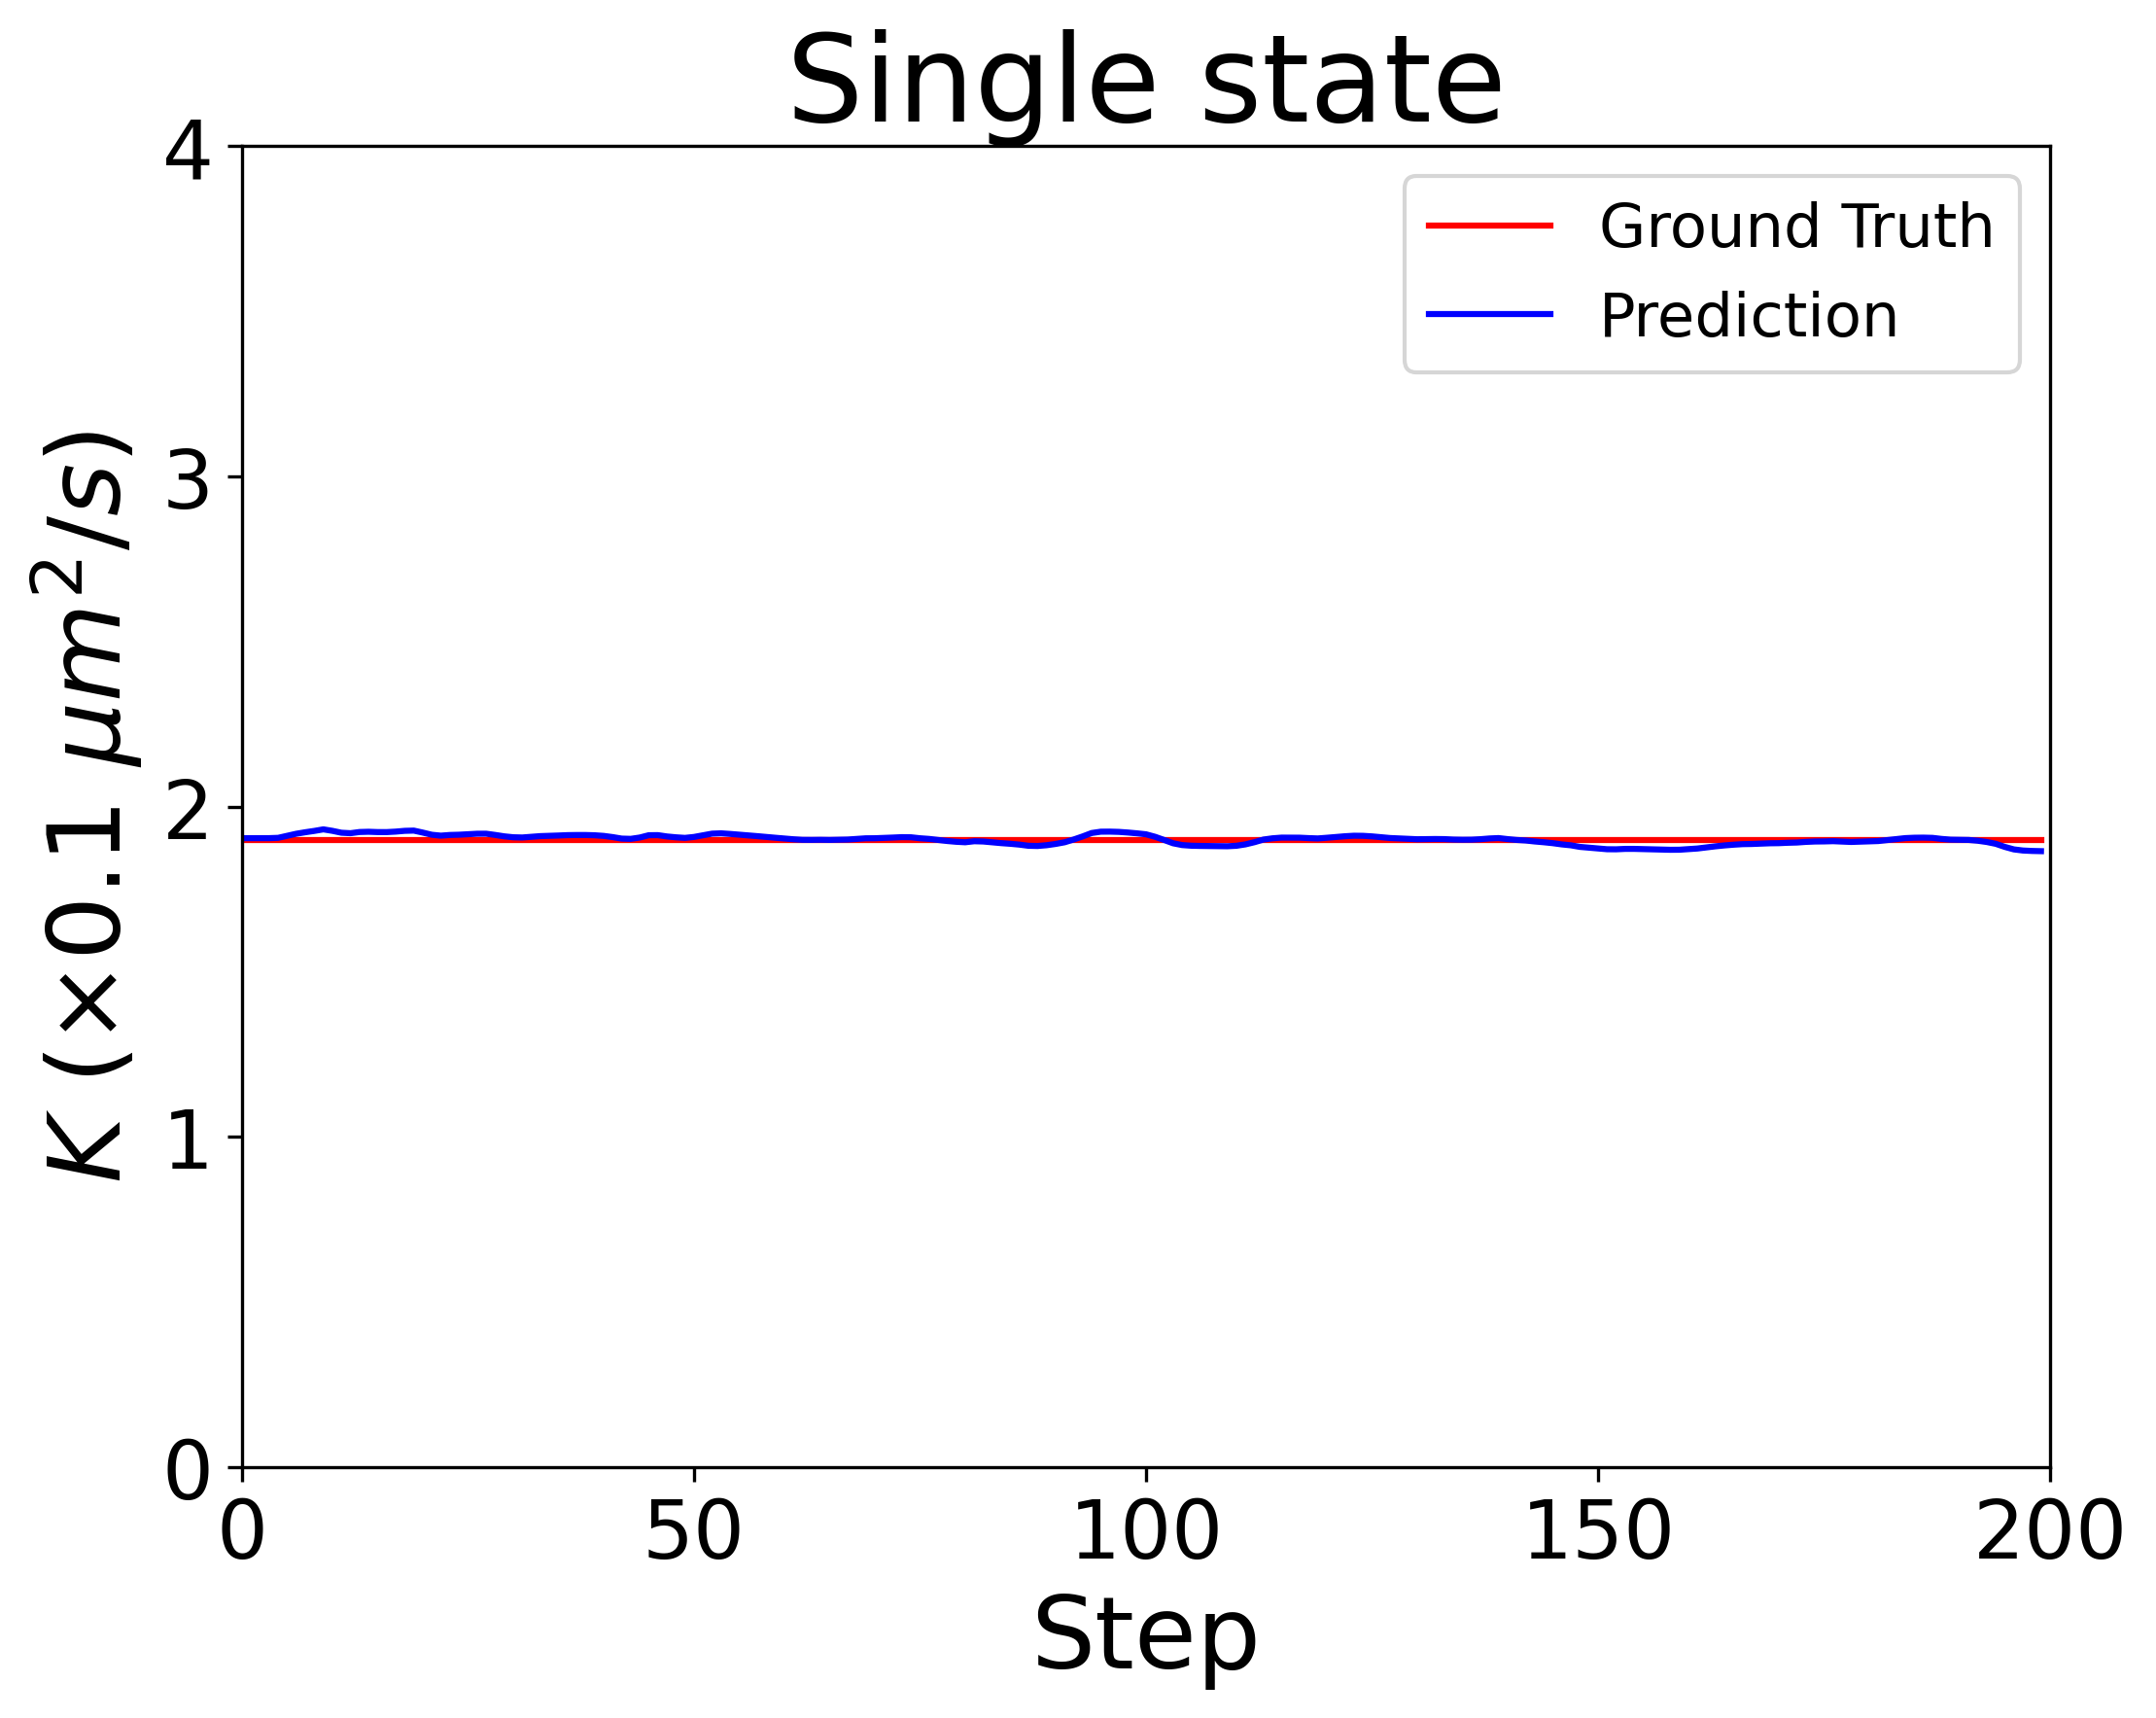

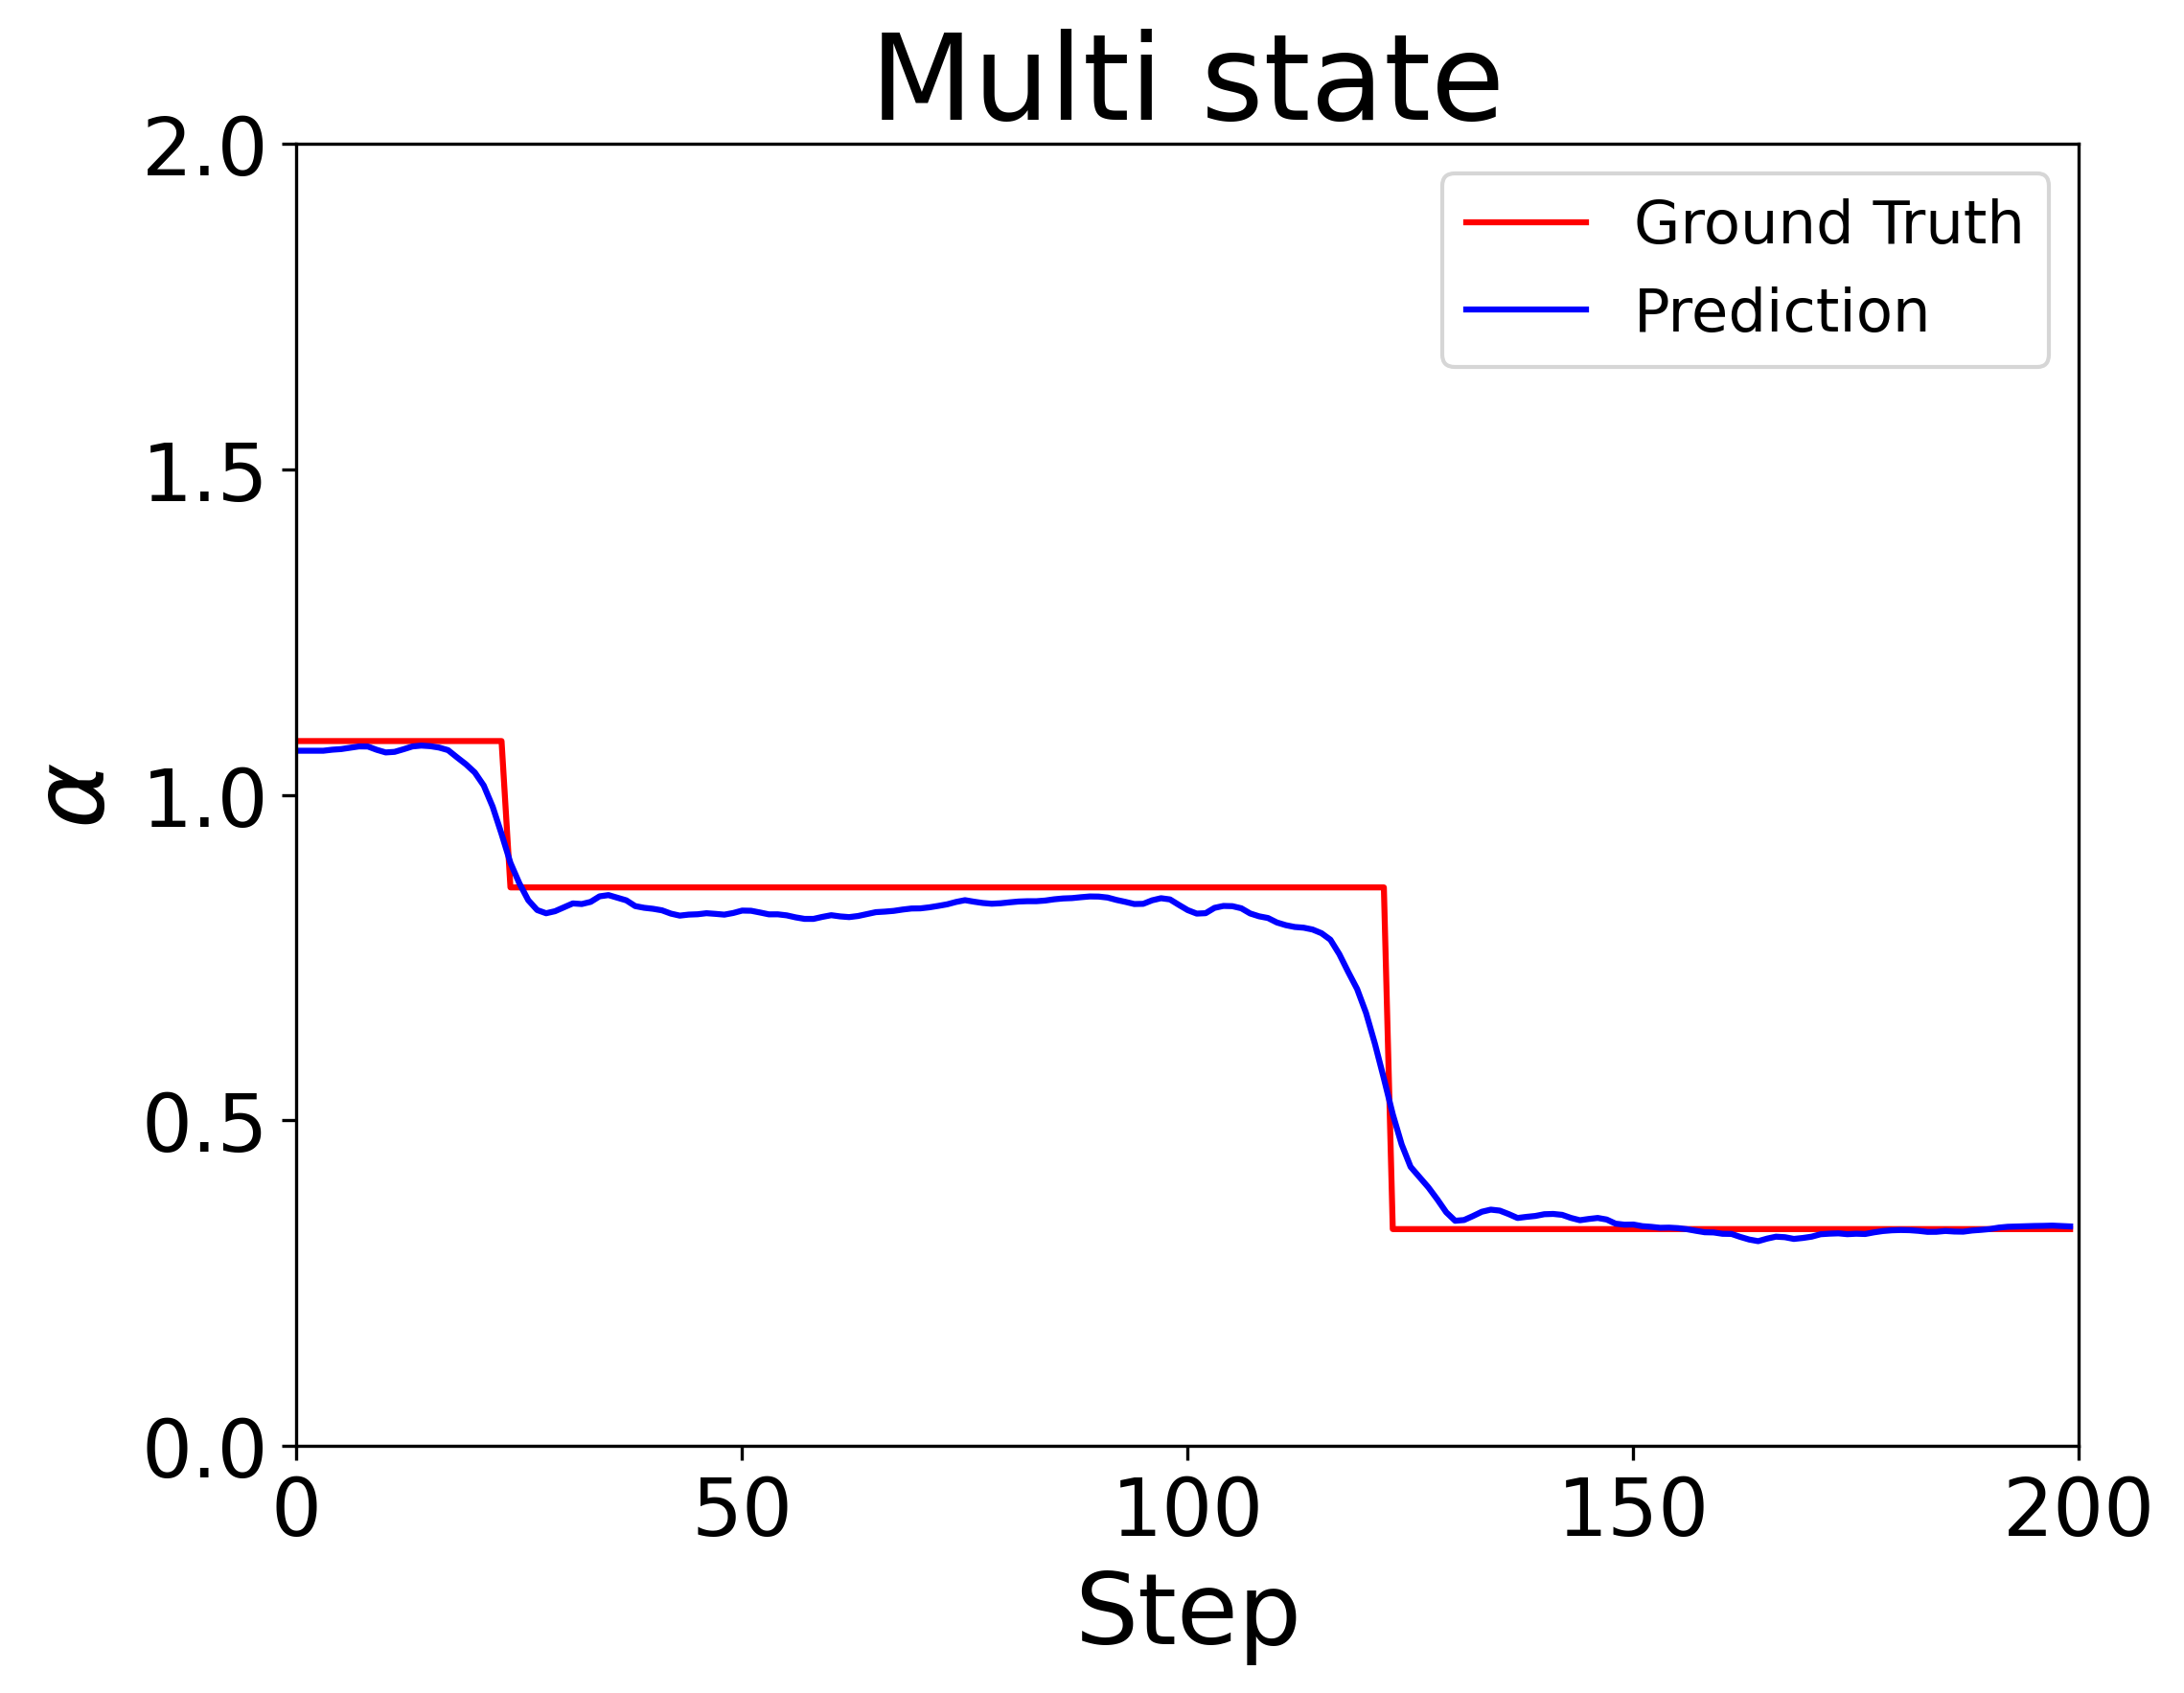

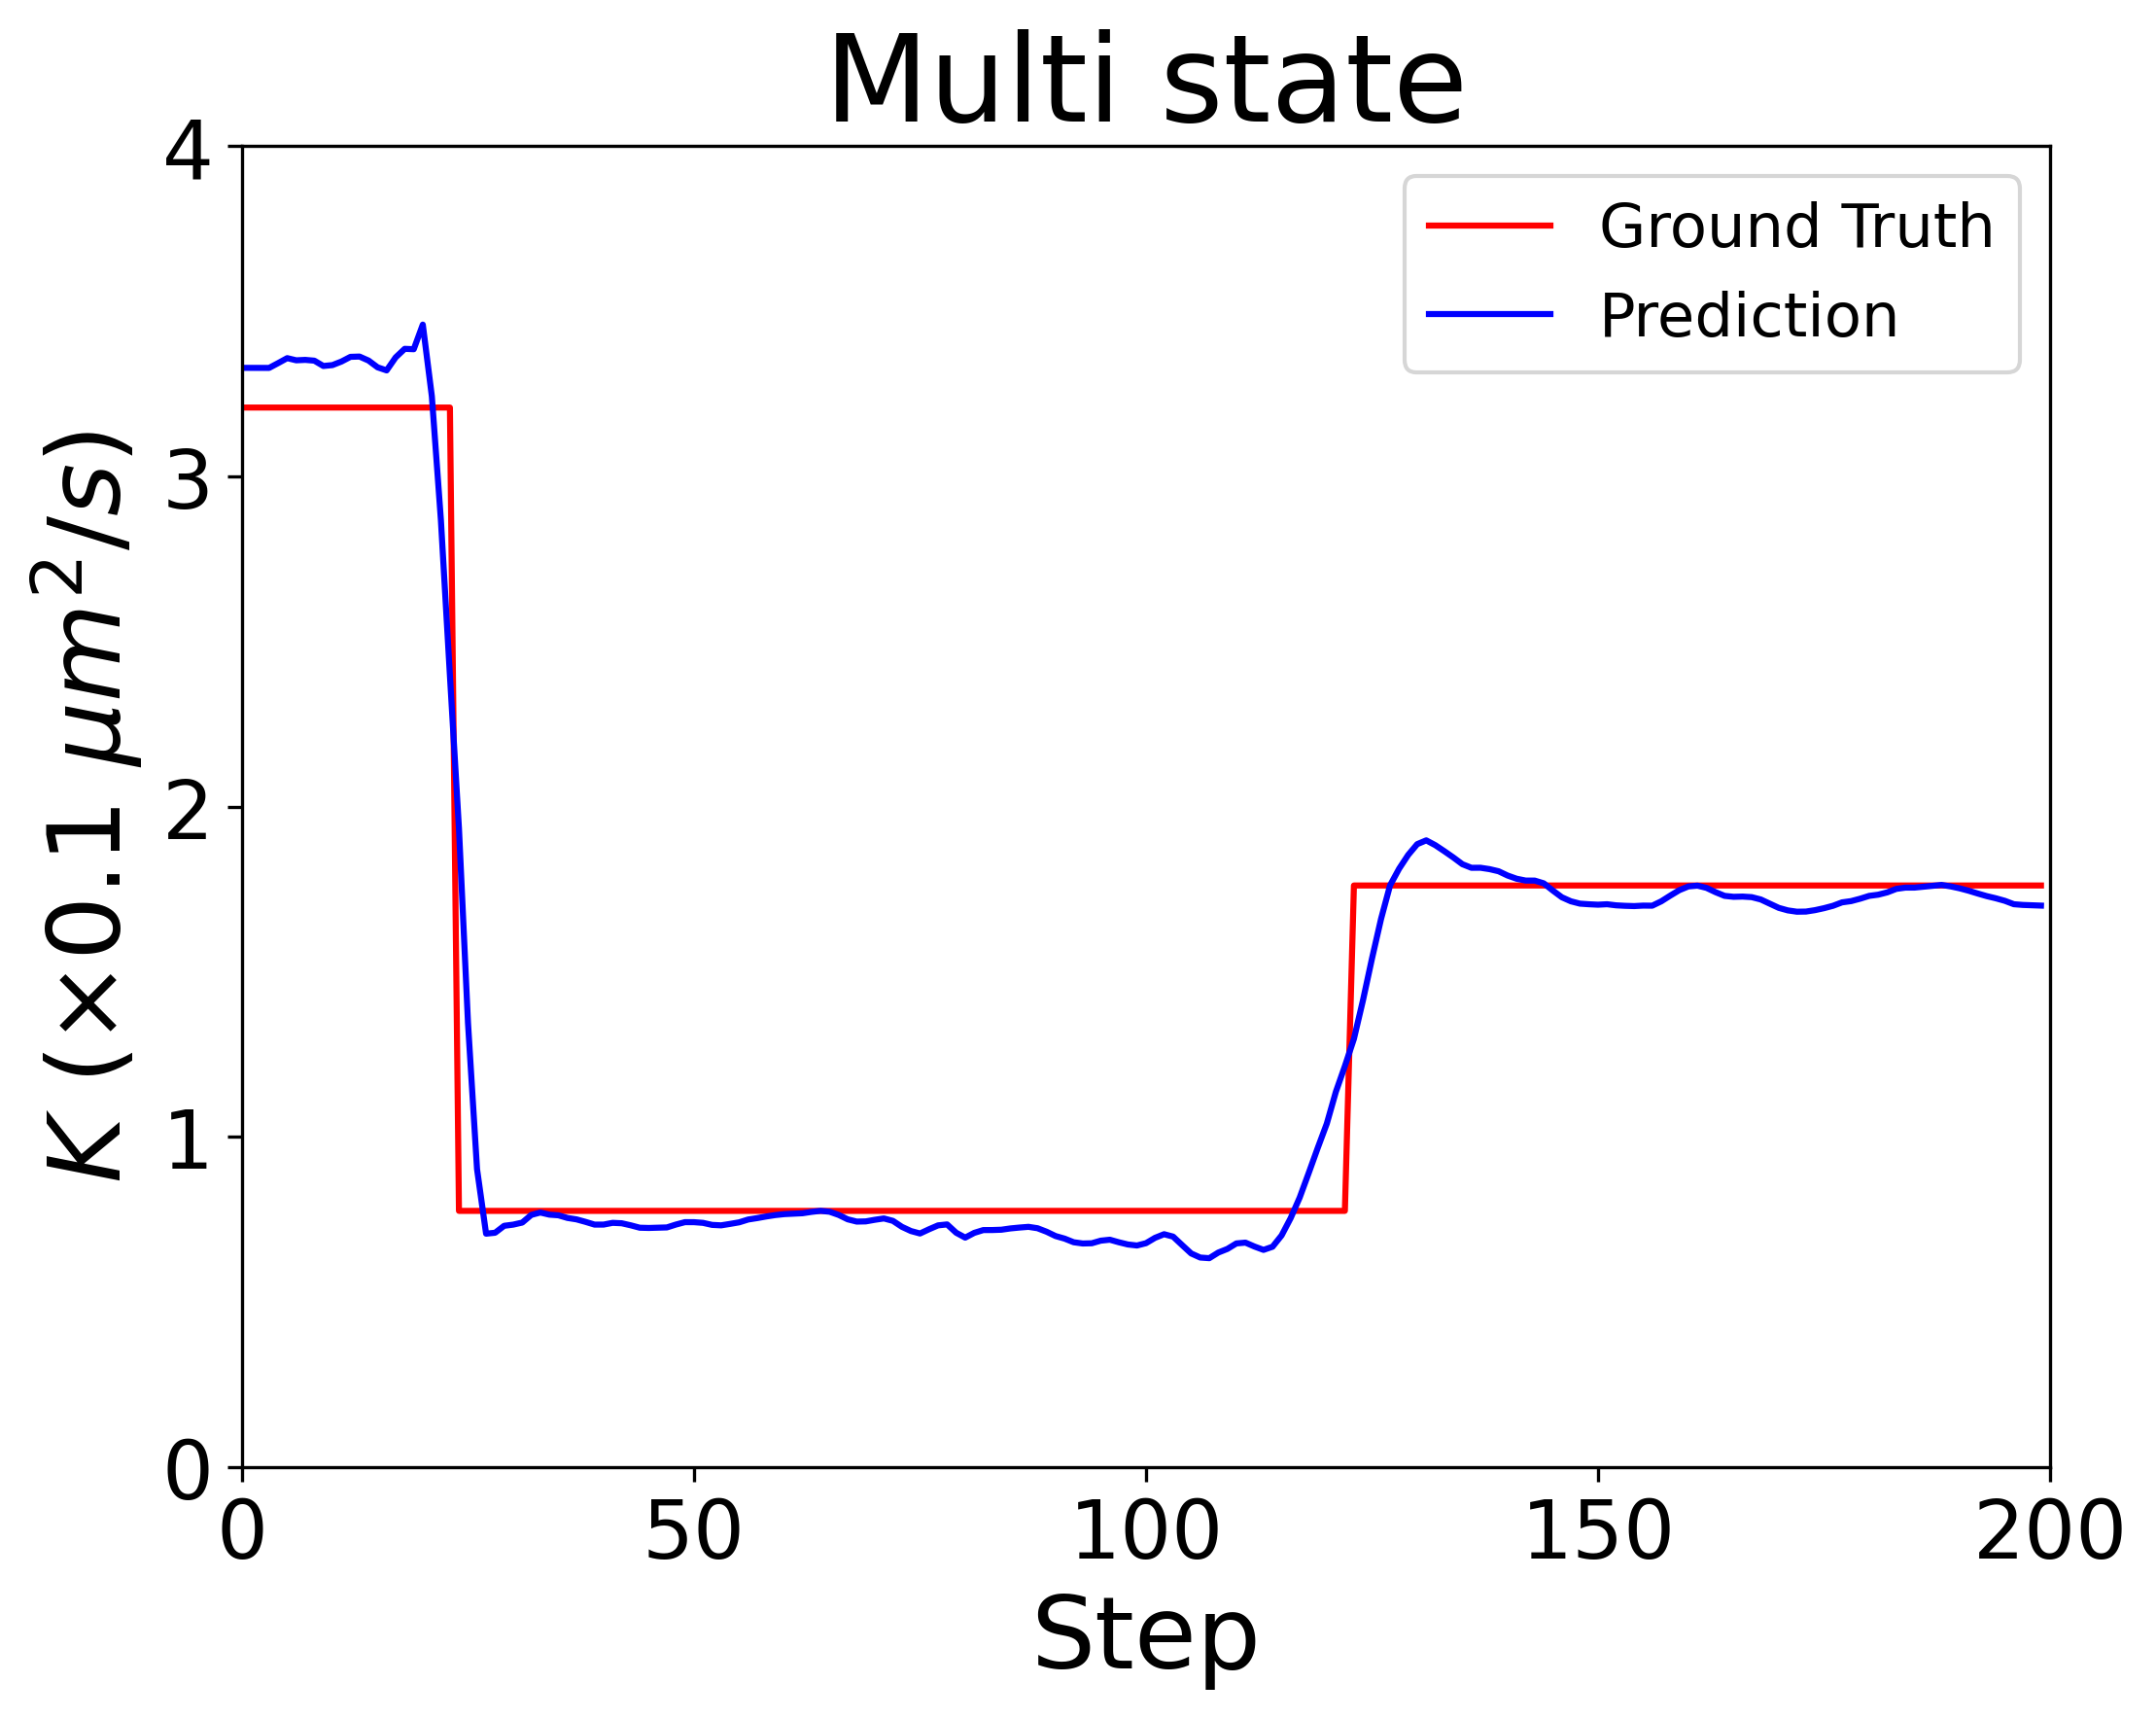

In [714]:
# Represntative examples Deep-learning model performance

Time = np.linspace(0.1,20,200)
for case in cases[:2]:
    
    
    
    n = indexs_best[case]
    plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)
    
    true_alpha = alpha_data[case][2][good_performance_indexs[case][n]]
    pred_alpha = pred_test['alpha'][case][good_performance_indexs[case][n]]
    
    
   
    case_cap = case.capitalize()
    plt.title('{}'.format(case_cap + ' ' + 'state'), fontsize =30)

        
        
    plt.xlabel('Step', fontsize = 25)
    plt.ylabel(r'$\alpha$', fontsize=25)
    plt.xticks([0,50,100,150,200],fontsize = 20)
    plt.yticks([0.0,0.5,1.0,1.5,2.0],fontsize = 20)
    plt.ylim([0,2])
    plt.xlim([0,200])
    plt.plot(true_alpha, label = 'Ground Truth', c = 'r')
    plt.plot(pred_alpha, label = 'Prediction', c = 'b')
    plt.legend(fontsize = 15)
    plt.show()
    
    
    n = indexs_best[case]
    
    plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)
    
    true_k = k_data[case][2][good_performance_indexs[case][n]]
    pred_k = pred_test['k'][case][good_performance_indexs[case][n]]
    


    plt.title('{}'.format(case_cap + ' ' + 'state'), fontsize =30)
        
        
    plt.xlabel('Step', fontsize = 25)
    plt.ylabel(r'$K\ (\times0.1\ \mu m^2/s)$', fontsize=25)
    plt.xticks([0,50,100,150,200],fontsize = 20)
    plt.yticks([0.0,1,2,3,4], fontsize = 20)
    plt.ylim([0.0,4])
    plt.xlim([0,200])
    plt.plot(true_k, label = 'Ground Truth', c = 'r')
    plt.plot(pred_k, label = 'Prediction', c = 'b')
    plt.legend(fontsize = 15)
    plt.show()

In [715]:
# list.pop(index): index 데이터 삭제.

def remove_close_elements(input_list):
    i = 0
    while i < len(input_list) - 1:
        if input_list[i+1] - input_list[i] < 3:
            input_list.pop(i+1)
        else:
            i += 1
    return input_list

In [716]:
remove_close_elements([1,2,3])

[1]

In [717]:
predicted_cp = {}
for case in cases:
    predicted_cp[case] = []

print(predicted_cp)

{'single': [], 'multi': [], 'immobile': [], 'dimerization': [], 'confinement': []}


In [718]:
def jaccard_similarity_with_tolerance(preds, reals, tolerance):
    # 교집합 구하기 (허용 오차 적용)
    
    jsc = []
    diff = []
    for n in range(len(preds)):
        pred = preds[n]
        real = reals[n]
        matched_real = set()
        matched_pred = set()
        
        diff_n = []
        for r in real:
            for p in pred:
                if abs(p - r) <= tolerance:
                    matched_real.add(r)
                    matched_pred.add(p)
                    
                    diff_n.append(np.abs(r-p))

        # 교집합은 매칭된 pred와 real 모두 고려
        intersection = matched_real.union(matched_pred)

        # 합집합 구하기 (중복 없이)
        union = set(pred).union(set(real))

        # Jaccard Similarity 계산
        jaccard_similarity = len(intersection) / len(union)
        
        if len(diff_n) > 0:
        
            diff.append(np.mean(diff_n))
        
        jsc.append(jaccard_similarity)
    return np.mean(jsc),np.mean(diff),intersection,union

In [719]:
pred = [10,15,44,49,88,106]
real = [12,49,66,90,114]

In [720]:
a = set()
a.add(1)
a.add(1)

print(pred)
print(real)
union = set(pred).union(set(real))

print(union)
# print(len(union))
print(jaccard_similarity_with_tolerance([pred], [real],9)[0])
print(jaccard_similarity_with_tolerance([pred], [real],9)[1])

print(jaccard_similarity_with_tolerance([pred], [real], 9)[2])
print(jaccard_similarity_with_tolerance([pred], [real], 9)[3])

[10, 15, 44, 49, 88, 106]
[12, 49, 66, 90, 114]
{66, 106, 10, 44, 12, 15, 49, 114, 88, 90}
0.9
3.3333333333333335
{10, 106, 12, 44, 15, 49, 114, 88, 90}
{66, 106, 10, 44, 12, 15, 49, 114, 88, 90}


In [721]:
[2,3,5,0,2]

[2, 3, 5, 0, 2]

In [722]:
jaccard_similarity_with_tolerance([pred], [real], 9)

(0.9,
 3.3333333333333335,
 {10, 12, 15, 44, 49, 88, 90, 106, 114},
 {10, 12, 15, 44, 49, 66, 88, 90, 106, 114})

In [723]:
# consider alpha and k

def cpd_v1_two_side(alpha,k,T,Th_alpha,Th_k, end_index):
    
    pred_cp = []
    reconstructed_feature1 = alpha[:int(T-end_index)]
    reconstructed_feature2 = k[:int(T-end_index)]
    T_length = T

    alpha_diff_max = np.max(np.abs(np.diff(reconstructed_feature1)))
    k_diff_max = np.max(np.abs(np.diff(reconstructed_feature2)))
    
#     alpha_diff_mean = np.mean(np.abs(np.diff(reconstructed_feature1)))
#     k_diff_mean = np.mean(np.abs(np.diff(reconstructed_feature2)))
    
#     alpha_diff_std = np.std(np.abs(np.diff(reconstructed_feature1)))
#     k_diff_std = np.std(np.abs(np.diff(reconstructed_feature2)))
    
#     alpha_cv = alpha_diff_std/alpha_diff_mean
#     k_cv = k_diff_std/k_diff_mean
# #     alpha_diff_mean = np.max(np.abs(np.diff(reconstructed_feature1)))

    if alpha_diff_max > Th_alpha or k_diff_max > Th_k:
        if alpha_diff_max >= k_diff_max:
            delta_feature = np.abs(np.diff(alpha))
            anomaly_index = 0
            anomaly_zip = []
            for n_zip in range(67):
                anomaly_zip.append([])


            for t, data_t in enumerate(delta_feature[:-1]):
                if data_t > Th_alpha:
                    anomaly_zip[anomaly_index].append((t,data_t))
                    if delta_feature[t + 1] <= Th_alpha:
                        anomaly_value = []
                        for a_index in range(len(anomaly_zip[anomaly_index])):
                            anomaly_value.append(anomaly_zip[anomaly_index][a_index][1])

                        max_anomaly_index = np.argmax(anomaly_value)
                        if (anomaly_zip[anomaly_index][max_anomaly_index][0] + 1) <= T:
                            pred_cp.append(anomaly_zip[anomaly_index][max_anomaly_index][0] + 1)

                        anomaly_index += 1
                        
        elif k_diff_max > alpha_diff_max:
            delta_feature = np.abs(np.diff(k))
            anomaly_index = 0
            anomaly_zip = []
            for n_zip in range(67):
                anomaly_zip.append([])


            for t, data_t in enumerate(delta_feature[:-1]):
                if data_t > Th_k:
                    anomaly_zip[anomaly_index].append((t,data_t))
                    if delta_feature[t + 1] <= Th_k:
                        anomaly_value = []
                        for a_index in range(len(anomaly_zip[anomaly_index])):
                            anomaly_value.append(anomaly_zip[anomaly_index][a_index][1])

                        max_anomaly_index = np.argmax(anomaly_value)
                        
                        if (anomaly_zip[anomaly_index][max_anomaly_index][0] + 1) <= T:
                            pred_cp.append(anomaly_zip[anomaly_index][max_anomaly_index][0] + 1)
                        anomaly_index += 1

        pred_cp.append(T)

    elif alpha_diff_max <= Th_alpha and k_diff_max <= Th_k:
        pred_cp.append(T)

    
    

    pred_cp = remove_close_elements(pred_cp)
    return pred_cp

In [724]:
# consider alpha

def cpd_v1_alpha_one_side(alpha,k,T,Th, end_index):

    pred_cp = []
    reconstructed_feature1 = alpha[:int(T-end_index)]
    reconstructed_feature2 = k[:int(T-end_index)]
    
    T_length = T

    alpha_diff_max = np.max(np.abs(np.diff(reconstructed_feature1)))
    k_diff_max = np.max(np.abs(np.diff(reconstructed_feature2)))

    if alpha_diff_max > Th:
        
        delta_feature = np.abs(np.diff(alpha))
        anomaly_index = 0
        anomaly_zip = []
        for n_zip in range(67):
            anomaly_zip.append([])


        for t, data_t in enumerate(delta_feature[:-1]):
            if data_t > Th:
                anomaly_zip[anomaly_index].append((t,data_t))
                if delta_feature[t + 1] <= Th:
                    anomaly_value = []
                    for a_index in range(len(anomaly_zip[anomaly_index])):
                        anomaly_value.append(anomaly_zip[anomaly_index][a_index][1])

                    max_anomaly_index = np.argmax(anomaly_value)
                    if (anomaly_zip[anomaly_index][max_anomaly_index][0] + 1) <= T:
                            pred_cp.append(anomaly_zip[anomaly_index][max_anomaly_index][0] + 1)

                    anomaly_index += 1


        pred_cp.append(T)

    elif alpha_diff_max <= Th:
        pred_cp.append(T)

    

    
    pred_cp = remove_close_elements(pred_cp)
    return pred_cp

In [725]:
# consider k

def cpd_v1_k_one_side(alpha,k,T,Th, end_index):

    pred_cp = []
    reconstructed_feature1 = alpha[:int(T-end_index)]
    reconstructed_feature2 = k[:int(T-end_index)]
    
    T_length = T

    alpha_diff_max = np.max(np.abs(np.diff(reconstructed_feature1)))
    k_diff_max = np.max(np.abs(np.diff(reconstructed_feature2)))

    if k_diff_max > Th:
        
        delta_feature = np.abs(np.diff(k))
        anomaly_index = 0
        anomaly_zip = []
        for n_zip in range(67):
            anomaly_zip.append([])


        for t, data_t in enumerate(delta_feature[:-1]):
            if data_t > Th:
                anomaly_zip[anomaly_index].append((t,data_t))
                if delta_feature[t + 1] <= Th:
                    anomaly_value = []
                    for a_index in range(len(anomaly_zip[anomaly_index])):
                        anomaly_value.append(anomaly_zip[anomaly_index][a_index][1])

                    max_anomaly_index = np.argmax(anomaly_value)
                    if (anomaly_zip[anomaly_index][max_anomaly_index][0] + 1) <= T:
                            pred_cp.append(anomaly_zip[anomaly_index][max_anomaly_index][0] + 1)

                    anomaly_index += 1


        pred_cp.append(T)

    elif k_diff_max <= Th:
        pred_cp.append(T)

    
    
    pred_cp = remove_close_elements(pred_cp)
    return pred_cp

In [726]:

cp_data['single'][2][0]

[200]

In [727]:
keras.losses.mean_absolute_error(np.asarray([1,2]), np.asarray([3,4])).numpy()

2

In [728]:
k_data['single'][2].shape
pred_test['alpha']['single'].shape

(12000, 200)

In [729]:
# multi_data 합치기
with open('Data/Feature/length_data (200, {})'.format(3), 'rb') as f:
    length_data = pickle.load(f)
    
with open('Data/Feature/cp_data (200, {})'.format(3), 'rb') as f:
    cp_data = pickle.load(f)


multi_true = {}
multi_pred = {}

multi_alpha_true = np.zeros((48000,200))
multi_k_true = np.zeros((48000,200))

multi_alpha_pred = np.zeros((48000,200))
multi_k_pred = np.zeros((48000,200))

a = 0
for case in cases[1:]:
    multi_alpha_true[a:a+12000] = alpha_data[case][2]
    multi_k_true[a:a+12000] = k_data[case][2]
    
    multi_alpha_pred[a:a+12000] = pred_test['alpha'][case]
    multi_k_pred[a:a+12000] = pred_test['k'][case]
    
    
    a += 12000
multi_true['alpha'] = multi_alpha_true
multi_true['k'] = multi_k_true


multi_pred['alpha'] = multi_alpha_pred
multi_pred['k'] = multi_k_pred

length_multi = []
cp_multi = []


for case in cases[1:]:
    for n in range(12000):
        length_multi.append(length_data[case][2][n])
        cp_multi.append(cp_data[case][2][n])
        
        
       
                        

In [730]:
length_multi[0]

200

In [731]:
print(len(length_multi))
print(len(cp_multi))

48000
48000


In [732]:
print(multi_pred['alpha'].shape)
print(multi_pred['k'].shape)
print(multi_true['alpha'].shape)
print(multi_true['k'].shape)
# print(multi_true['alpha'].shape)
# print(single_true['alpha'].shape)

(48000, 200)
(48000, 200)
(48000, 200)
(48000, 200)


In [733]:
pred_test['alpha']['single'].shape

(12000, 200)

In [734]:
# 싱글 디텍터로서의 성능

# example cpd_two side

dynamic_feature1 = 'alpha'
dynamic_feature2 = 'k'

T = 200
end_index = 3

diffusion_matrix = np.zeros((2,2))
a = 0

for n in range(60000):

    if n < 12000:
        case = 'single'
        Th_alpha = 0.04
        Th_k = 0.10




        predicted_alpha = pred_test[dynamic_feature1][case][n]
        predicted_k = pred_test[dynamic_feature2][case][n]

        T_length = length_data[case][2][n]
#         true_cp = cp_data[case][2][n]



        both_based_pred_cp = cpd_v1_two_side(predicted_alpha,predicted_k,T_length,Th_alpha,Th_k,end_index)
        
        if len(both_based_pred_cp) == 1:
            diffusion_matrix[0,0] += 1
            
        elif len(both_based_pred_cp) != 1:
            diffusion_matrix[0,1] += 1
        
        
    elif n > 12000:
       
        Th_alpha = 0.04
        Th_k = 0.10




        predicted_alpha = multi_pred['alpha'][a]
        predicted_k = multi_pred['k'][a]

        T_length = length_multi[a]
#         true_cp = cp_data[case][2][n]



        both_based_pred_cp = cpd_v1_two_side(predicted_alpha,predicted_k,T_length,Th_alpha,Th_k,end_index)
        
        if len(both_based_pred_cp) == 1:
            diffusion_matrix[1,0] += 1
            
        elif len(both_based_pred_cp) != 1:
            diffusion_matrix[1,1] += 1
        
        a += 1
        
print(a)

diffusion_matrix[0,:] = diffusion_matrix[0,:]/12000
diffusion_matrix[1,:] = diffusion_matrix[1,:]/48000

print(diffusion_matrix)

47999
[[0.91208333 0.08791667]
 [0.169625   0.83035417]]


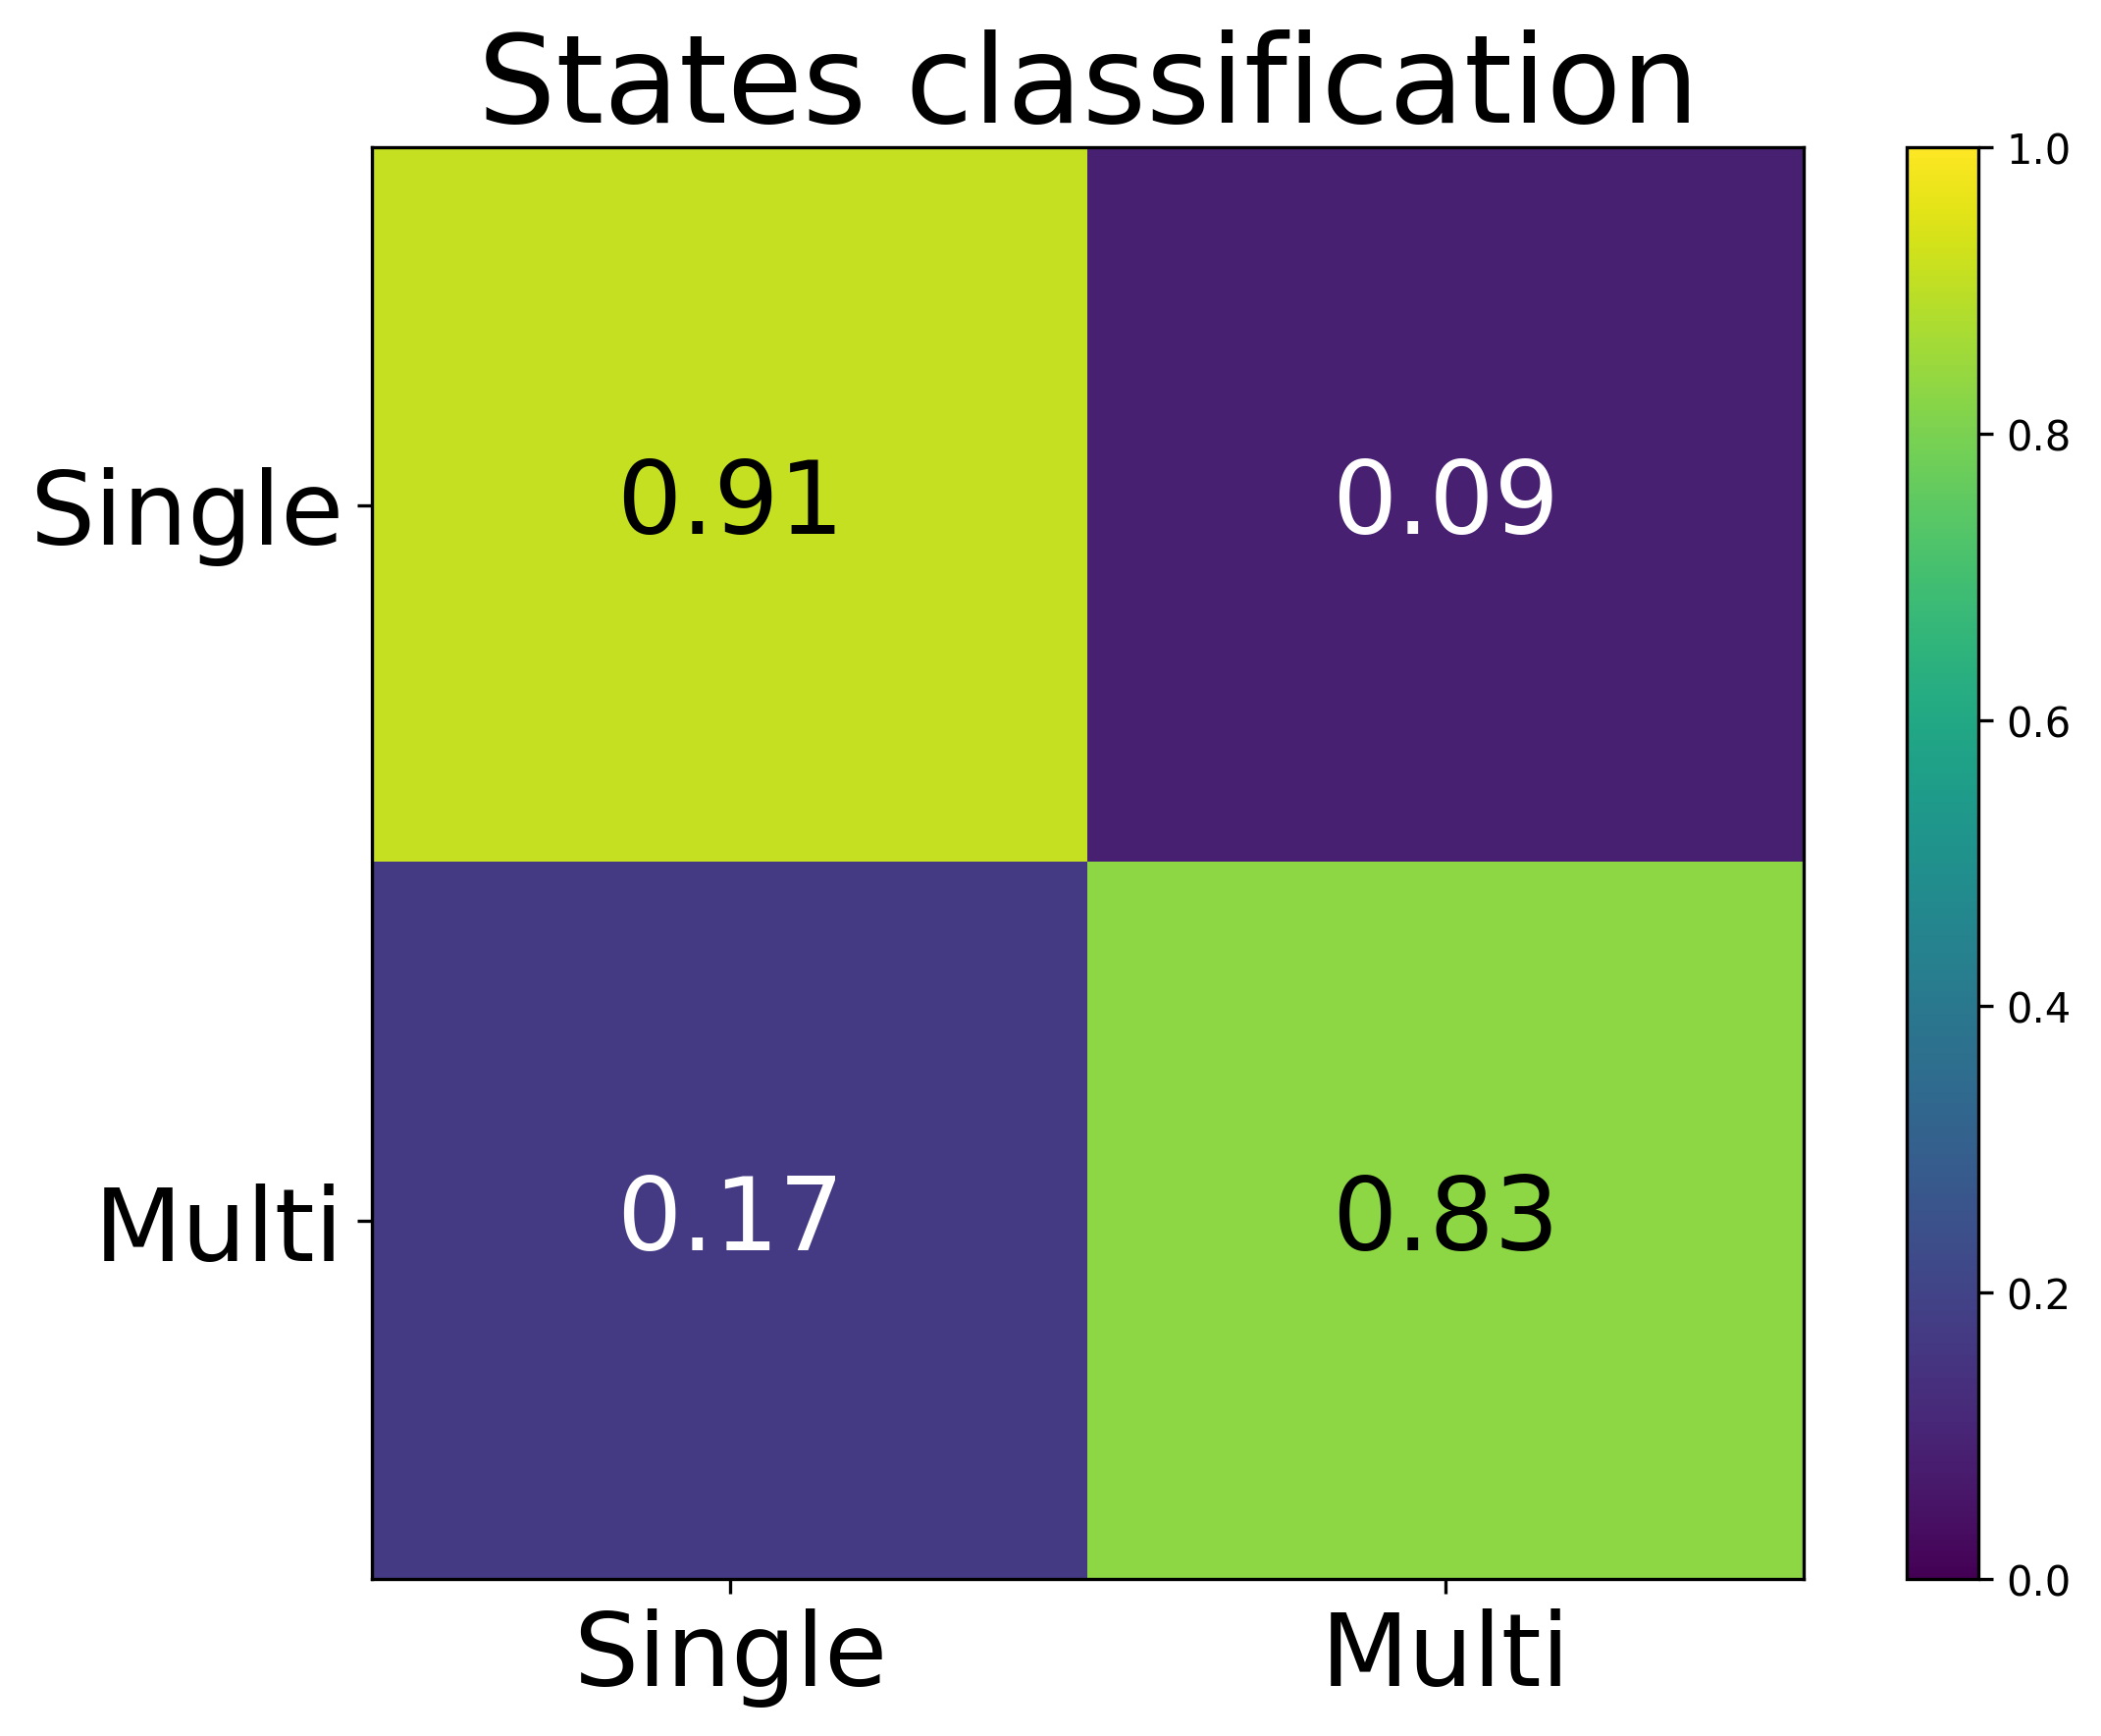

In [735]:
import numpy as np
import matplotlib.pyplot as plt

# 주어진 혼동 행렬
cm = diffusion_matrix

# 클래스 레이블
class_names = ['single', 'multi']

# figure 설정
plt.figure(figsize=(8, 6), dpi=300, facecolor='white', edgecolor='black', frameon=True)

# 혼동 행렬 시각화
plt.imshow(cm, interpolation='nearest',cmap='viridis')
plt.title('States classification', fontsize = 30)
plt.colorbar()

# 축 레이블 설정
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, fontsize=14)
plt.yticks(tick_marks, class_names, fontsize=14)

plt.clim(0,1)
for i, j in np.ndindex(cm.shape):
    
    if i == j:
        plt.text(j, i, f'{cm[i, j]:.2f}', 
                 ha='center', va='center', 
                 fontsize=25, 
                 color='black')
        
    else:
        plt.text(j, i, f'{cm[i, j]:.2f}', 
                 ha='center', va='center', 
                 fontsize=25, 
                 color='white')
        

plt.yticks(np.arange(2),['Single','Multi'],fontsize = 25)
plt.xticks(np.arange(2),['Single','Multi'],fontsize = 25)
# plt.ylabel('True label', fontsize=14)
# plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

T = 20, mean_jsc = 0.8486641161105628
T = 20, std_jsc = 0.23484583434470988
T = 80, mean_jsc = 0.8365488855482817
T = 80, std_jsc = 0.24231492558940307
T = 140, mean_jsc = 0.8420883821270734
T = 140, std_jsc = 0.23753172774812853
-------------------------------
T = 20, max_loss = 6.25
T = 20, mean_loss = 1.603601202284599
T = 20, std_loss = 1.5086719301987583
T = 80, max_loss = 6.0
T = 80, mean_loss = 1.469003300753964
T = 80, std_loss = 1.3720091519333095
T = 140, max_loss = 6.0
T = 140, mean_loss = 1.2975185414464103
T = 140, std_loss = 1.2719960736098497


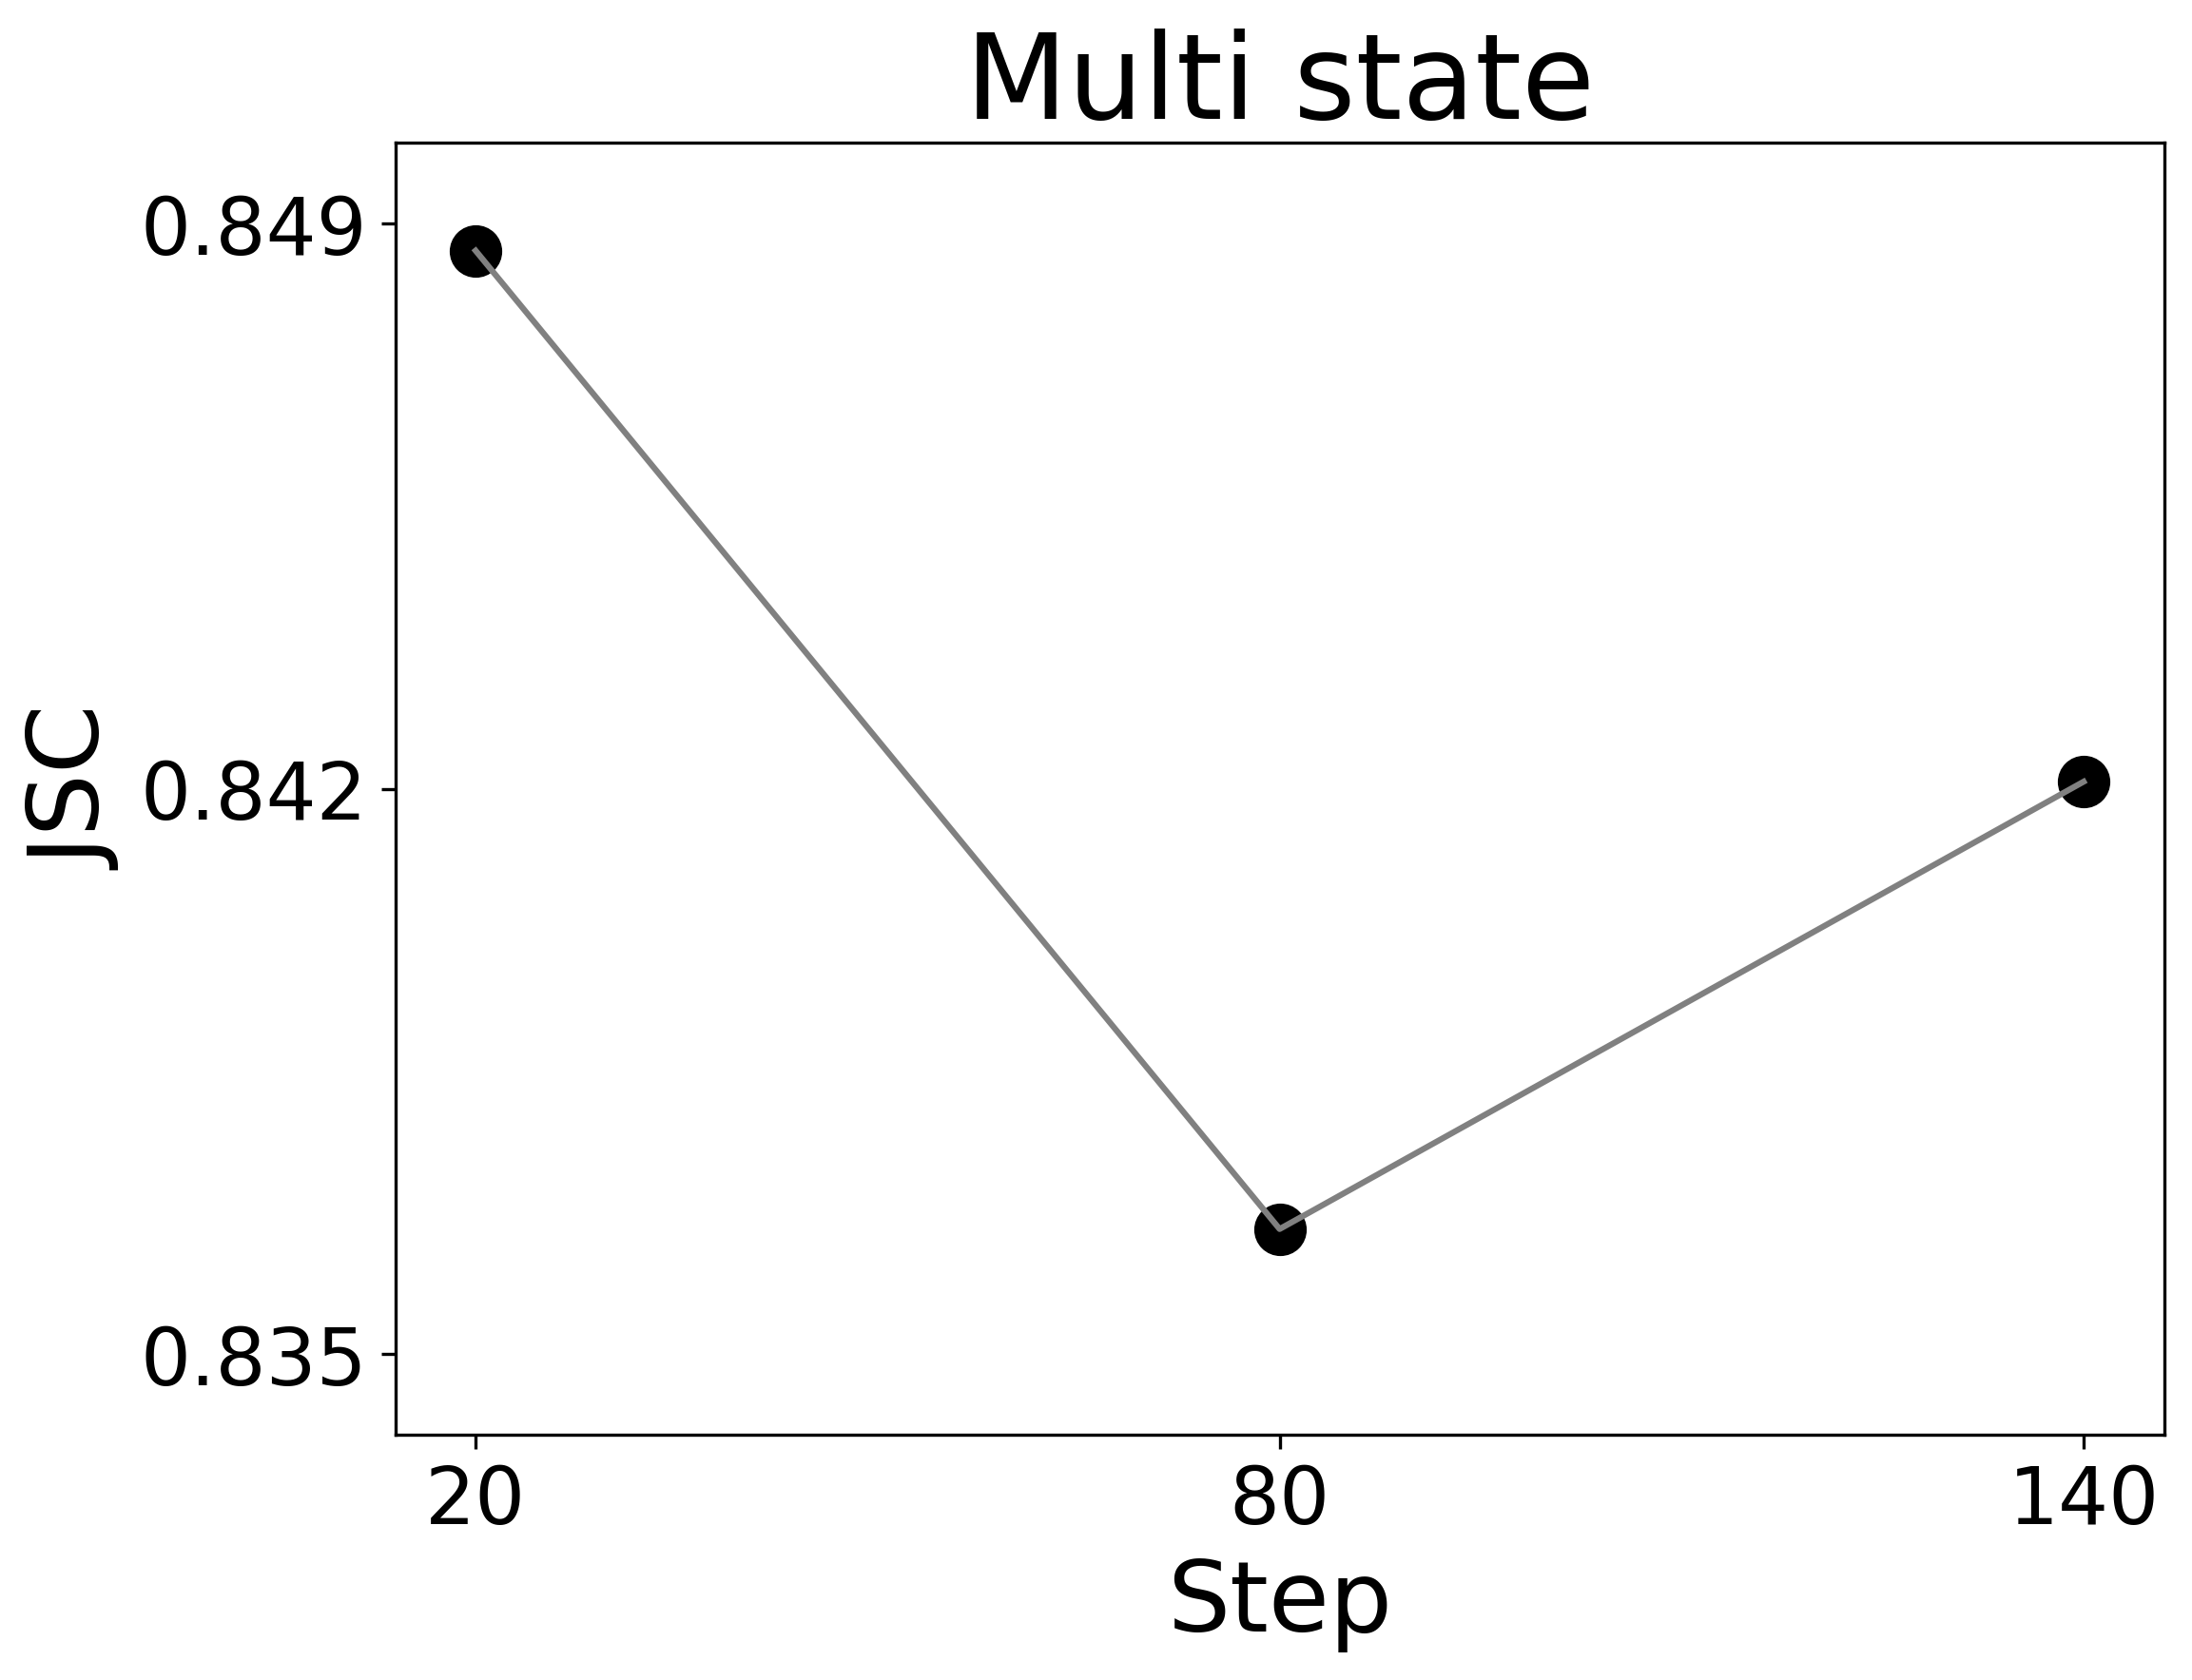

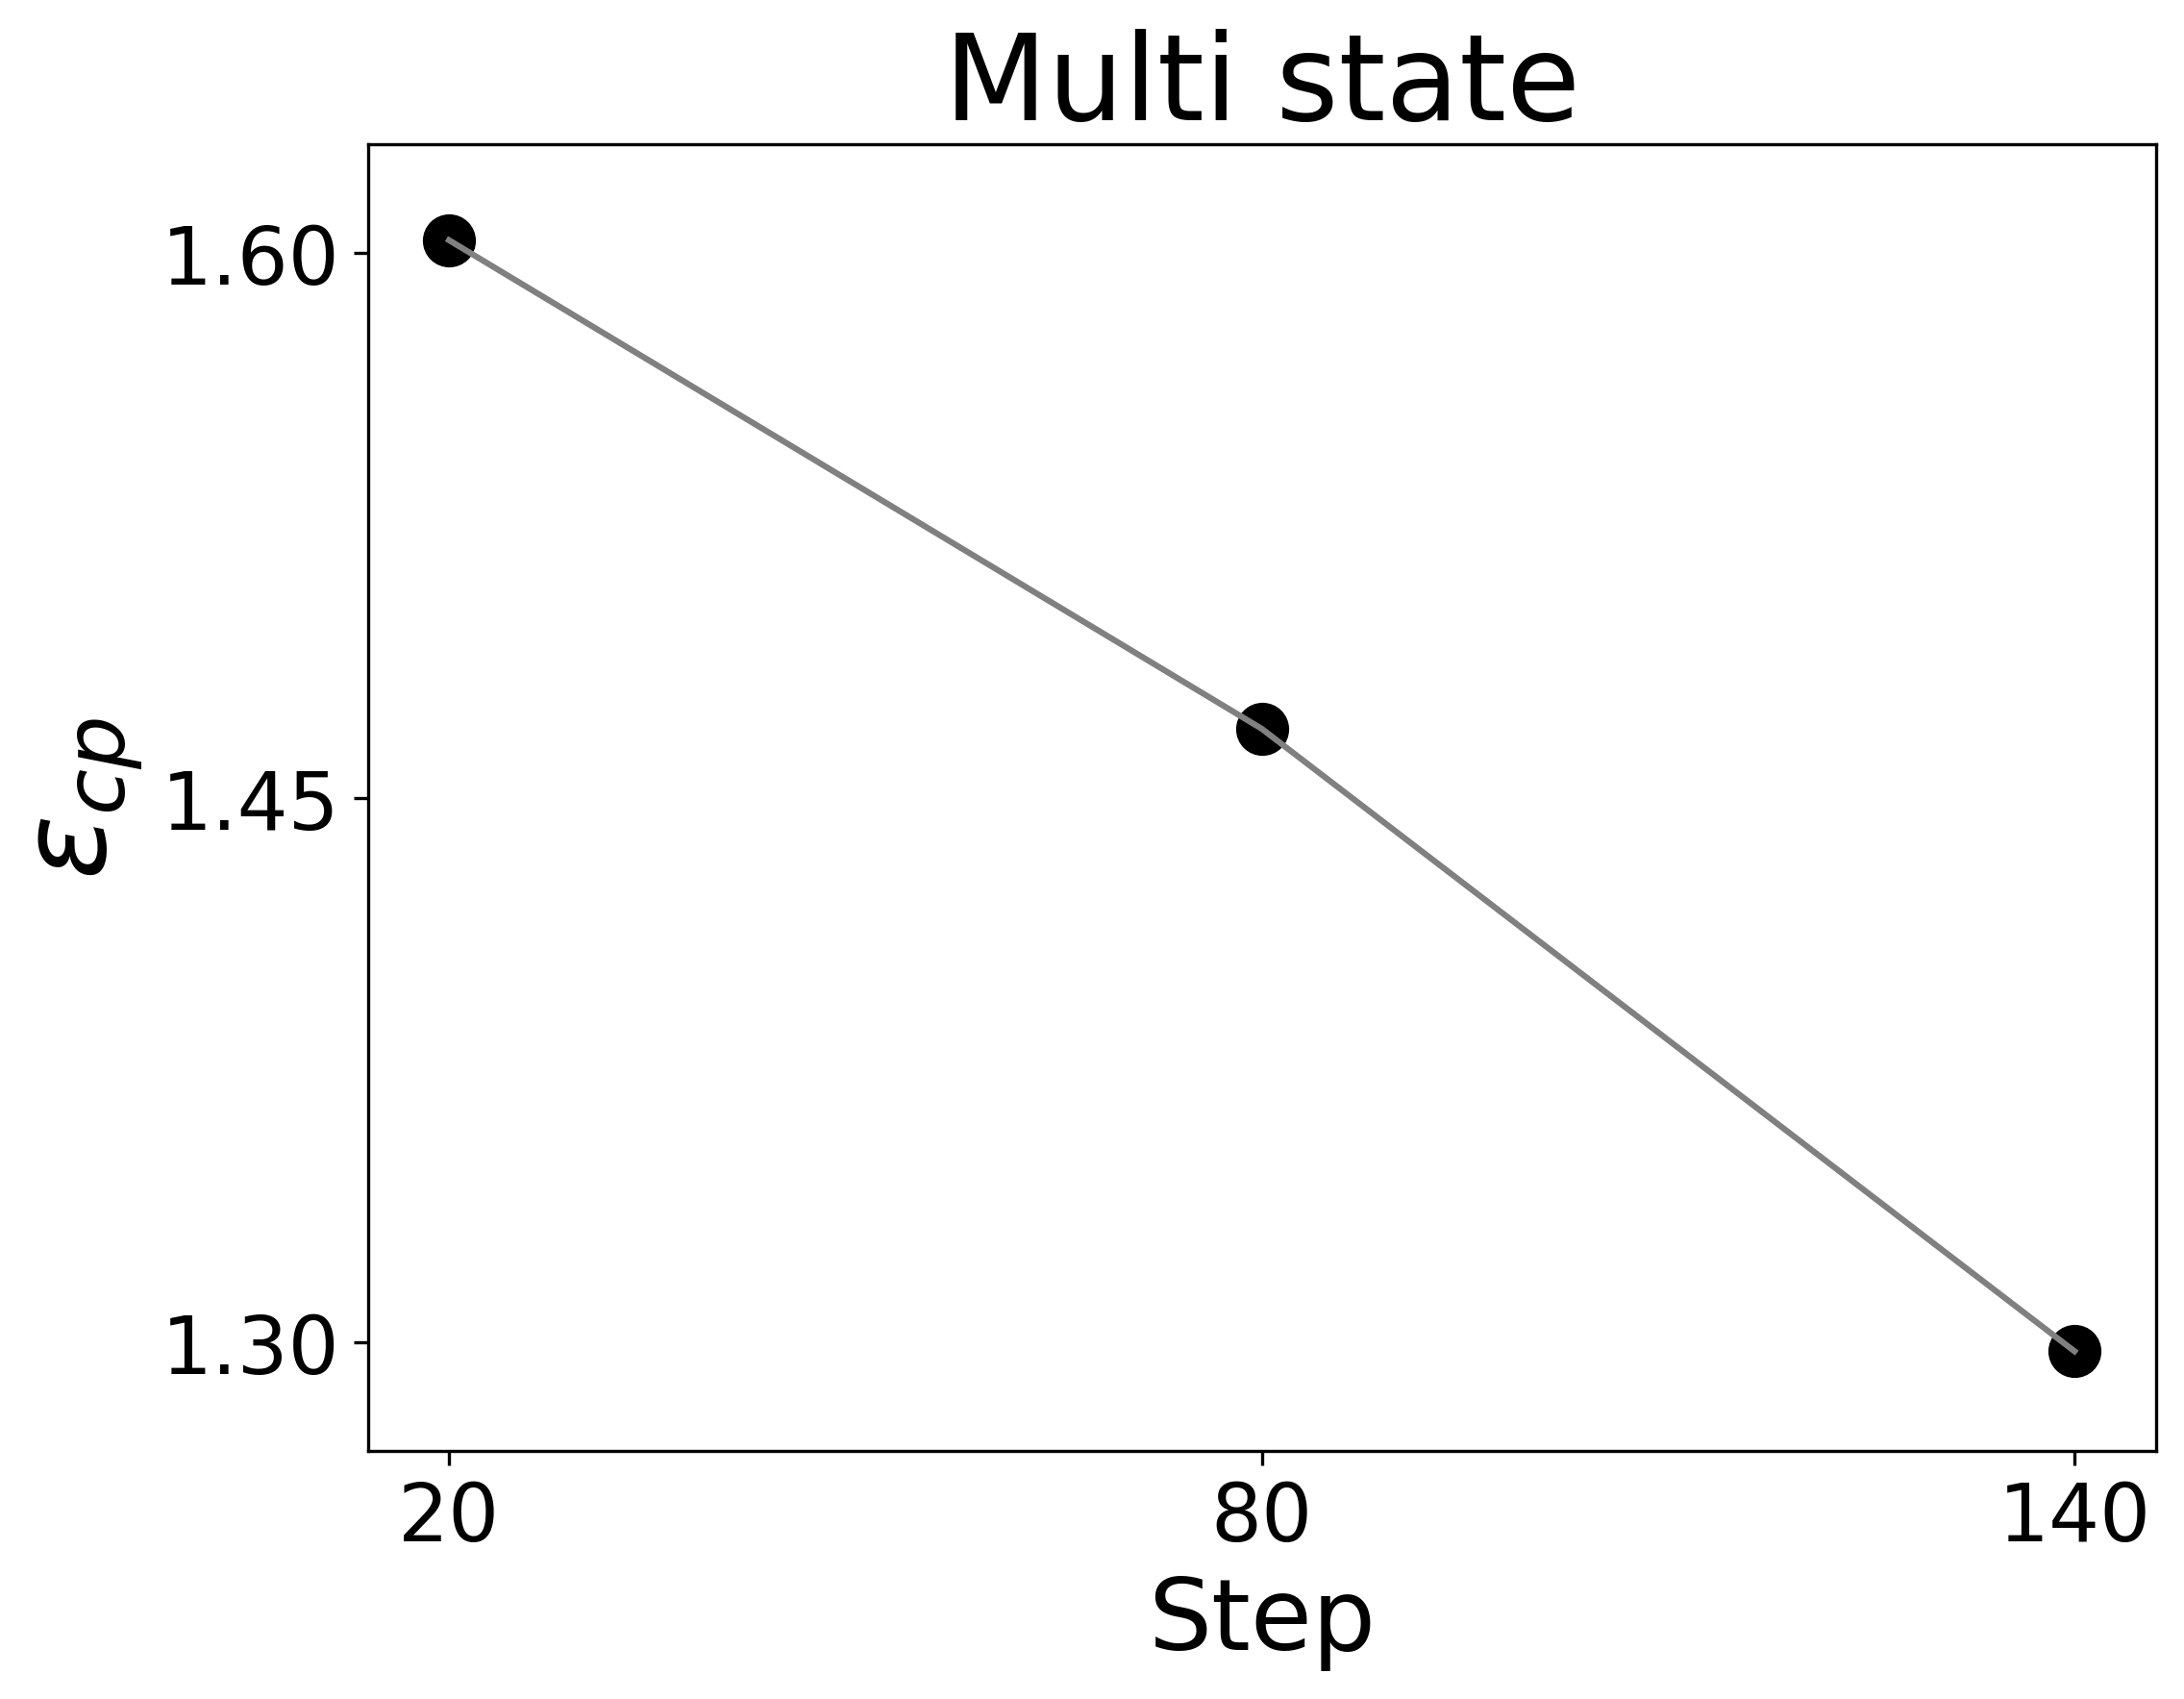

In [736]:
# 멀티에 대한 JSC 분포와 LOSS_CP (epsilon_cp) 분포

# example cpd_two side
# 1. Trajectory length


dynamic_feature1 = 'alpha'
dynamic_feature2 = 'k'

T = 200
end_index = 3

detection_performance = {'20': [[],[]], '80': [[],[]], '140': [[],[]]}

Th_alpha = 0.04
Th_k = 0.10
epsilon_cp = 9
for n in range(48000):

    predicted_alpha = multi_pred['alpha'][n]
    predicted_k = multi_pred['k'][n]
    
    
    true_cp = cp_multi[n]
    
    T_length = length_multi[n]
    
    if 20 <= T_length <= 80:

        true_cp = cp_multi[n]


        both_based_pred_cp = cpd_v1_two_side(predicted_alpha,predicted_k,T_length,Th_alpha,Th_k,end_index)

        jsc = jaccard_similarity_with_tolerance([both_based_pred_cp], [true_cp], epsilon_cp)[0]
        loss = jaccard_similarity_with_tolerance([both_based_pred_cp], [true_cp], epsilon_cp)[1]

        detection_performance['20'][0].append(jsc)
        detection_performance['20'][1].append(loss)

    
    elif 80 <= T_length <= 140:

        true_cp = cp_multi[n]


        both_based_pred_cp = cpd_v1_two_side(predicted_alpha,predicted_k,T_length,Th_alpha,Th_k,end_index)

        jsc = jaccard_similarity_with_tolerance([both_based_pred_cp], [true_cp], epsilon_cp)[0]
        loss = jaccard_similarity_with_tolerance([both_based_pred_cp], [true_cp], epsilon_cp)[1]

        detection_performance['80'][0].append(jsc)
        detection_performance['80'][1].append(loss)
        
    elif 140 <= T_length <= 200:

        true_cp = cp_multi[n]


        both_based_pred_cp = cpd_v1_two_side(predicted_alpha,predicted_k,T_length,Th_alpha,Th_k,end_index)

        jsc = jaccard_similarity_with_tolerance([both_based_pred_cp], [true_cp], epsilon_cp)[0]
        loss = jaccard_similarity_with_tolerance([both_based_pred_cp], [true_cp], epsilon_cp)[1]

        detection_performance['140'][0].append(jsc)
        detection_performance['140'][1].append(loss)
        
        
for T in [20,80,140]:
    print('T = {}, mean_jsc = {}'.format(T,np.mean(detection_performance['{}'.format(T)][0])))
    print('T = {}, std_jsc = {}'.format(T,np.std(detection_performance['{}'.format(T)][0])))

    
print('-------------------------------')
for T in [20,80,140]:
    print('T = {}, max_loss = {}'.format(T,np.max(detection_performance['{}'.format(T)][1])))
    print('T = {}, mean_loss = {}'.format(T,np.mean(detection_performance['{}'.format(T)][1])))
    print('T = {}, std_loss = {}'.format(T,np.std(detection_performance['{}'.format(T)][1])))
    
    
mean_jsc = []
std_jsc = []

for T in [20,80,140]:
    mean_jsc.append(np.mean(detection_performance['{}'.format(T)][0]))
    std_jsc.append(np.std(detection_performance['{}'.format(T)][0]))
    

mean_loss = []
std_loss = []

for T in [20,80,140]:
    mean_loss.append(np.mean(detection_performance['{}'.format(T)][1]))
    std_loss.append(np.std(detection_performance['{}'.format(T)][1]))
    
    
# plt.ylim([0.3,1])

plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)
    



# plt.errorbar([1,2,3], mean_jsc, yerr = std_jsc, c = 'gray')
# color = ['r', 'g', 'b']

for n in range(3):
    plt.scatter(x = n+1, y = mean_jsc[n], s = 150, c = 'black')


plt.plot([1,2,3], mean_jsc, c = 'gray')

plt.xticks([1,2,3], [20,80,140], fontsize = 20)
plt.yticks([0.835,0.842,0.849], fontsize = 20)

plt.xlabel('Step', fontsize = 25)
plt.ylabel('JSC', fontsize = 25)
plt.ylim([0.834,0.850])
plt.title('Multi state', fontsize = 30)
plt.show()


plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)
    
plt.plot([1,2,3], mean_loss, c = 'gray')

# plt.errorbar([1,2,3], mean_loss, yerr = std_loss, c = 'gray')
# color = ['r', 'g', 'b']

for n in range(3):
    plt.scatter(x = n+1, y = mean_loss[n], s = 150, c = 'black')


plt.xticks([1,2,3], [20,80,140], fontsize = 20)
plt.yticks([1.30,1.45,1.6], fontsize = 20)
plt.ylim([1.27,1.63])

plt.xlabel('Step', fontsize = 25)
plt.ylabel(r"$\epsilon_{cp}$", fontsize = 30)
plt.title('Multi state', fontsize = 30)
plt.show()

In [737]:
len(detection_performance['20'][0]) + len(detection_performance['80'][0]) + len(detection_performance['140'][0])

48000

In [738]:
multi_true['alpha'][0].max()

1.746462017398261

In [739]:
k = []

for n in range(48000):


    predicted_k = multi_pred['k'][n]
    k.append(np.max(predicted_k))
    
print(max(k))

9.138879776000977


In [740]:
# 멀티에 대한 JSC 분포와 LOSS_CP (epsilon_cp) 분포

# example cpd_two side
# 2. diffusion preperties


dynamic_feature1 = 'alpha'
dynamic_feature2 = 'k'

T = 200
end_index = 3

# 0: a<=1, 1. a > 1

detection_performance = {'0': [[],[]], '1': [[],[]]}

Th_alpha = 0.05
Th_k = 0.14
epsilon_cp = 9
for n in range(48000):

    predicted_alpha = multi_pred['alpha'][n]
    predicted_k = multi_pred['k'][n]*1
    
    true_cp = cp_multi[n]
    
    T_length = length_multi[n]
    
#     T_length = length_multi[n]
    true_alpha = multi_true['alpha'][n]
    true_k = multi_true['k'][n]*1
    
    if true_alpha.max() <= 1:

    


        both_based_pred_cp = cpd_v1_two_side(predicted_alpha,predicted_k,T_length,Th_alpha,Th_k,end_index)

        jsc = jaccard_similarity_with_tolerance([both_based_pred_cp], [true_cp], epsilon_cp)[0]
        loss = jaccard_similarity_with_tolerance([both_based_pred_cp], [true_cp], epsilon_cp)[1]

        detection_performance['0'][0].append(jsc)
        detection_performance['0'][1].append(loss)

    
    elif true_alpha.max() > 1:

  


        both_based_pred_cp = cpd_v1_two_side(predicted_alpha,predicted_k,T_length,Th_alpha,Th_k,end_index)

        jsc = jaccard_similarity_with_tolerance([both_based_pred_cp], [true_cp], epsilon_cp)[0]
        loss = jaccard_similarity_with_tolerance([both_based_pred_cp], [true_cp], epsilon_cp)[1]

        detection_performance['1'][0].append(jsc)
        detection_performance['1'][1].append(loss)
        



In [741]:
print(len(detection_performance['0'][0]))
print(len(detection_performance['1'][0]))

11770
36230


In [742]:
index = []
loss_zip = []
for n in range(48000):

    predicted_alpha = multi_pred['alpha'][n]
    predicted_k = multi_pred['k'][n]
    true_cp = cp_multi[n]
    
    T_length = length_multi[n]

    
    true_alpha = multi_true['alpha'][n]
    true_k = multi_true['k'][n]

    both_based_pred_cp = cpd_v1_two_side(predicted_alpha,predicted_k,T_length,Th_alpha,Th_k,end_index)

    loss = jaccard_similarity_with_tolerance([both_based_pred_cp], [true_cp], epsilon_cp)[1]
    
#     if np.isnan(loss) == 0:
#         index.append(n)

    loss_zip.append(loss)

#     print(both_based_pred_cp)
#     print(true_cp)
#     print(loss)

In [743]:
# for n in range(48000):
#     if np.isnan(loss_zip)[n] == True:
#         print(n)
        
(np.isnan(loss_zip)).any()

False

T = 0, mean_jsc = 0.8371181413970924
T = 0, std_jsc = 0.25305998141450653
T = 1, mean_jsc = 0.8280194435136417
T = 1, std_jsc = 0.24893100702866408
-------------------------------
T = 0, max_loss = 5.666666666666667
T = 0, mean_loss = 1.182488738005609
T = 0, std_loss = 1.2734425811412584
T = 1, max_loss = 6.25
T = 1, mean_loss = 1.295989917766992
T = 1, std_loss = 1.3369924237308666


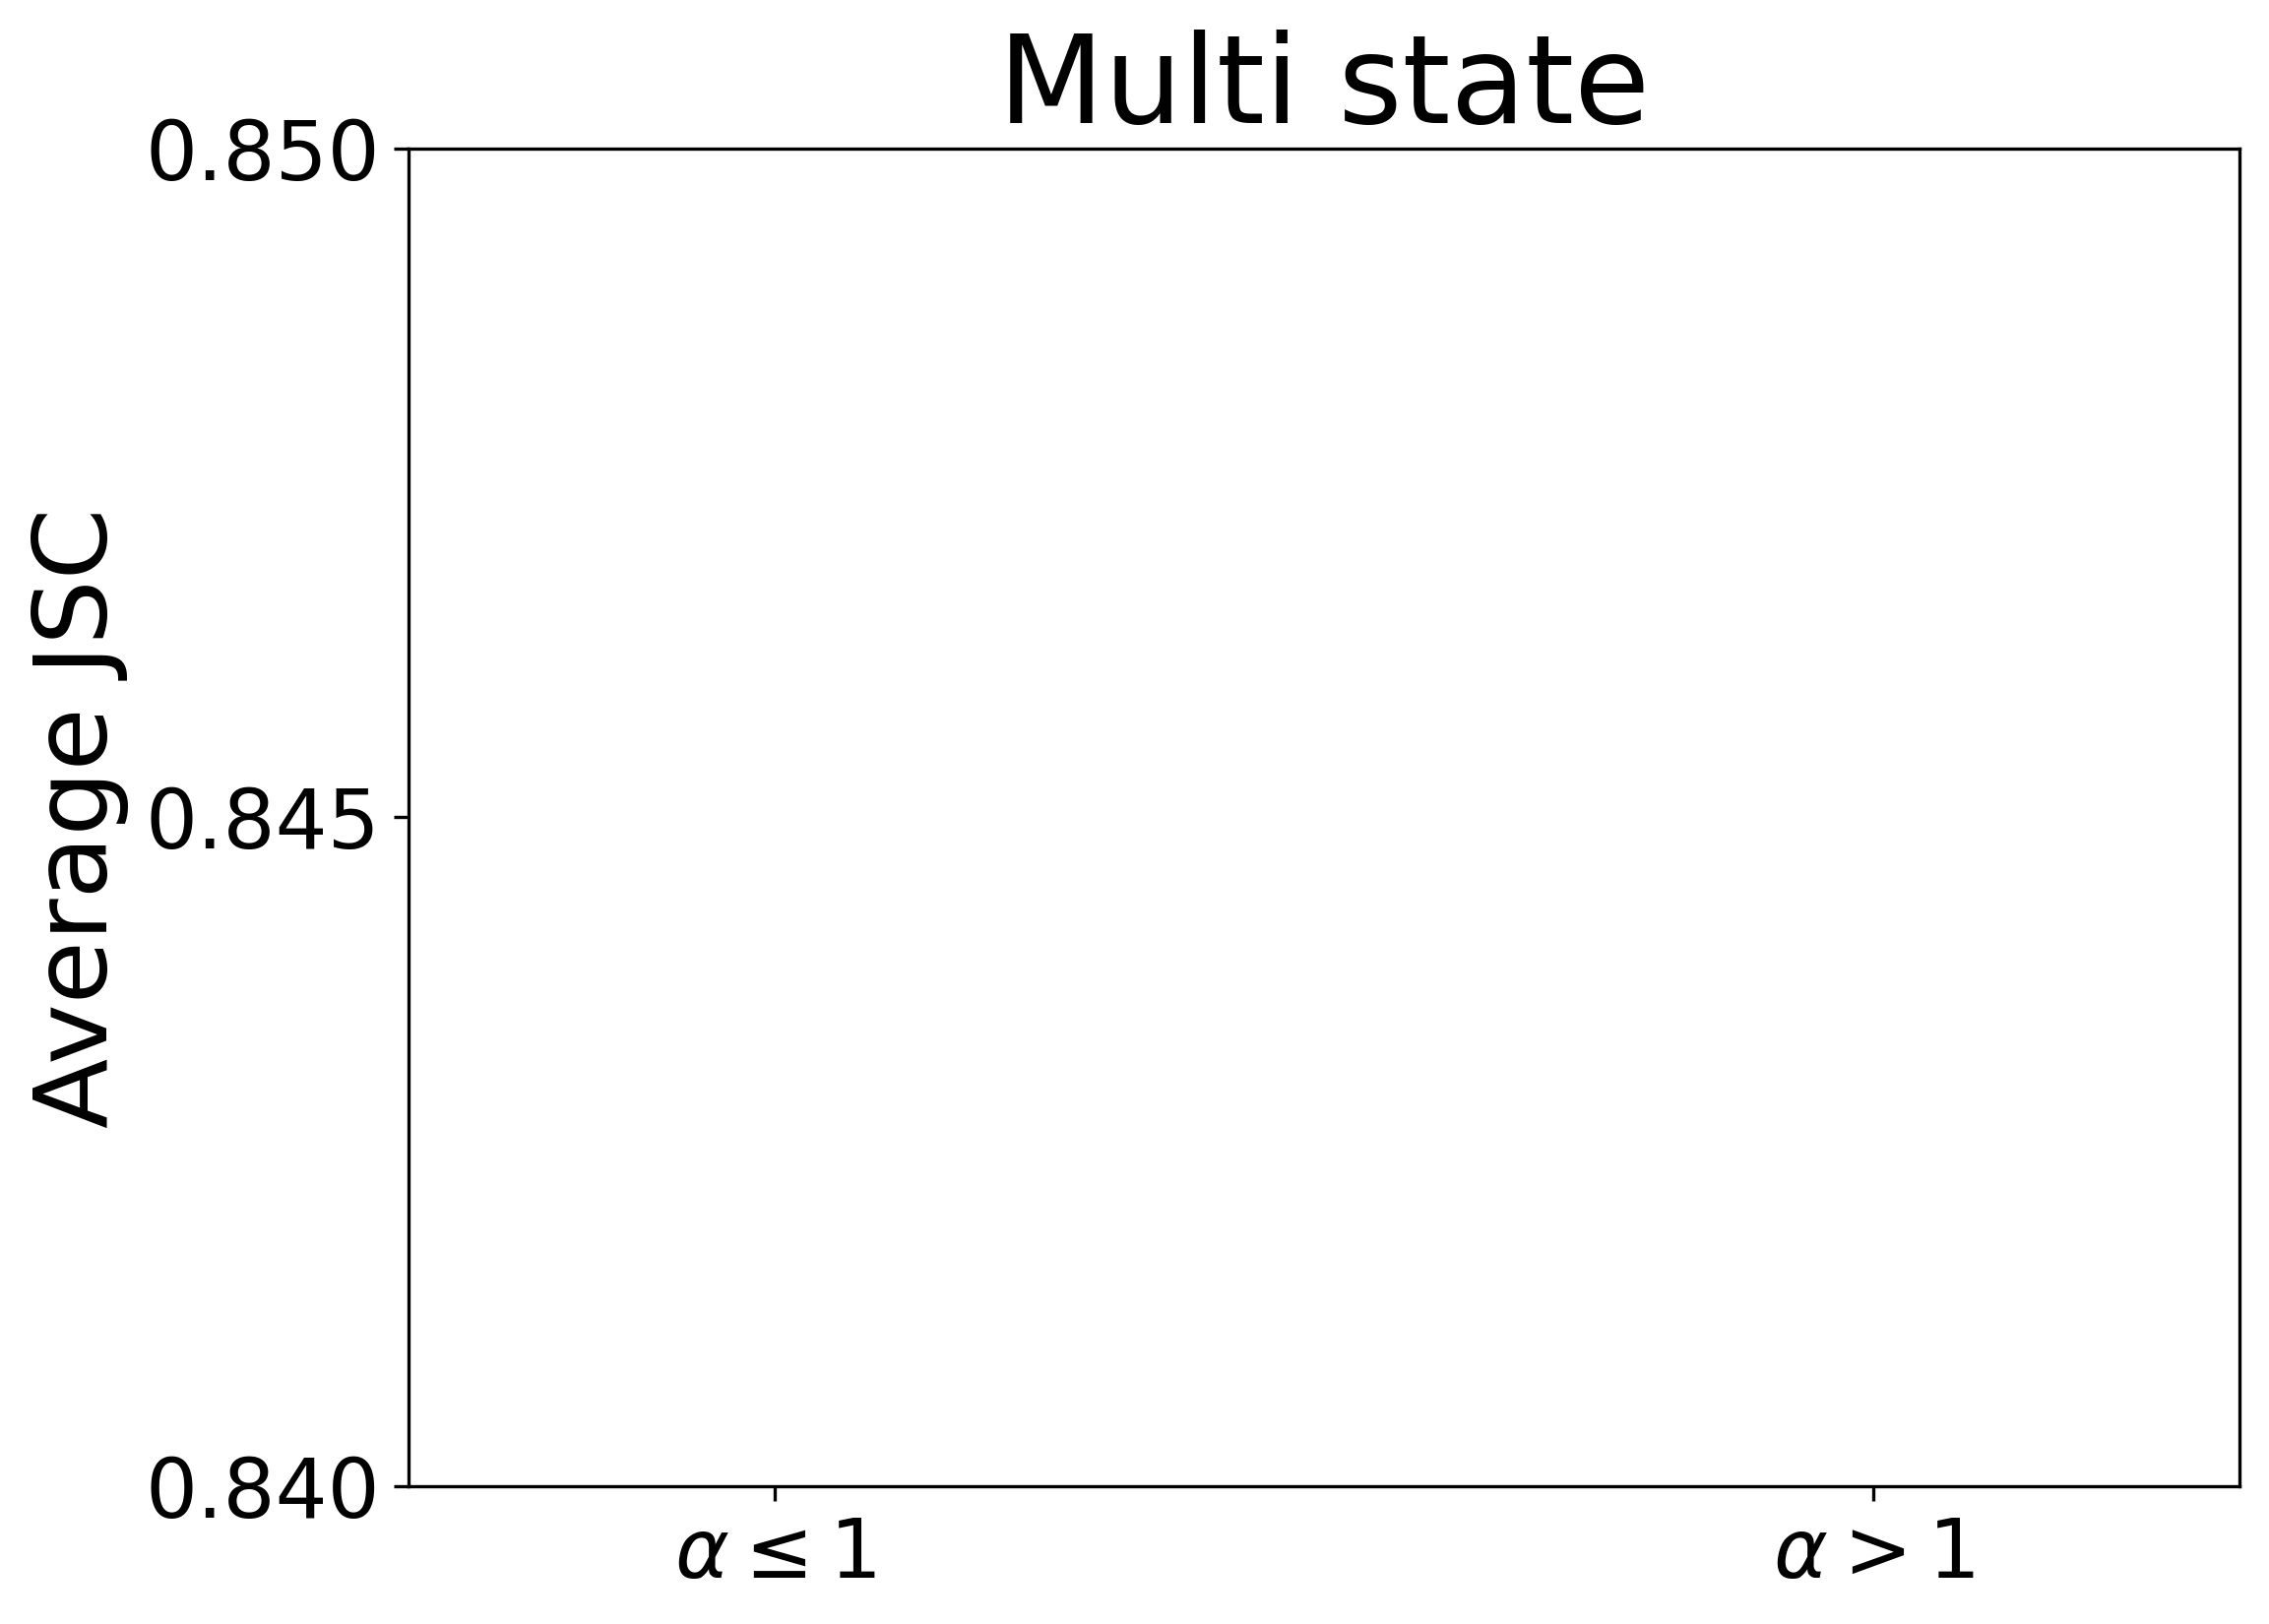

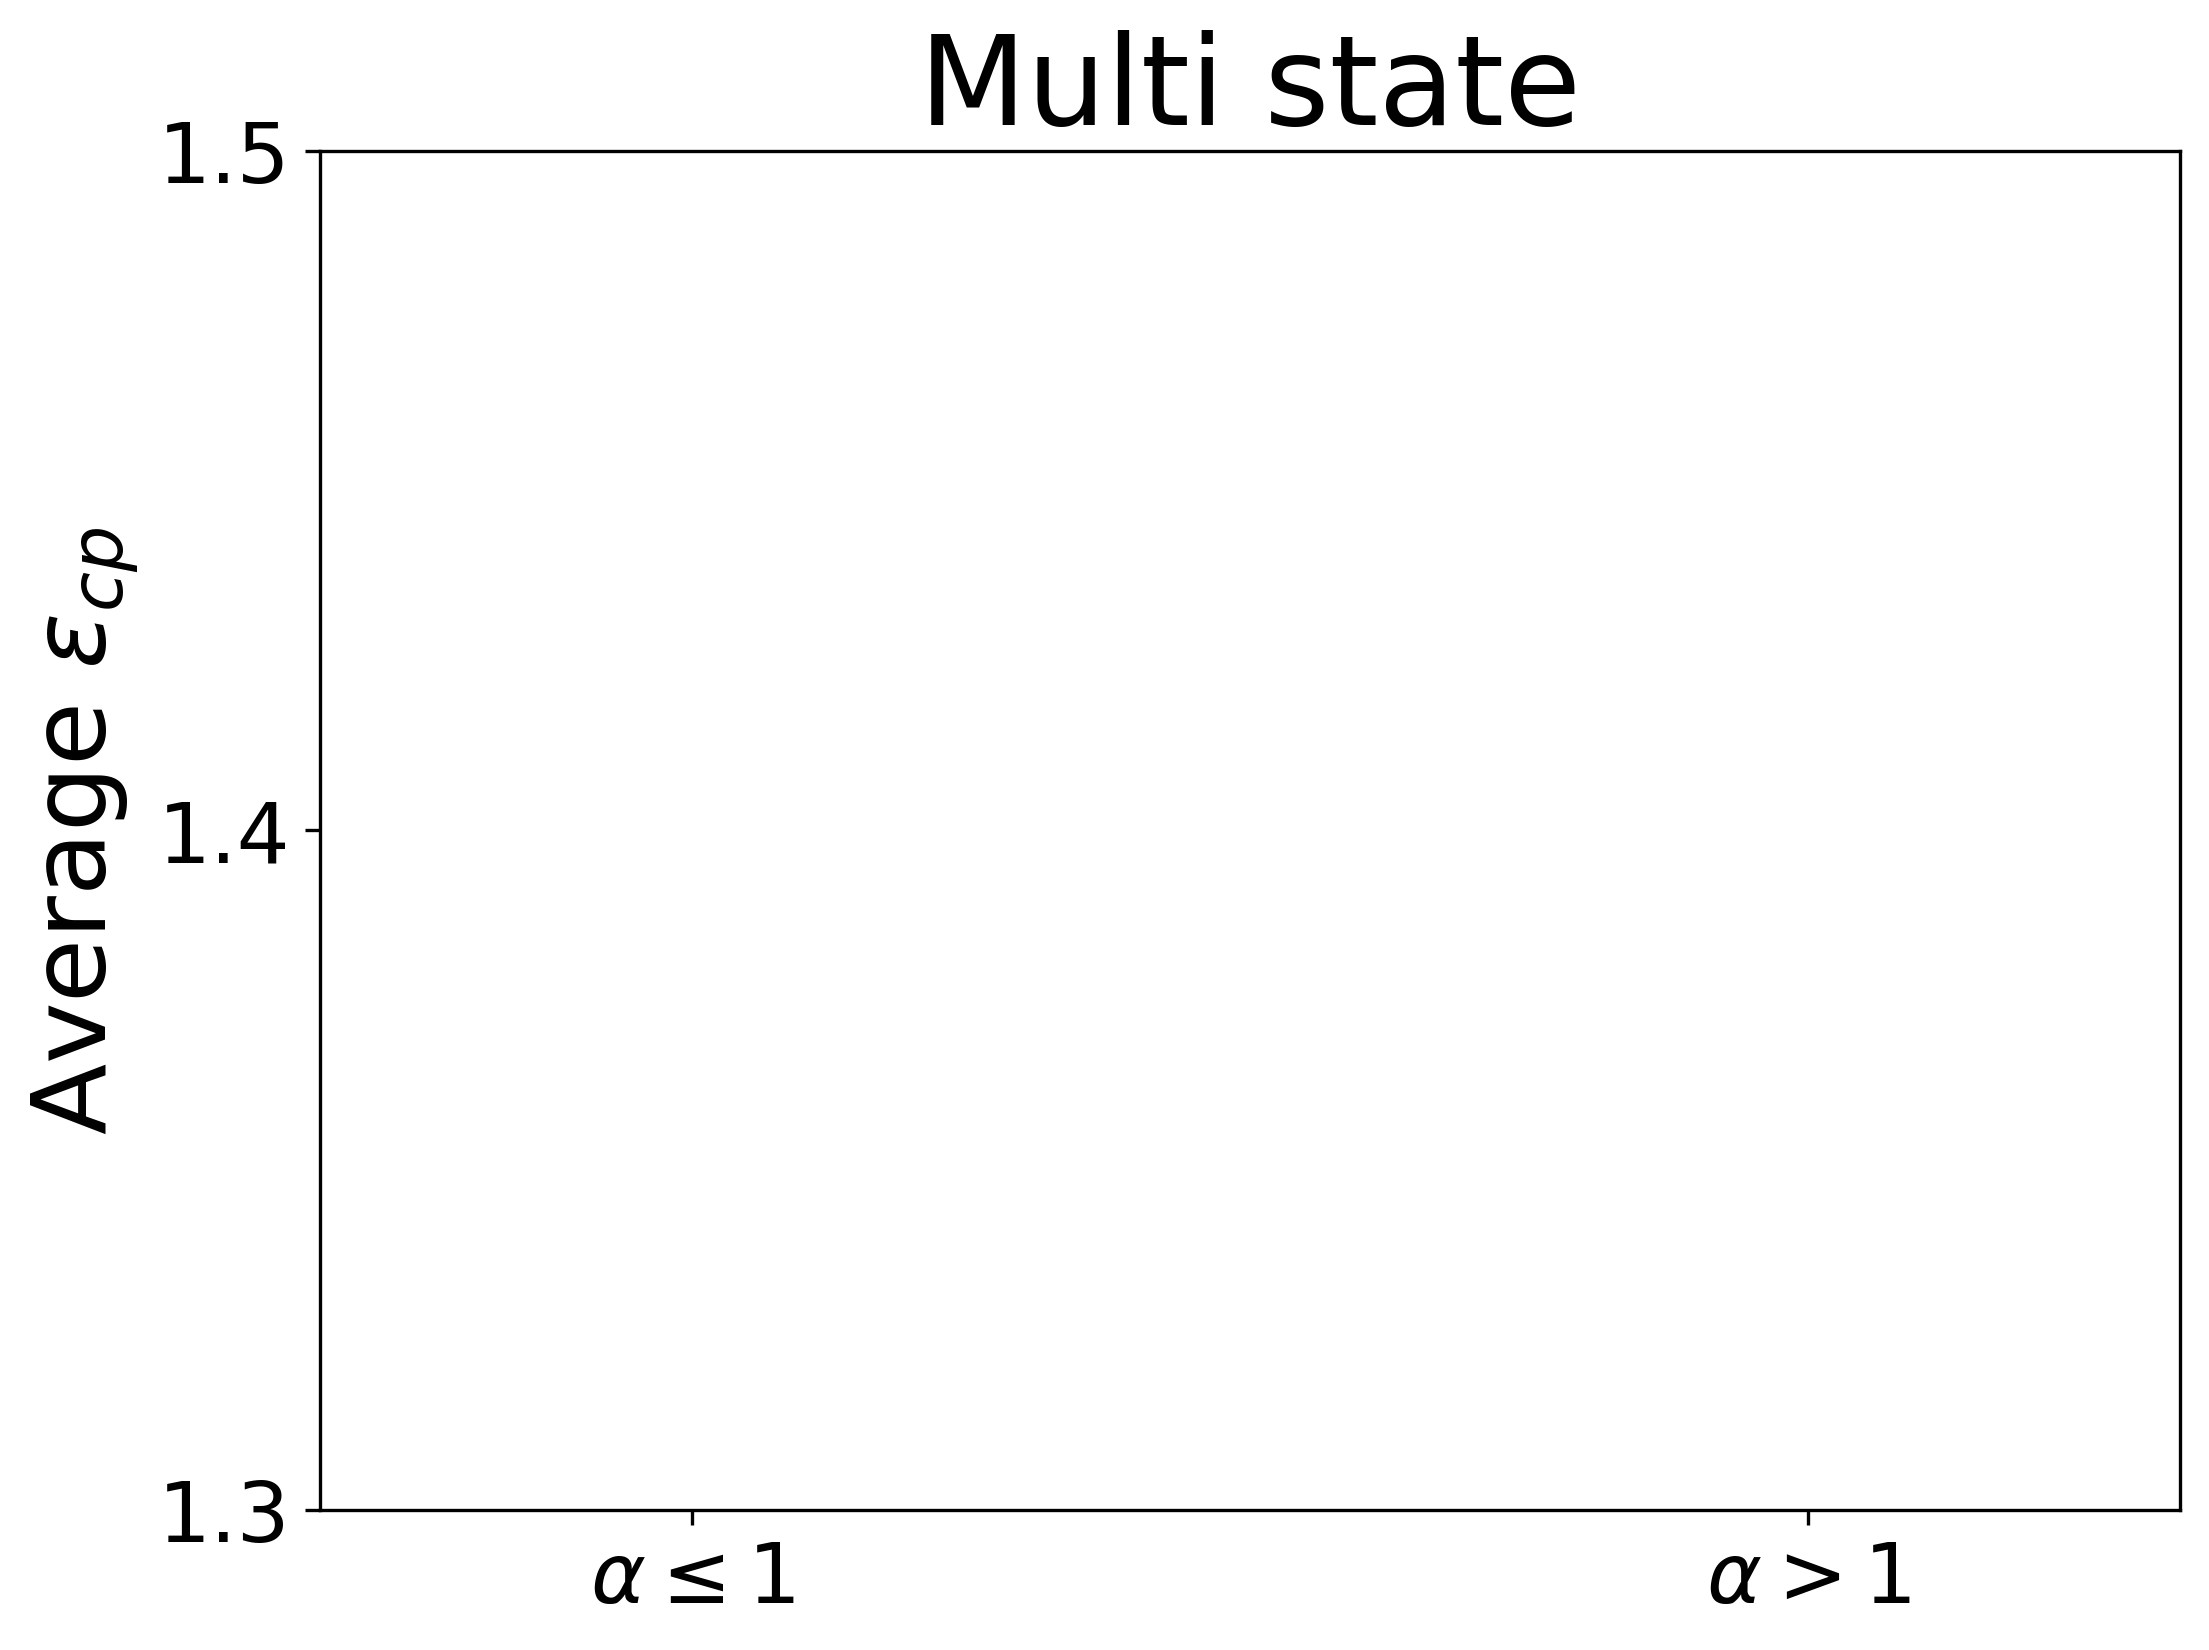

In [744]:
for T in [0,1]:
    print('T = {}, mean_jsc = {}'.format(T,np.mean(detection_performance['{}'.format(T)][0])))
    print('T = {}, std_jsc = {}'.format(T,np.std(detection_performance['{}'.format(T)][0])))

    
print('-------------------------------')
for T in [0,1]:
    print('T = {}, max_loss = {}'.format(T,np.max(detection_performance['{}'.format(T)][1])))
    print('T = {}, mean_loss = {}'.format(T,np.mean(detection_performance['{}'.format(T)][1])))
    print('T = {}, std_loss = {}'.format(T,np.std(detection_performance['{}'.format(T)][1])))
    

mean_jsc = []
std_jsc = []

for T in [0,1]:
    mean_jsc.append(np.mean(detection_performance['{}'.format(T)][0]))
    std_jsc.append(np.std(detection_performance['{}'.format(T)][0]))
    

mean_loss = []
std_loss = []

for T in [0,1]:
    mean_loss.append(np.mean(detection_performance['{}'.format(T)][1]))
    std_loss.append(np.std(detection_performance['{}'.format(T)][1]))
    
    
# plt.ylim([0.3,1])

plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)
    



# plt.errorbar([1,2,3], mean_jsc, yerr = std_jsc, c = 'gray')
# color = ['r', 'g', 'b']
xs = [1.2,1.8]
for n in range(2):
    plt.scatter(x = xs[n], y = mean_jsc[n], s = 150, c = 'black')


plt.plot([1.2,1.8], mean_jsc, c = 'gray')

plt.xticks([1.2,1.8],[r'$\alpha \leq 1$', r'$\alpha > 1$'], fontsize = 20)
plt.yticks([0.840,0.845,0.850], fontsize = 20)

# plt.xlabel(, fontsize = 25)
plt.ylabel('Average JSC', fontsize = 25)
plt.ylim([0.84,0.85])
plt.xlim([1,2])
plt.title('Multi state', fontsize = 30)
plt.show()


plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)
    
plt.plot([1.2,1.8], mean_loss, c = 'gray')

# plt.errorbar([1,2,3], mean_loss, yerr = std_loss, c = 'gray')
# color = ['r', 'g', 'b']

for n in range(2):
    plt.scatter(x = xs[n], y = mean_loss[n], s = 150, c = 'black')

plt.xticks([1.2,1.8],[r'$\alpha \leq 1$', r'$\alpha > 1$'], fontsize = 20)
plt.yticks([1.30,1.40,1.50], fontsize = 20)
plt.ylim([1.30,1.50])
plt.xlim([1,2])
# plt.xlabel('Step', fontsize = 25)
plt.ylabel('Average' + ' ' + r"$\epsilon_{cp}$", fontsize = 25)
plt.title('Multi state', fontsize = 30)
plt.show()

In [745]:
len(length_data['single'][2])

12000

In [746]:
single_pred = {}

single_pred['alpha'] = pred_test['alpha']['single']
single_pred['k'] = pred_test['k']['single']

In [747]:
pred_data = {}
pred_data['single'] = single_pred
pred_data['multi'] = multi_pred

In [748]:
print(pred_data['multi']['k'].shape)

(48000, 200)


In [749]:
single_true = {}

single_true['alpha'] = alpha_data['single'][2]
single_true['k'] = k_data['single'][2]

true_data = {}

true_data['single'] = single_true
true_data['multi'] = multi_true

In [750]:
print(single_true['k'].shape)
print(multi_true['k'].shape)

(12000, 200)
(48000, 200)


In [751]:
print(true_data['multi']['k'].shape)
print(true_data['multi']['alpha'].shape)

(48000, 200)
(48000, 200)


In [752]:
length_data['single'][2][8]

49

In [753]:
cp_data['multi'][2][8]

[4, 49, 130, 158]

In [754]:
case = 'single'
n = 800

T = length_data[case][2][n]
cp = cp_data[case][2][n]
k_n = true_data[case]['k'][n]

def data_divide(data, cp):
    divided_data = []
    for cp_index, cp_n in enumerate(cp):
        if cp_index == 0:
            divided_data.append(data[:cp_n])
            
        else:
            divided_data.append(data[cp[cp_index-1]: cp[cp_index]])
    return divided_data

divided_data = data_divide(k_n,cp)

print(np.unique(k_n),'\n')
length = 0
for i in range(len(divided_data)):
    print(divided_data[i])
    length += len(divided_data[i])
print(length == T)

[3.38597246] 

[3.38597246 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246
 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246
 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246
 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246
 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246
 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246
 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246
 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246
 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246
 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246
 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246
 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246
 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246
 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246 3.38597246
 3.38597246 3.38597246 3.38597246 3.38597246 3.

In [755]:
for i in range(1,11):
    print(i)

1
2
3
4
5
6
7
8
9
10


In [756]:

with open('Data/Feature/length_data (200, {})'.format(3), 'rb') as f:
    length_origin = pickle.load(f)
    
with open('Data/Feature/cp_data (200, {})'.format(3), 'rb') as f:
    cp_origin = pickle.load(f)

    
length_multi = []
cp_multi = []
for case in cases[1:]:
    for n in range(len(length_origin[case][2])):
        length_multi.append(length_origin[case][2][n])
        cp_multi.append(cp_origin[case][2][n])


length_data = {}
cp_data = {}

length_data['single'] = length_origin['single'][2]
length_data['multi'] = length_multi

cp_data['single'] = cp_origin['single'][2]
cp_data['multi'] = cp_multi

In [763]:
k = np.zeros((2,8))

for cn,case in enumerate(['single', 'multi']):
    for n in range(len(true_data[case]['k'])):
        T = length_data[case][n]
        cp = cp_data[case][n]
        k_n = true_data[case]['k'][n]
        divided_data = data_divide(k_n,cp)
        
        for i in range(len(divided_data)):
            for index, n in enumerate(range(1,9)):
                if n-1 <= divided_data[i].max() <= n:
                    k[cn,index] += 1
                    break
print(k)

[[ 1776.  2974.  2366.  1790.  1402.  1058.   492.   112.]
 [36978. 34242. 34110. 18197. 13771. 12398.  4840.   885.]]


In [758]:
np.unique(divided_data[i])[0]

0.6850881047107575

In [772]:
k_performance = {}

k_0_performance = {}
for case in ['single', 'multi']:
    mae_case = [[],[],[],[],[],[],[],[]]
    mae_zerocase = []
#     mape_case = [[],[],[],[],[],[],[],[]]
    for n in range(len(true_data[case]['k'])):
        T = length_data[case][n]
        cp = cp_data[case][n]
        k_n = true_data[case]['k'][n]

        pred_k_n = pred_data[case]['k'][n]
        
        divided_true_k = data_divide(k_n,cp)

        
        divided_pred_k = data_divide(pred_k_n,cp)

        for i in range(len(divided_true_k)):
            for kn, k_max in enumerate(range(1,9)):
                k_max = k_max
                
                if np.unique(divided_true_k[i])[0] == 0:
                    mae = np.mean(np.abs(divided_true_k[i] - divided_pred_k[i]))
                    mae_zerocase.append(mae)
                    
                if k_max - 1 < np.unique(divided_true_k[i])[0] <= k_max:
                    mae = np.mean(np.abs(divided_true_k[i] - divided_pred_k[i]))
                    
#                     mape = []
                    
#                     for tn in range(len(divided_true_k[i])):
#                         mape.append((np.abs(divided_true_k[i][tn] - divided_pred_k[i][tn])
#                                      /divided_true_k[i][tn])*100)
                    
                    mae_case[kn].append(mae)
#                     mape_case[kn].append(np.mean(mape))
                    break
#     k_performance[case] = [mae_case, mape_case]
    k_performance[case] = mae_case
    k_0_performance[case] = mae_zerocase

In [773]:
for case in ['single', 'multi']:
    print(np.mean(k_0_performance[case]))

nan
0.2316059244440412


In [761]:
for case in ['single', 'multi']:
    for kn, k_max in enumerate(range(1,9)):
        print('case = {}, kn = {}, dn = {}'.format(case, kn, len(k_performance[case][kn])))

case = single, kn = 0, dn = 1776
case = single, kn = 1, dn = 2974
case = single, kn = 2, dn = 2366
case = single, kn = 3, dn = 1790
case = single, kn = 4, dn = 1402
case = single, kn = 5, dn = 1058
case = single, kn = 6, dn = 492
case = single, kn = 7, dn = 112
case = multi, kn = 0, dn = 36978
case = multi, kn = 1, dn = 34242
case = multi, kn = 2, dn = 34110
case = multi, kn = 3, dn = 18197
case = multi, kn = 4, dn = 13771
case = multi, kn = 5, dn = 12398
case = multi, kn = 6, dn = 4840
case = multi, kn = 7, dn = 885


In [764]:
k

array([[ 1776.,  2974.,  2366.,  1790.,  1402.,  1058.,   492.,   112.],
       [36978., 34242., 34110., 18197., 13771., 12398.,  4840.,   885.]])

In [769]:
alpha_performance = {}
alpha_0_performance = {}
for case in ['single', 'multi']:
    mae_case = [[],[],[],[],[],[],[],[],[],[]]
    
    mae_zerocase = []
#     mape_case = [[],[],[],[],[],[],[],[],[],[]]
    for n in range(len(true_data[case]['alpha'])):
        T = length_data[case][n]
        cp = cp_data[case][n]

        alpha_n = true_data[case]['alpha'][n]
        
        pred_alpha_n = pred_data[case]['alpha'][n]
      
        
        divided_true_alpha = data_divide(alpha_n,cp)

        divided_pred_alpha = data_divide(pred_alpha_n,cp)
        for i in range(len(divided_true_alpha)):
#         for i in range(1):
            for alphan, alpha_max in enumerate(range(1,11)):
                alpha_max = 0.2*alpha_max
            
                if np.unique(divided_true_alpha[i])[0] == 0:
                    np.mean(np.abs(divided_true_alpha[i] - divided_pred_alpha[i]))
                    
                    mae_zerocase.append(mae)
                if alpha_max - 0.2 < np.unique(divided_true_alpha[i])[0] <= alpha_max:
                    mae = np.mean(np.abs(divided_true_alpha[i] - divided_pred_alpha[i]))
                    
#                     mape = []
                    
#                     for tn in range(len(divided_true_alpha[i])):
#                         mape.append((np.abs(divided_true_alpha[i][tn] - divided_pred_alpha[i][tn])
#                                      /divided_true_alpha[i][tn])*100)
                        
                    
                    mae_case[alphan].append(mae)
#                     mape_case[alphan].append(np.mean(mape))
                    break
#     alpha_performance[case] = [mae_case, mape_case]
    alpha_performance[case] = mae_case
    alpha_0_performance[case] = mae_zerocase

In [771]:
for case in ['single', 'multi']:
    print(np.mean(alpha_0_performance[case]))

nan
0.19379889209949686


/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [766]:
alpha_performance[case][1]

[0.25372696893030144,
 0.06072564593242346,
 0.2569840824721576,
 0.028991719978768097,
 0.02904466523778322,
 0.20767644801146137,
 0.2033258640111123,
 0.2423674607002181,
 0.082599694126906,
 0.04569594361940713,
 0.08760246350316014,
 0.1105466610487209,
 0.24350186600235907,
 0.30274155973622846,
 0.03250503461218179,
 0.08492222945233759,
 0.20678646443700788,
 0.06470089805488678,
 0.21130764925999543,
 0.10358467646586214,
 0.22066919407378094,
 0.3071409059920987,
 0.047462232641115557,
 0.32436775677690005,
 0.01886827890481284,
 0.19312993965355557,
 0.06482263059389388,
 0.052857972422001354,
 0.15924039896996087,
 0.705827009421288,
 0.7239598794911343,
 0.250229650809297,
 0.05092662235586347,
 0.20587243776607383,
 0.19827211493687558,
 0.41030908823075213,
 0.04985098593389305,
 0.24939446762095122,
 0.0893117179423869,
 0.09022983598797167,
 0.38312583136154016,
 0.060888468203885215,
 0.19035947073698312,
 0.06937096582446624,
 0.6611117105251251,
 0.15247455383964298

In [768]:
for case in ['single', 'multi']:
    for alphan, alpha_max in enumerate(range(1,11)):
        print('case = {}, alphan = {}, dn = {}'.format(case, alphan, len(alpha_performance[case][alphan])))

case = single, alphan = 0, dn = 1200
case = single, alphan = 1, dn = 1200
case = single, alphan = 2, dn = 1200
case = single, alphan = 3, dn = 1200
case = single, alphan = 4, dn = 1200
case = single, alphan = 5, dn = 1200
case = single, alphan = 6, dn = 1200
case = single, alphan = 7, dn = 1200
case = single, alphan = 8, dn = 1200
case = single, alphan = 9, dn = 1200
case = multi, alphan = 0, dn = 27368
case = multi, alphan = 1, dn = 10215
case = multi, alphan = 2, dn = 12758
case = multi, alphan = 3, dn = 14667
case = multi, alphan = 4, dn = 16556
case = multi, alphan = 5, dn = 17626
case = multi, alphan = 6, dn = 17335
case = multi, alphan = 7, dn = 15333
case = multi, alphan = 8, dn = 13140
case = multi, alphan = 9, dn = 10475


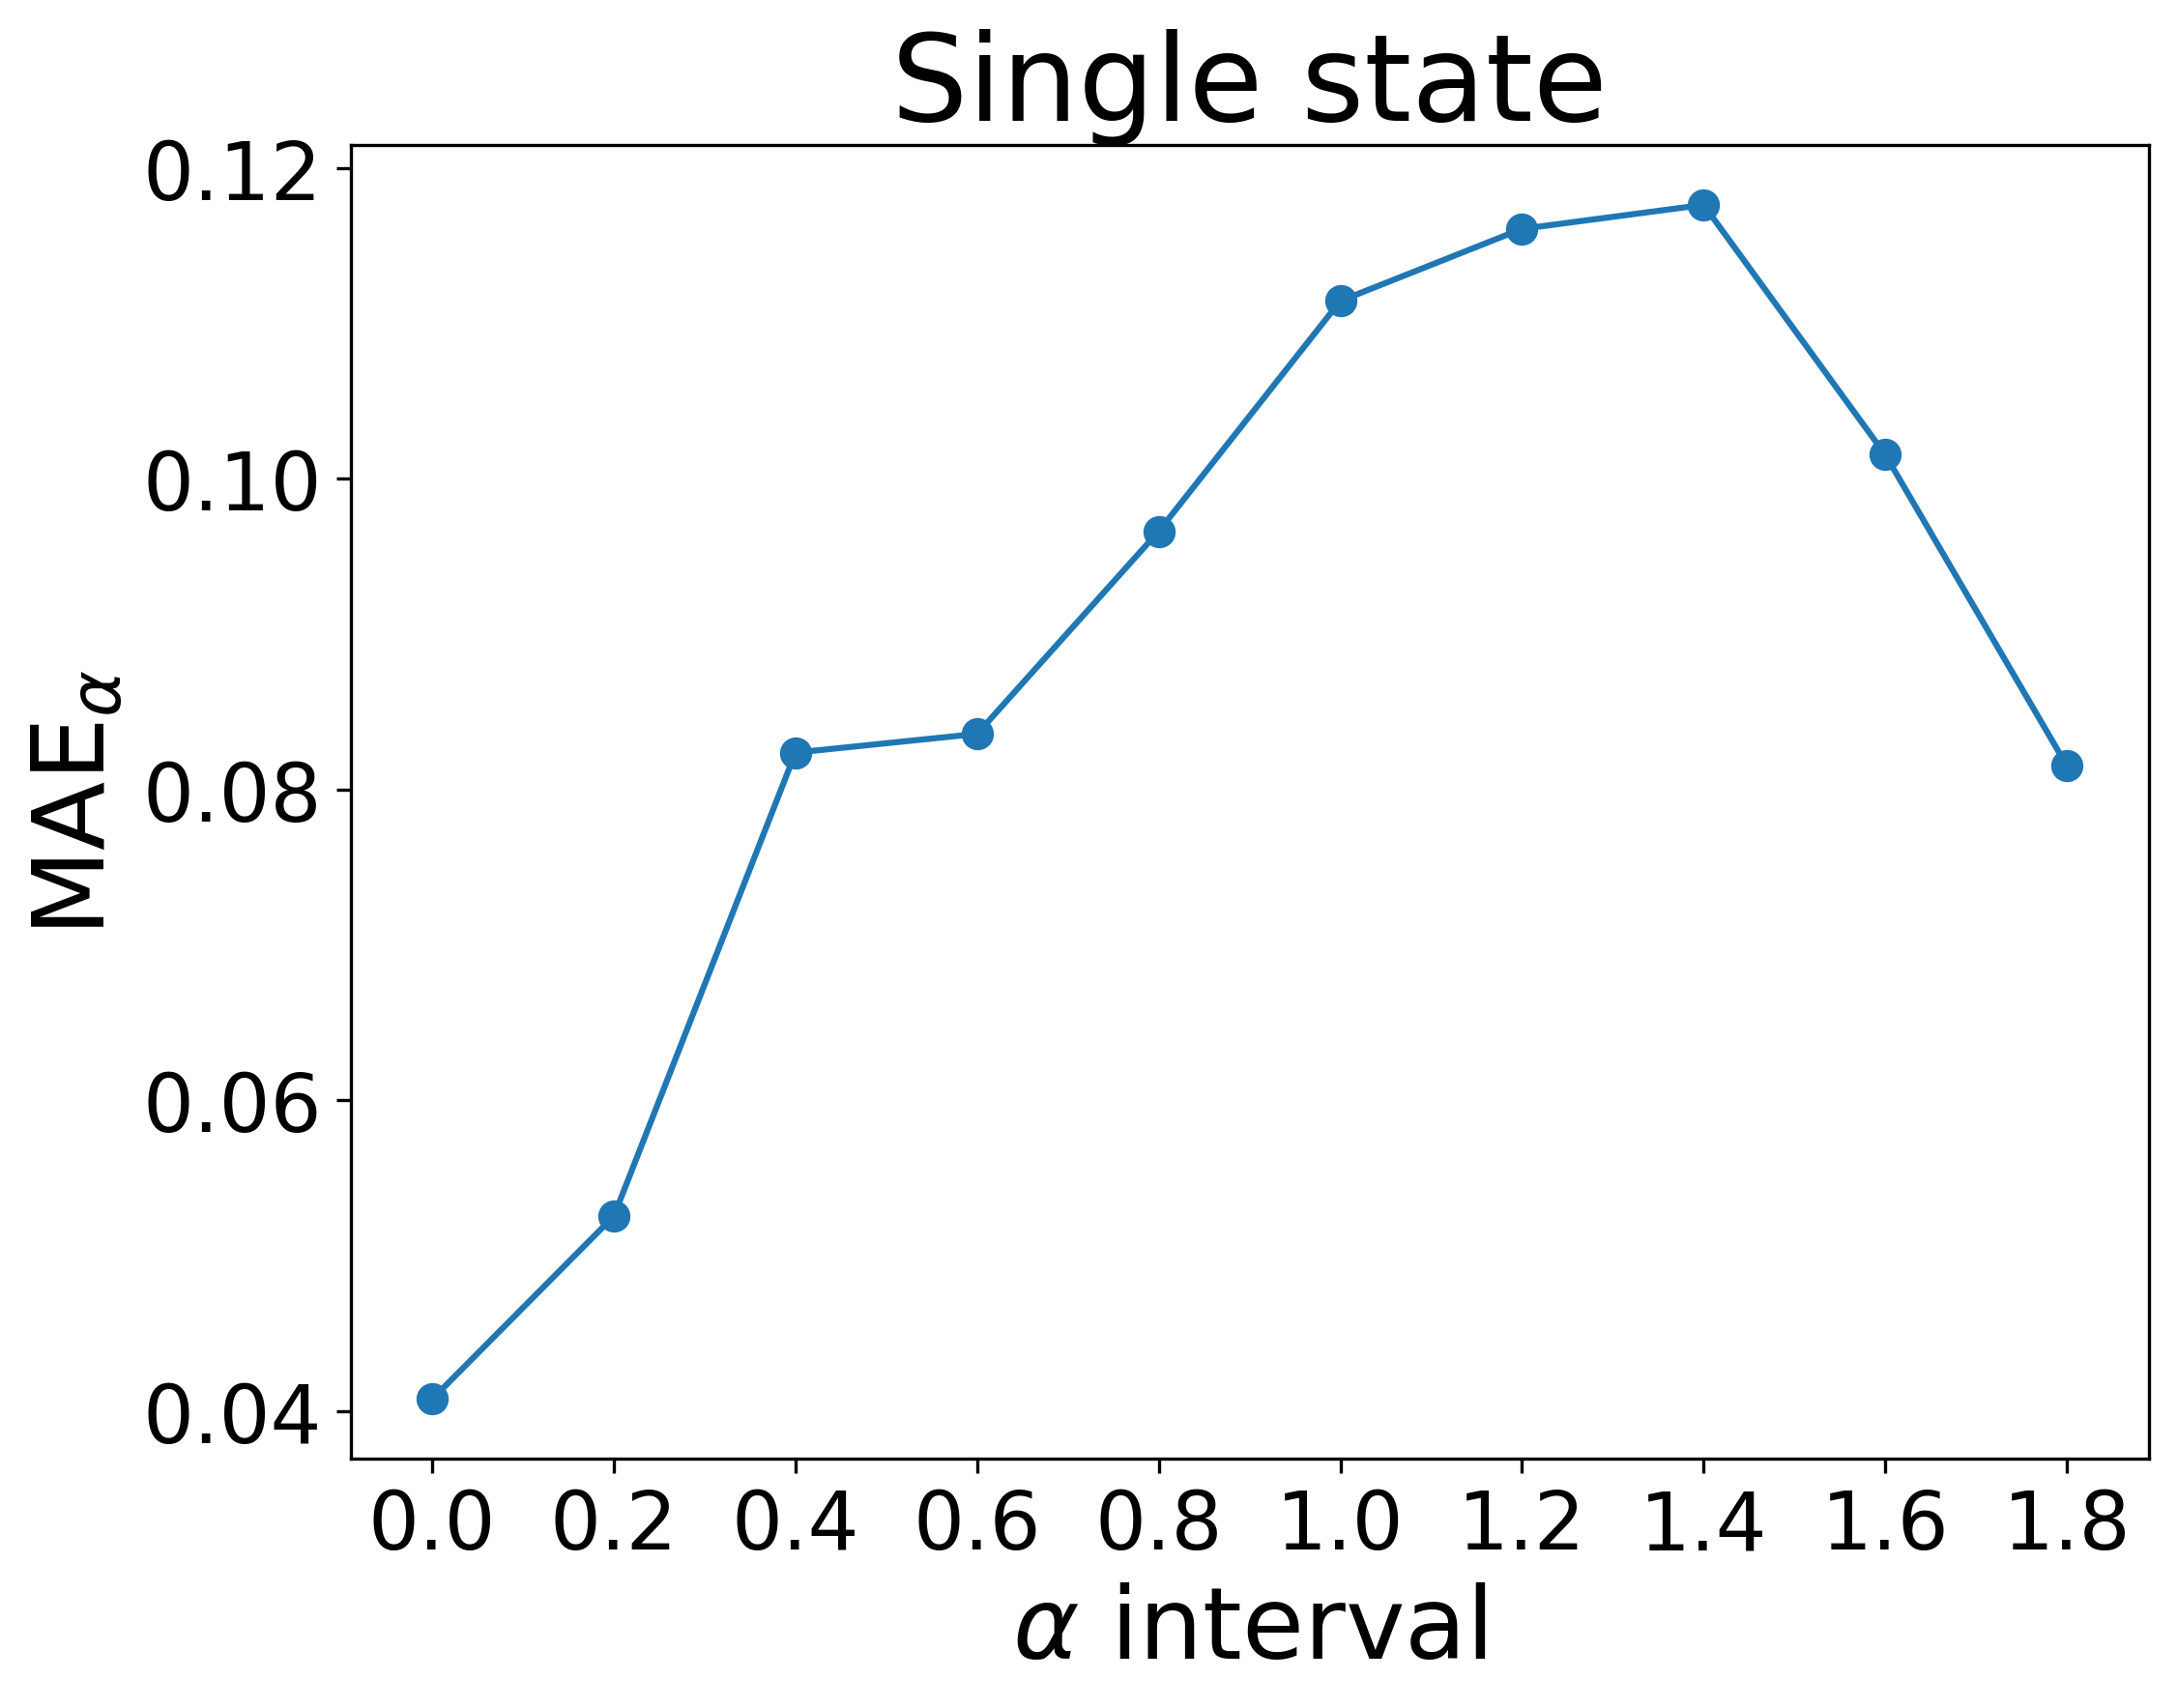

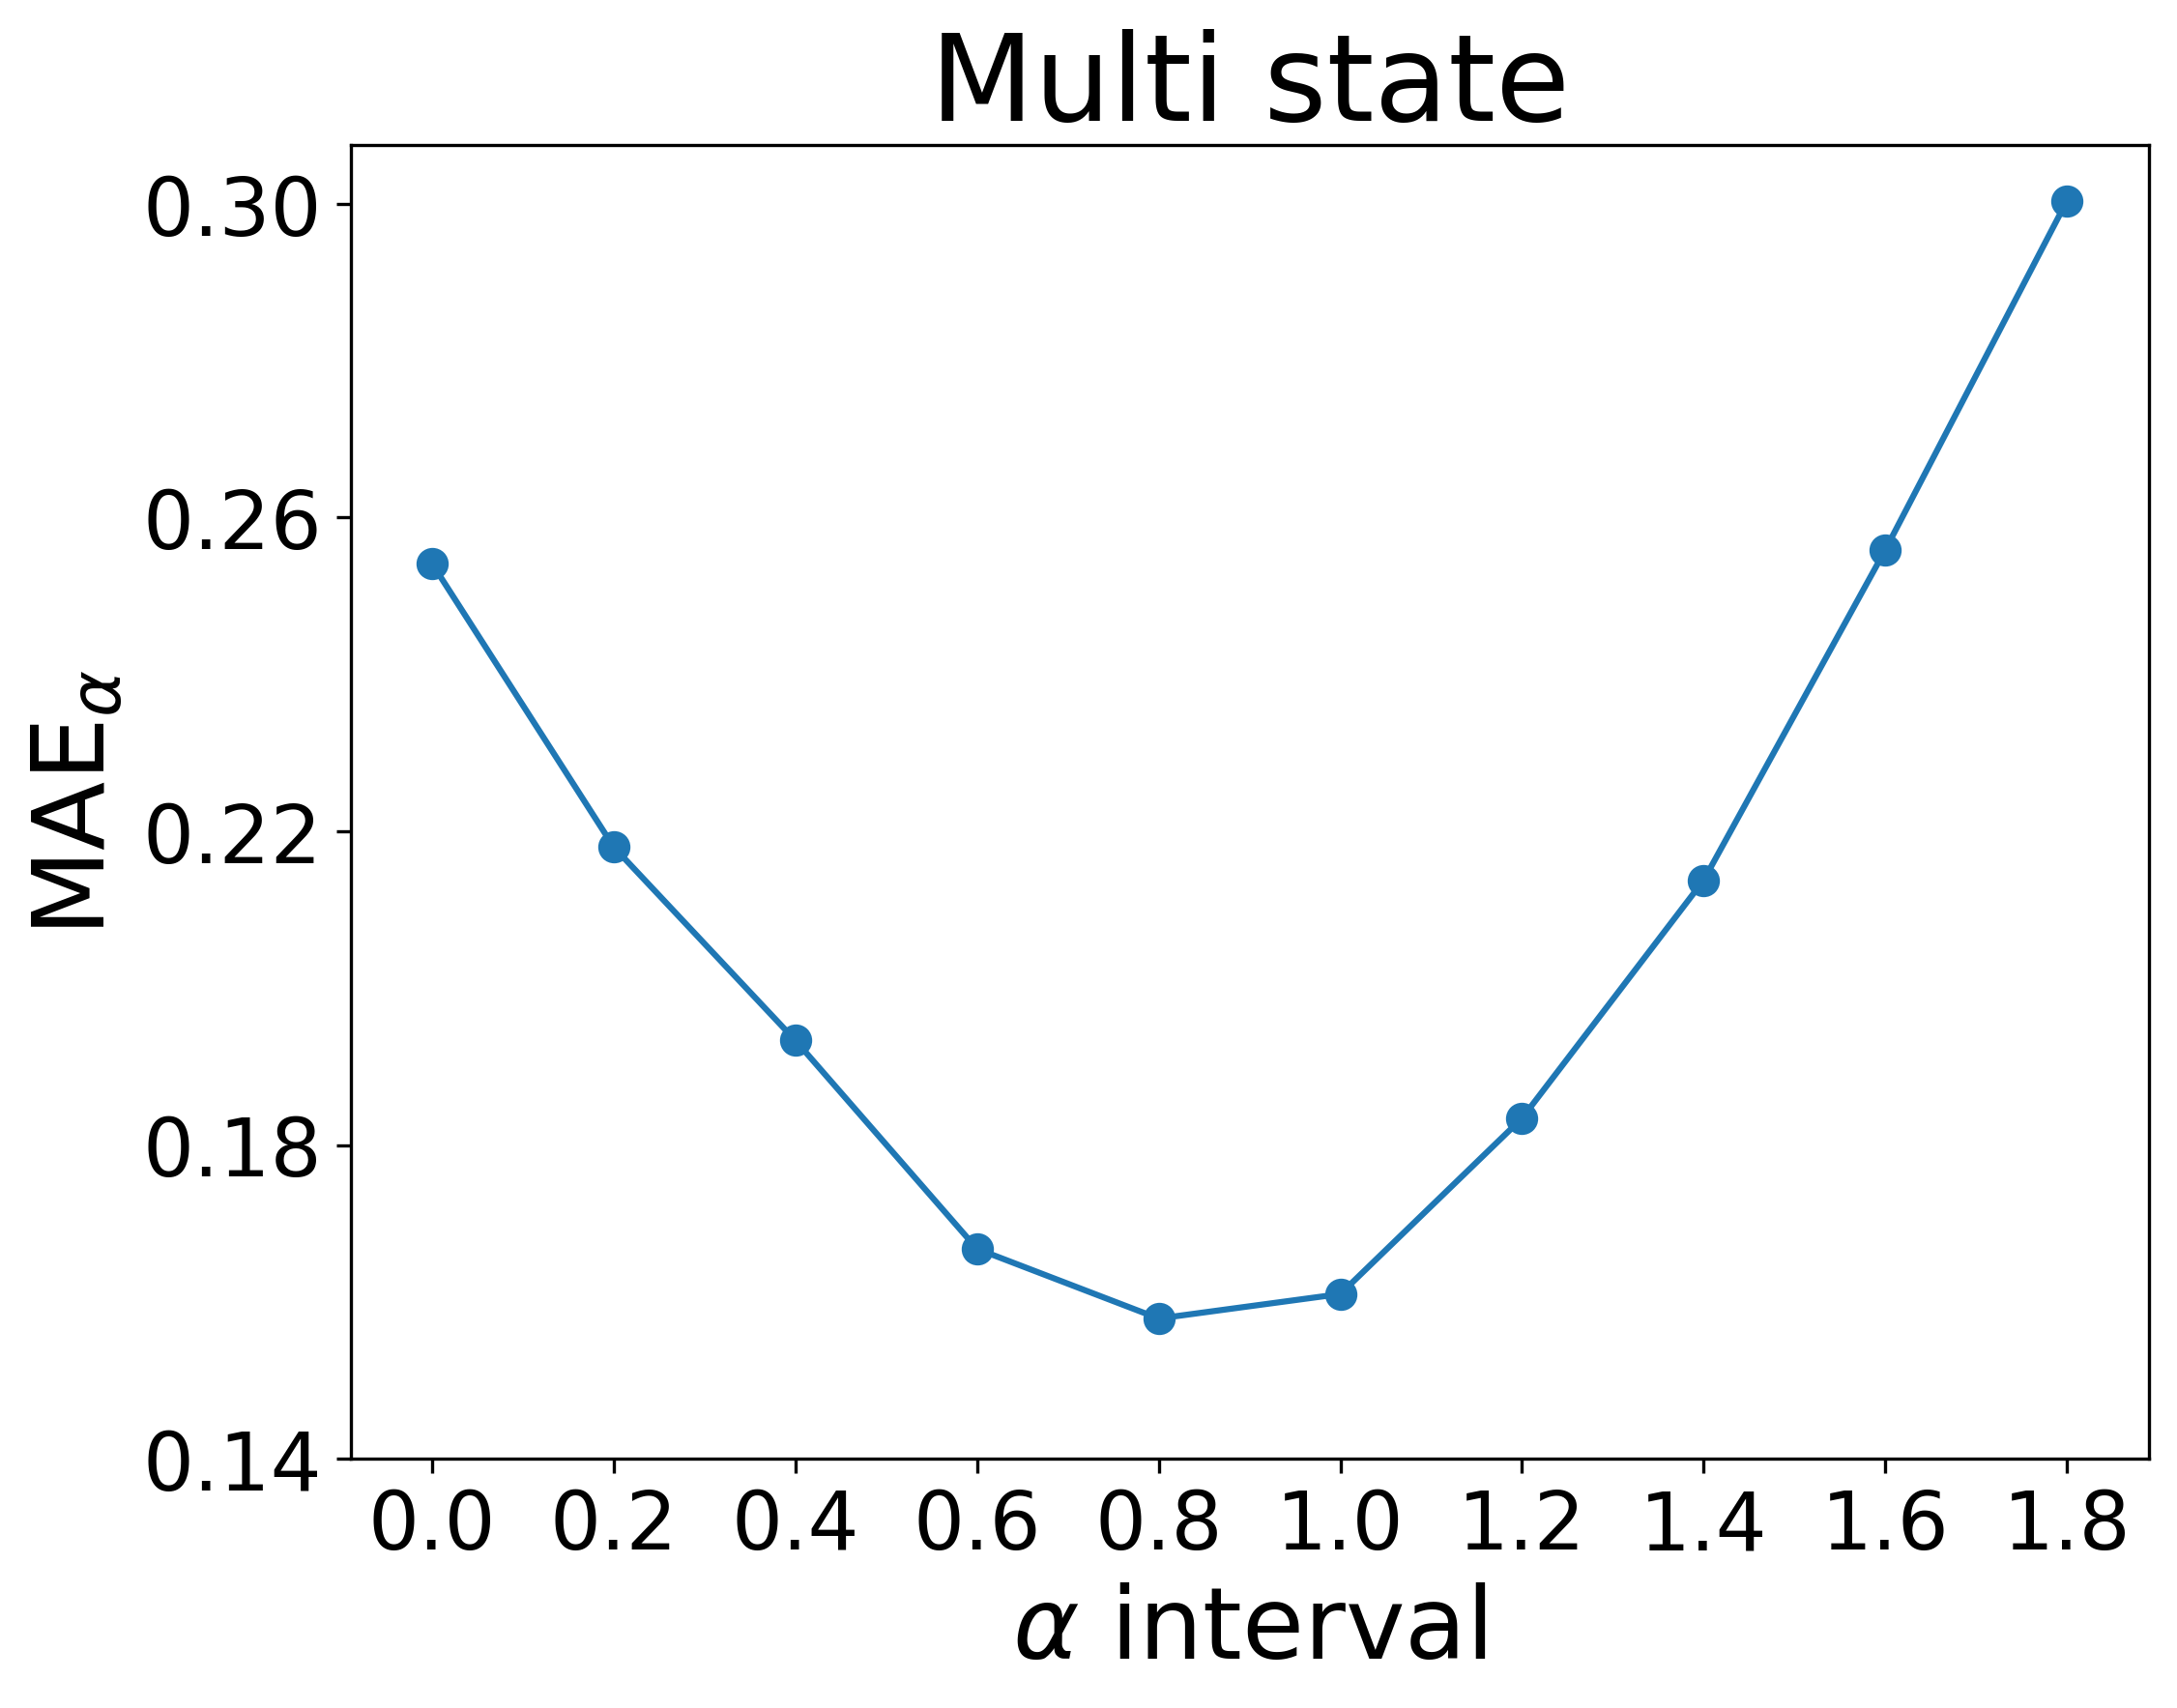

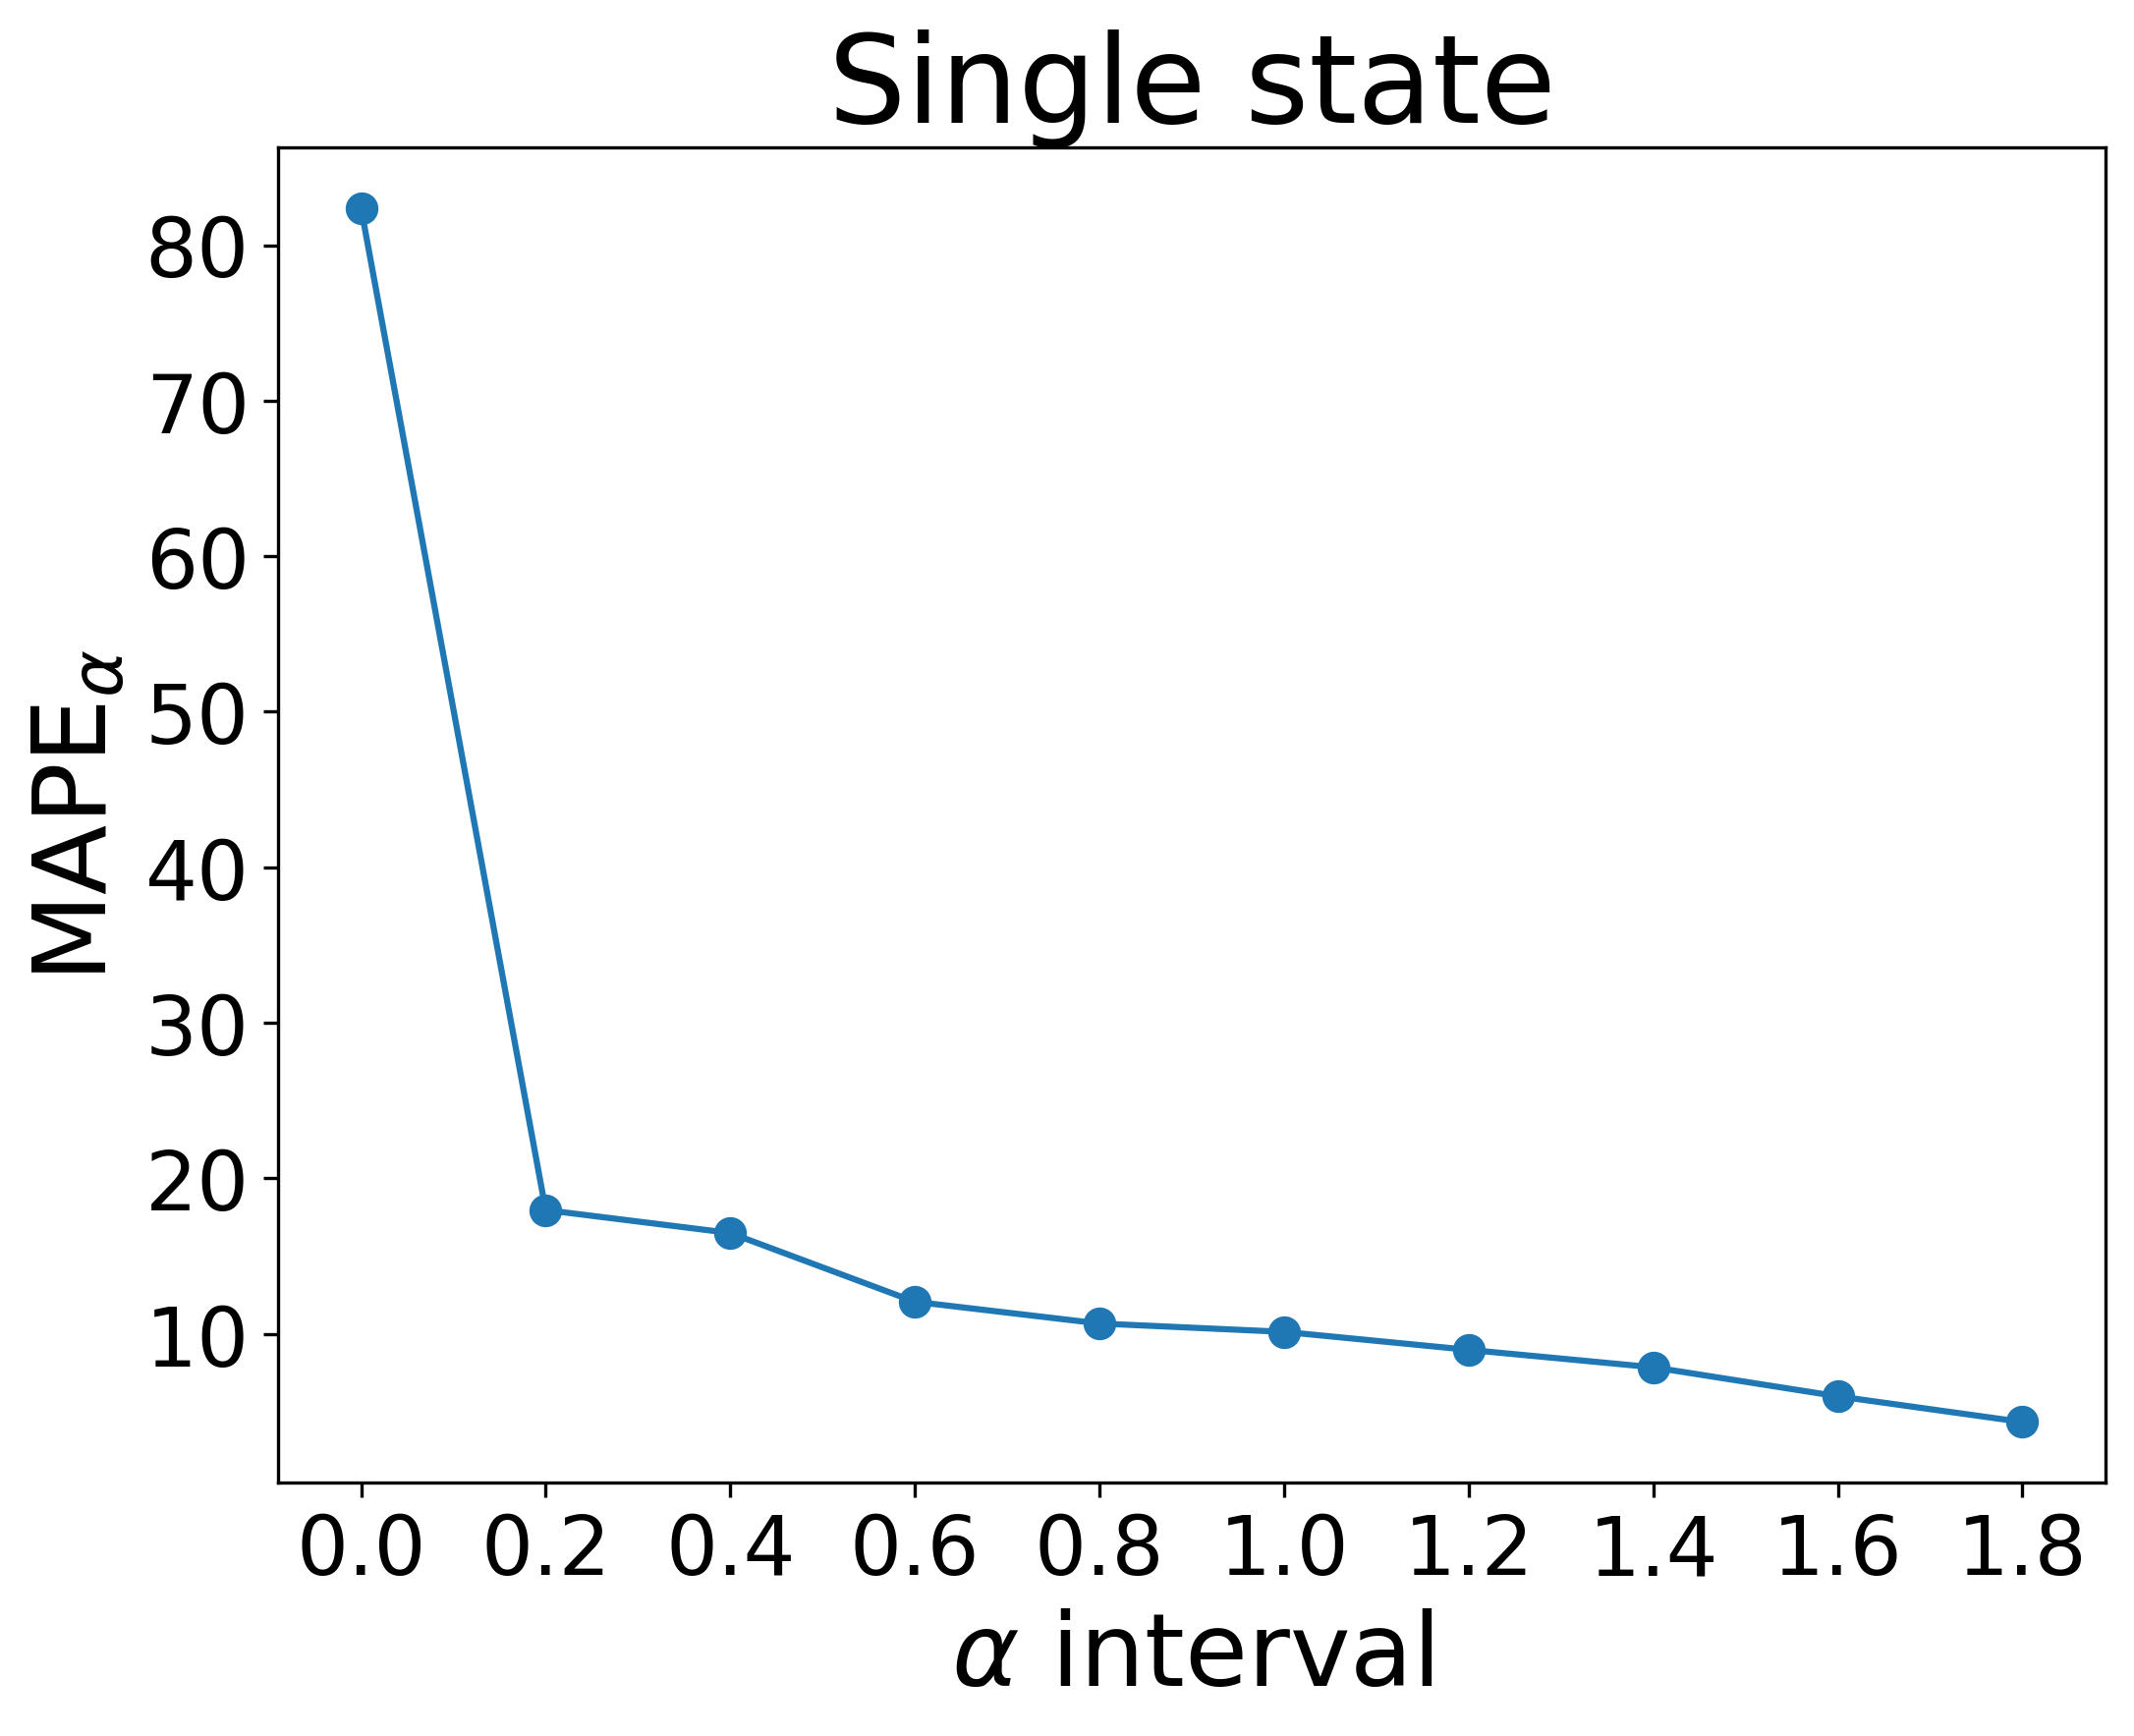

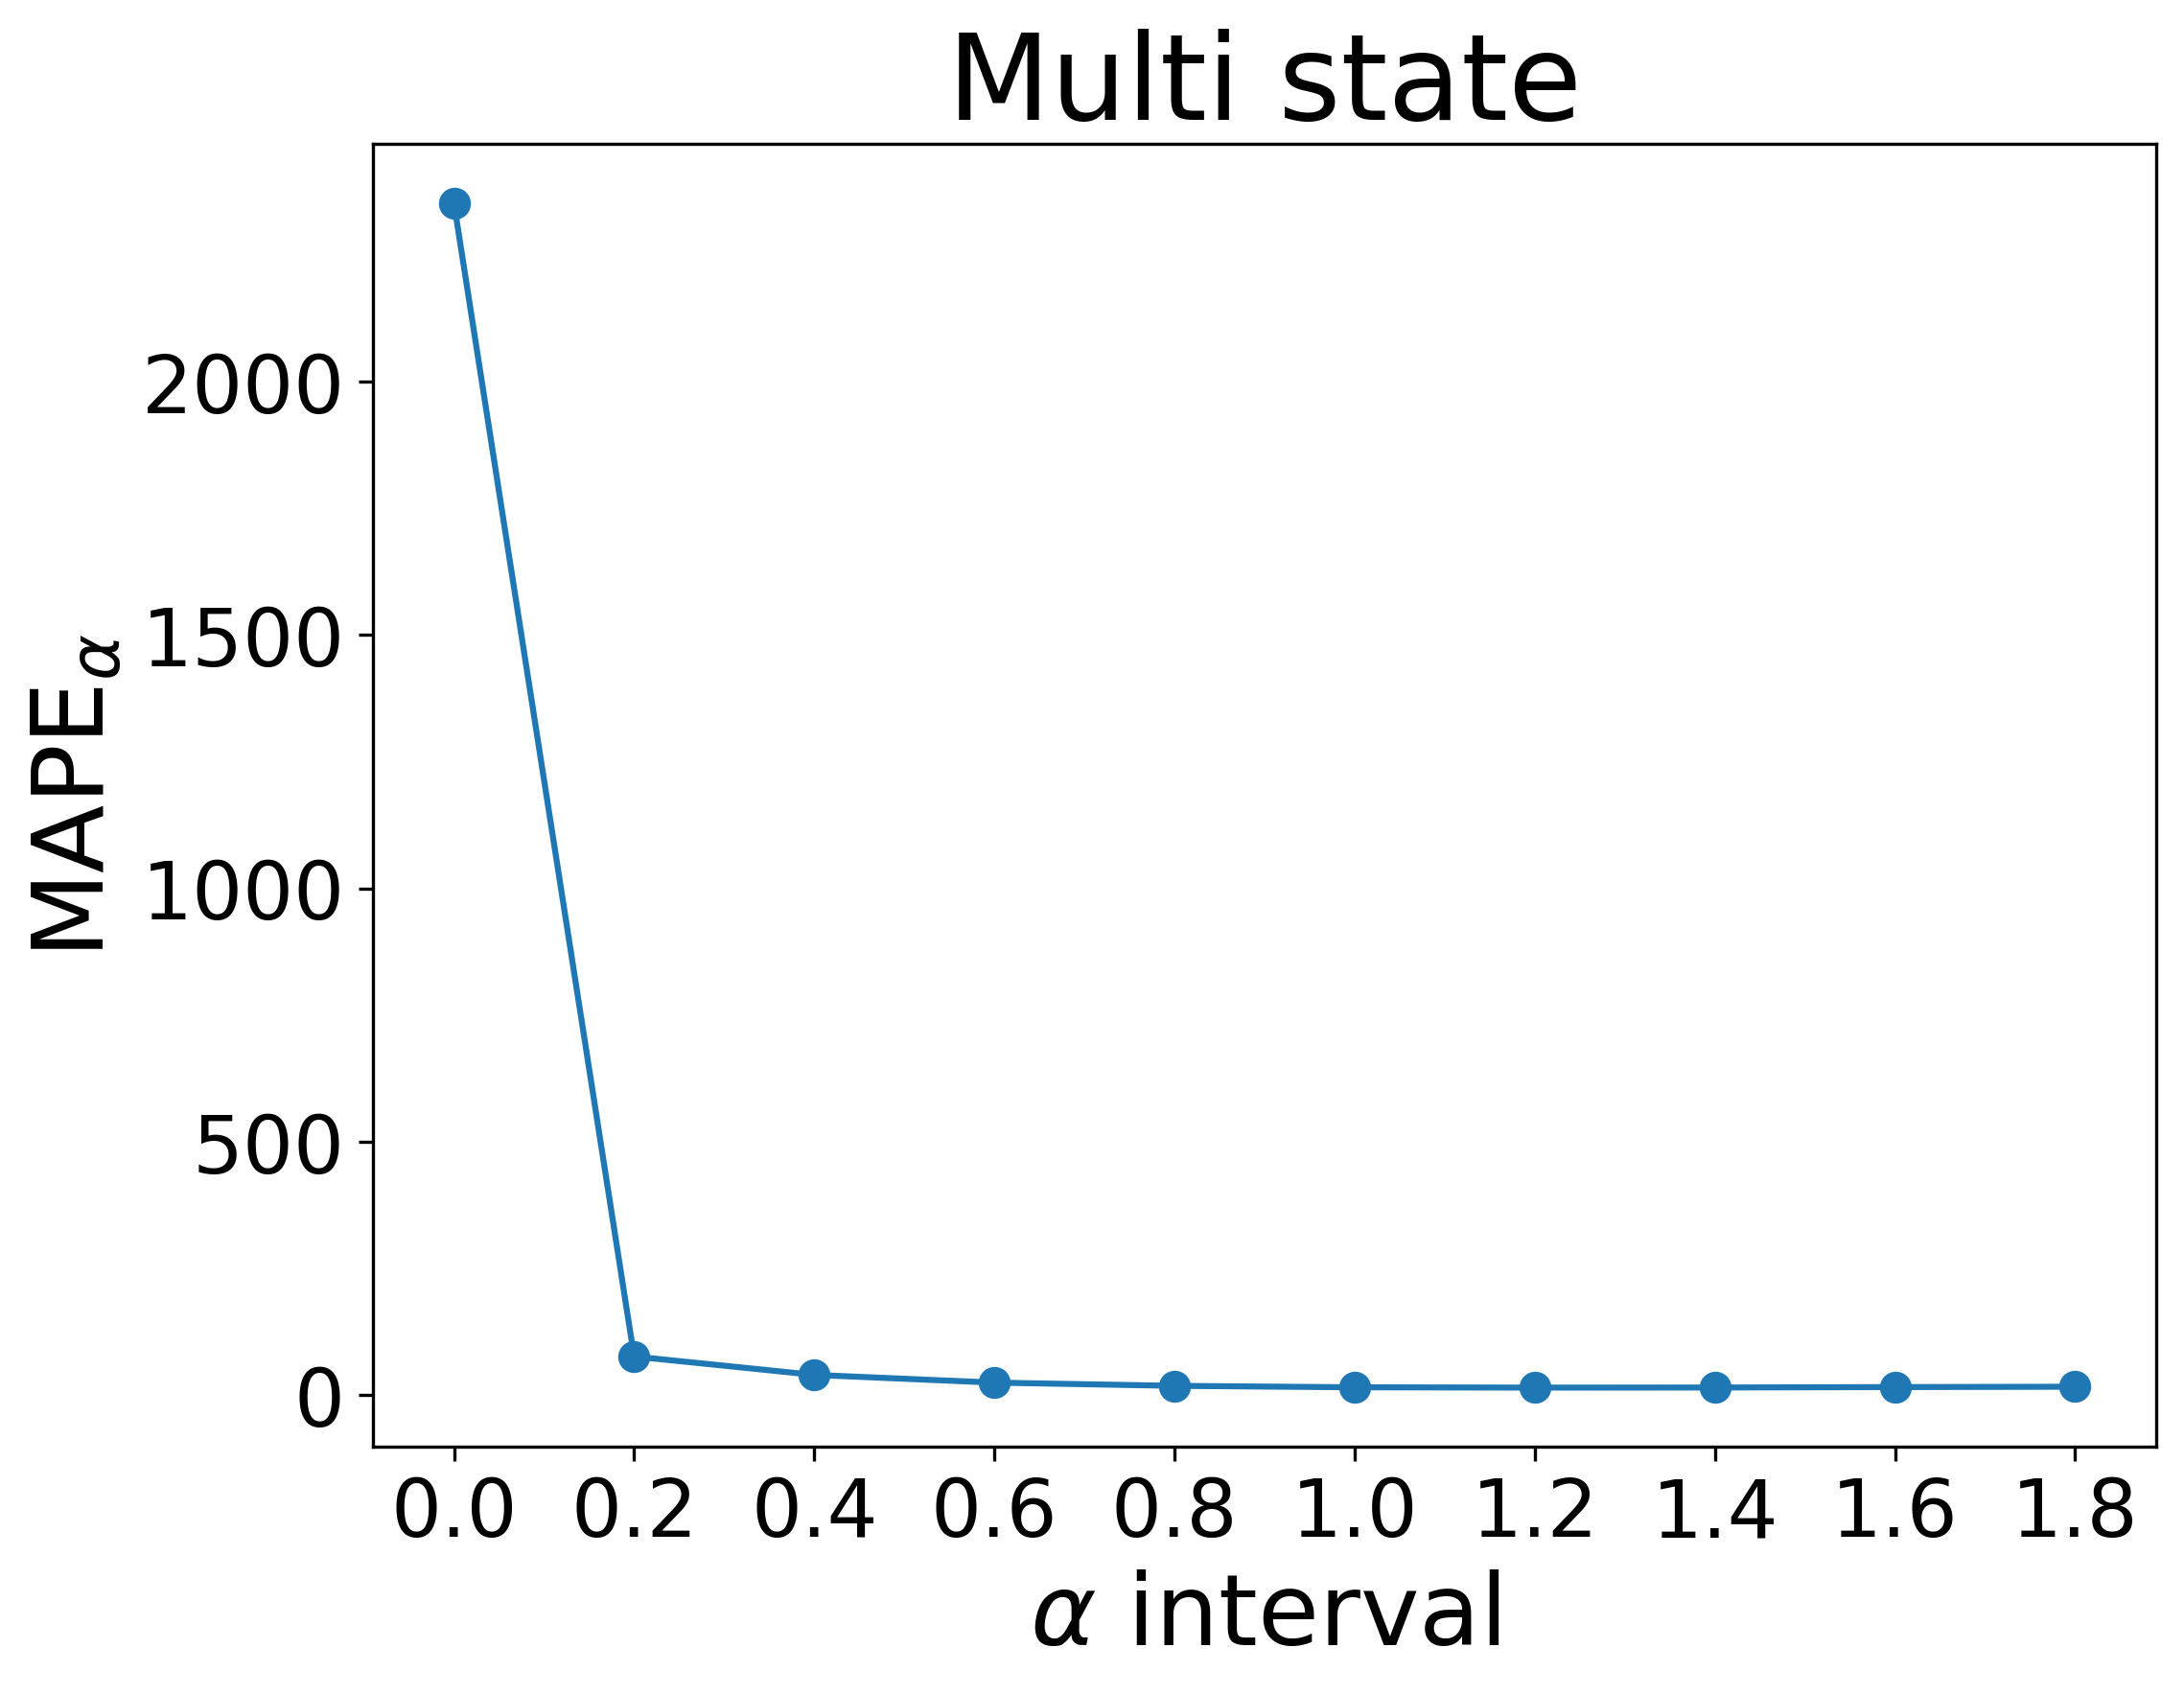

In [661]:
mae_alpha = {}
mape_alpha = {}
T = 9
for case in ['single', 'multi']:
    mae_case = np.zeros((2,10))
    mape_case = np.zeros((2,10))
    for i in range(10):
        mae_case[0,i] = np.mean(alpha_performance[case][0][i])
        mae_case[1,i] = np.std(alpha_performance[case][0][i])
        mape_case[0,i] = np.mean(alpha_performance[case][1][i])
        mape_case[1,i] = np.std(alpha_performance[case][1][i])
        
    mae_alpha[case] = mae_case
    mape_alpha[case] = mape_case
    
plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)
plt.plot(mae_alpha['single'][0], 'o-', ms = 7)
plt.xticks(np.linspace(0,T,T+1), np.round(np.linspace(0,T,T+1)*0.2,2), fontsize = 20)
plt.yticks([0.04,0.06,0.08,0.10,0.12], fontsize = 20)
plt.xlabel(r'$\alpha$' +' interval',fontsize = 25)
plt.ylabel(r'MAE$_{\alpha}$', fontsize=25)
plt.title('Single state', fontsize = 30)
plt.show()

plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)
plt.plot(mae_alpha['multi'][0], 'o-', ms = 7)
plt.xticks(np.linspace(0,T,T+1), np.round(np.linspace(0,T,T+1)*0.2,2), fontsize = 20)
plt.yticks([0.14,0.18,0.22,0.26,0.30], fontsize = 20)
plt.xlabel(r'$\alpha$' +' interval',fontsize = 25)
plt.ylabel(r'MAE$_{\alpha}$', fontsize=25)
plt.title('Multi state', fontsize = 30)
plt.show()

plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)
plt.plot(mape_alpha['single'][0], 'o-', ms = 7)
plt.xticks(np.linspace(0,T,T+1), np.round(np.linspace(0,T,T+1)*0.2,2), fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel(r'$\alpha$' +' interval',fontsize = 25)
plt.ylabel(r'MAPE$_{\alpha}$', fontsize=25)
plt.title('Single state', fontsize = 30)
plt.show()

plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)
plt.plot(mape_alpha['multi'][0], 'o-', ms = 7)
plt.xticks(np.linspace(0,T,T+1), np.round(np.linspace(0,T,T+1)*0.2,2), fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel(r'$\alpha$' +' interval',fontsize = 25)
plt.ylabel(r'MAPE$_{\alpha}$', fontsize=25)
plt.title('Multi state', fontsize = 30)
plt.show()

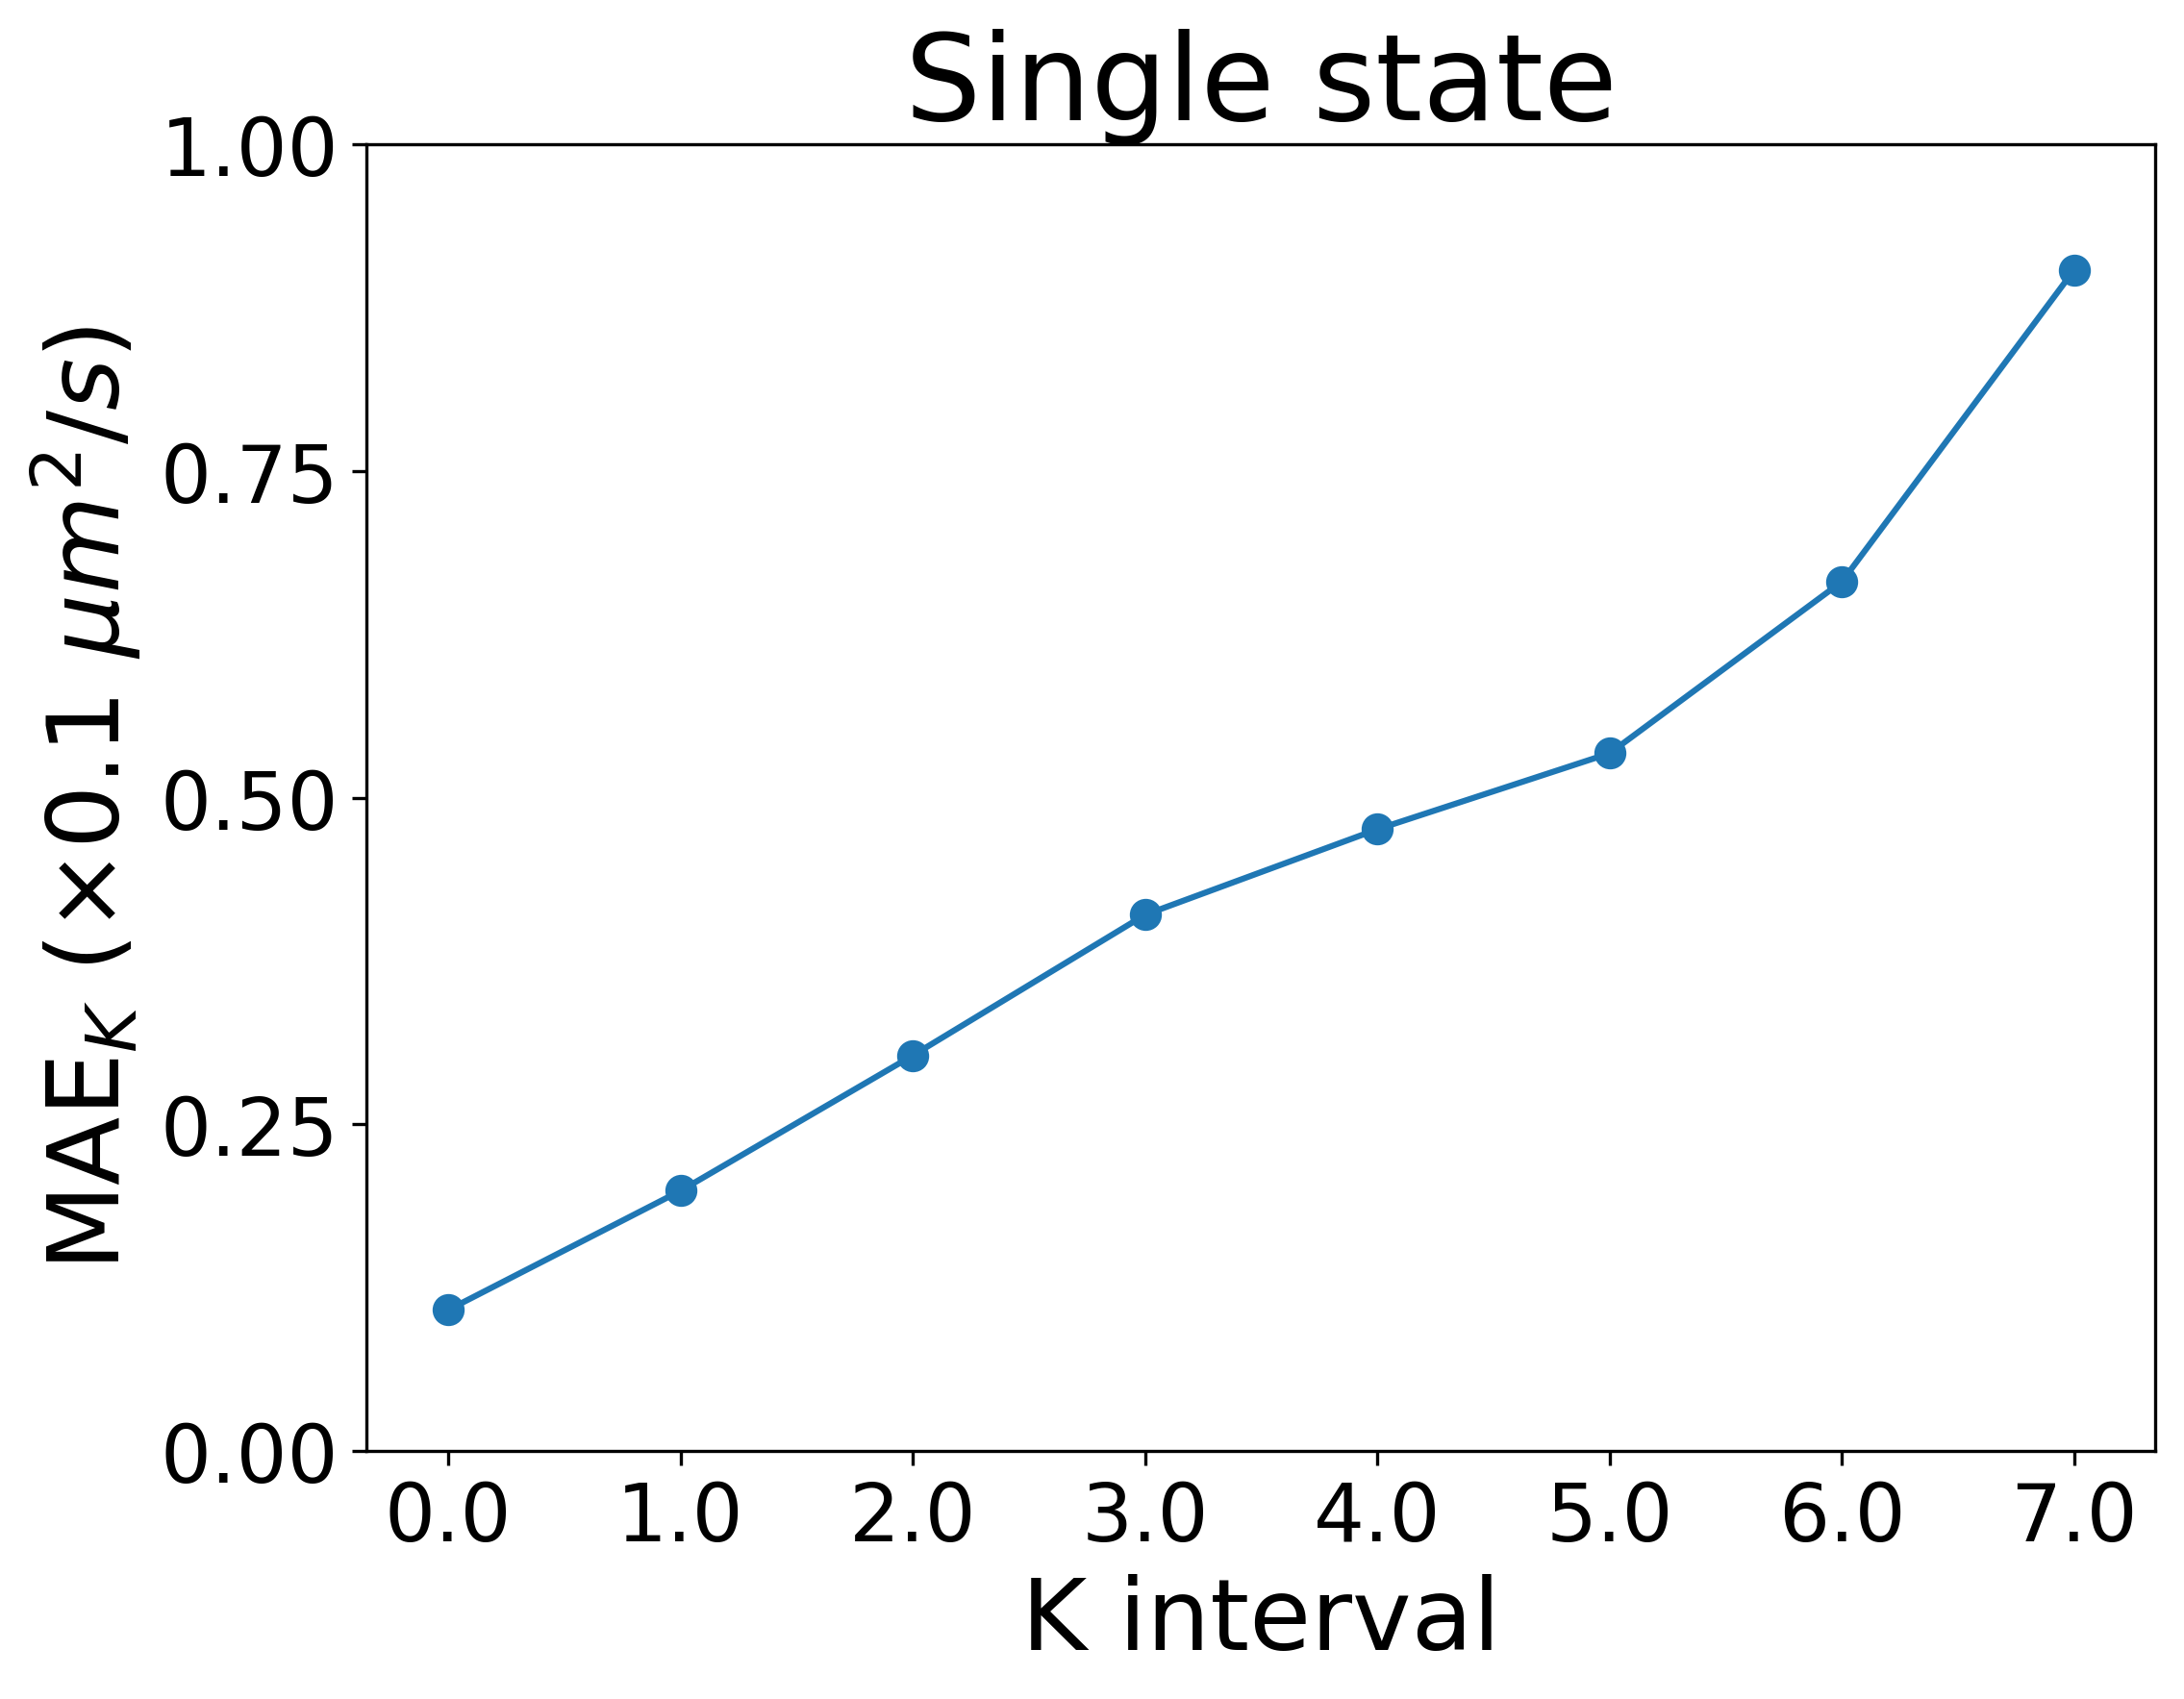

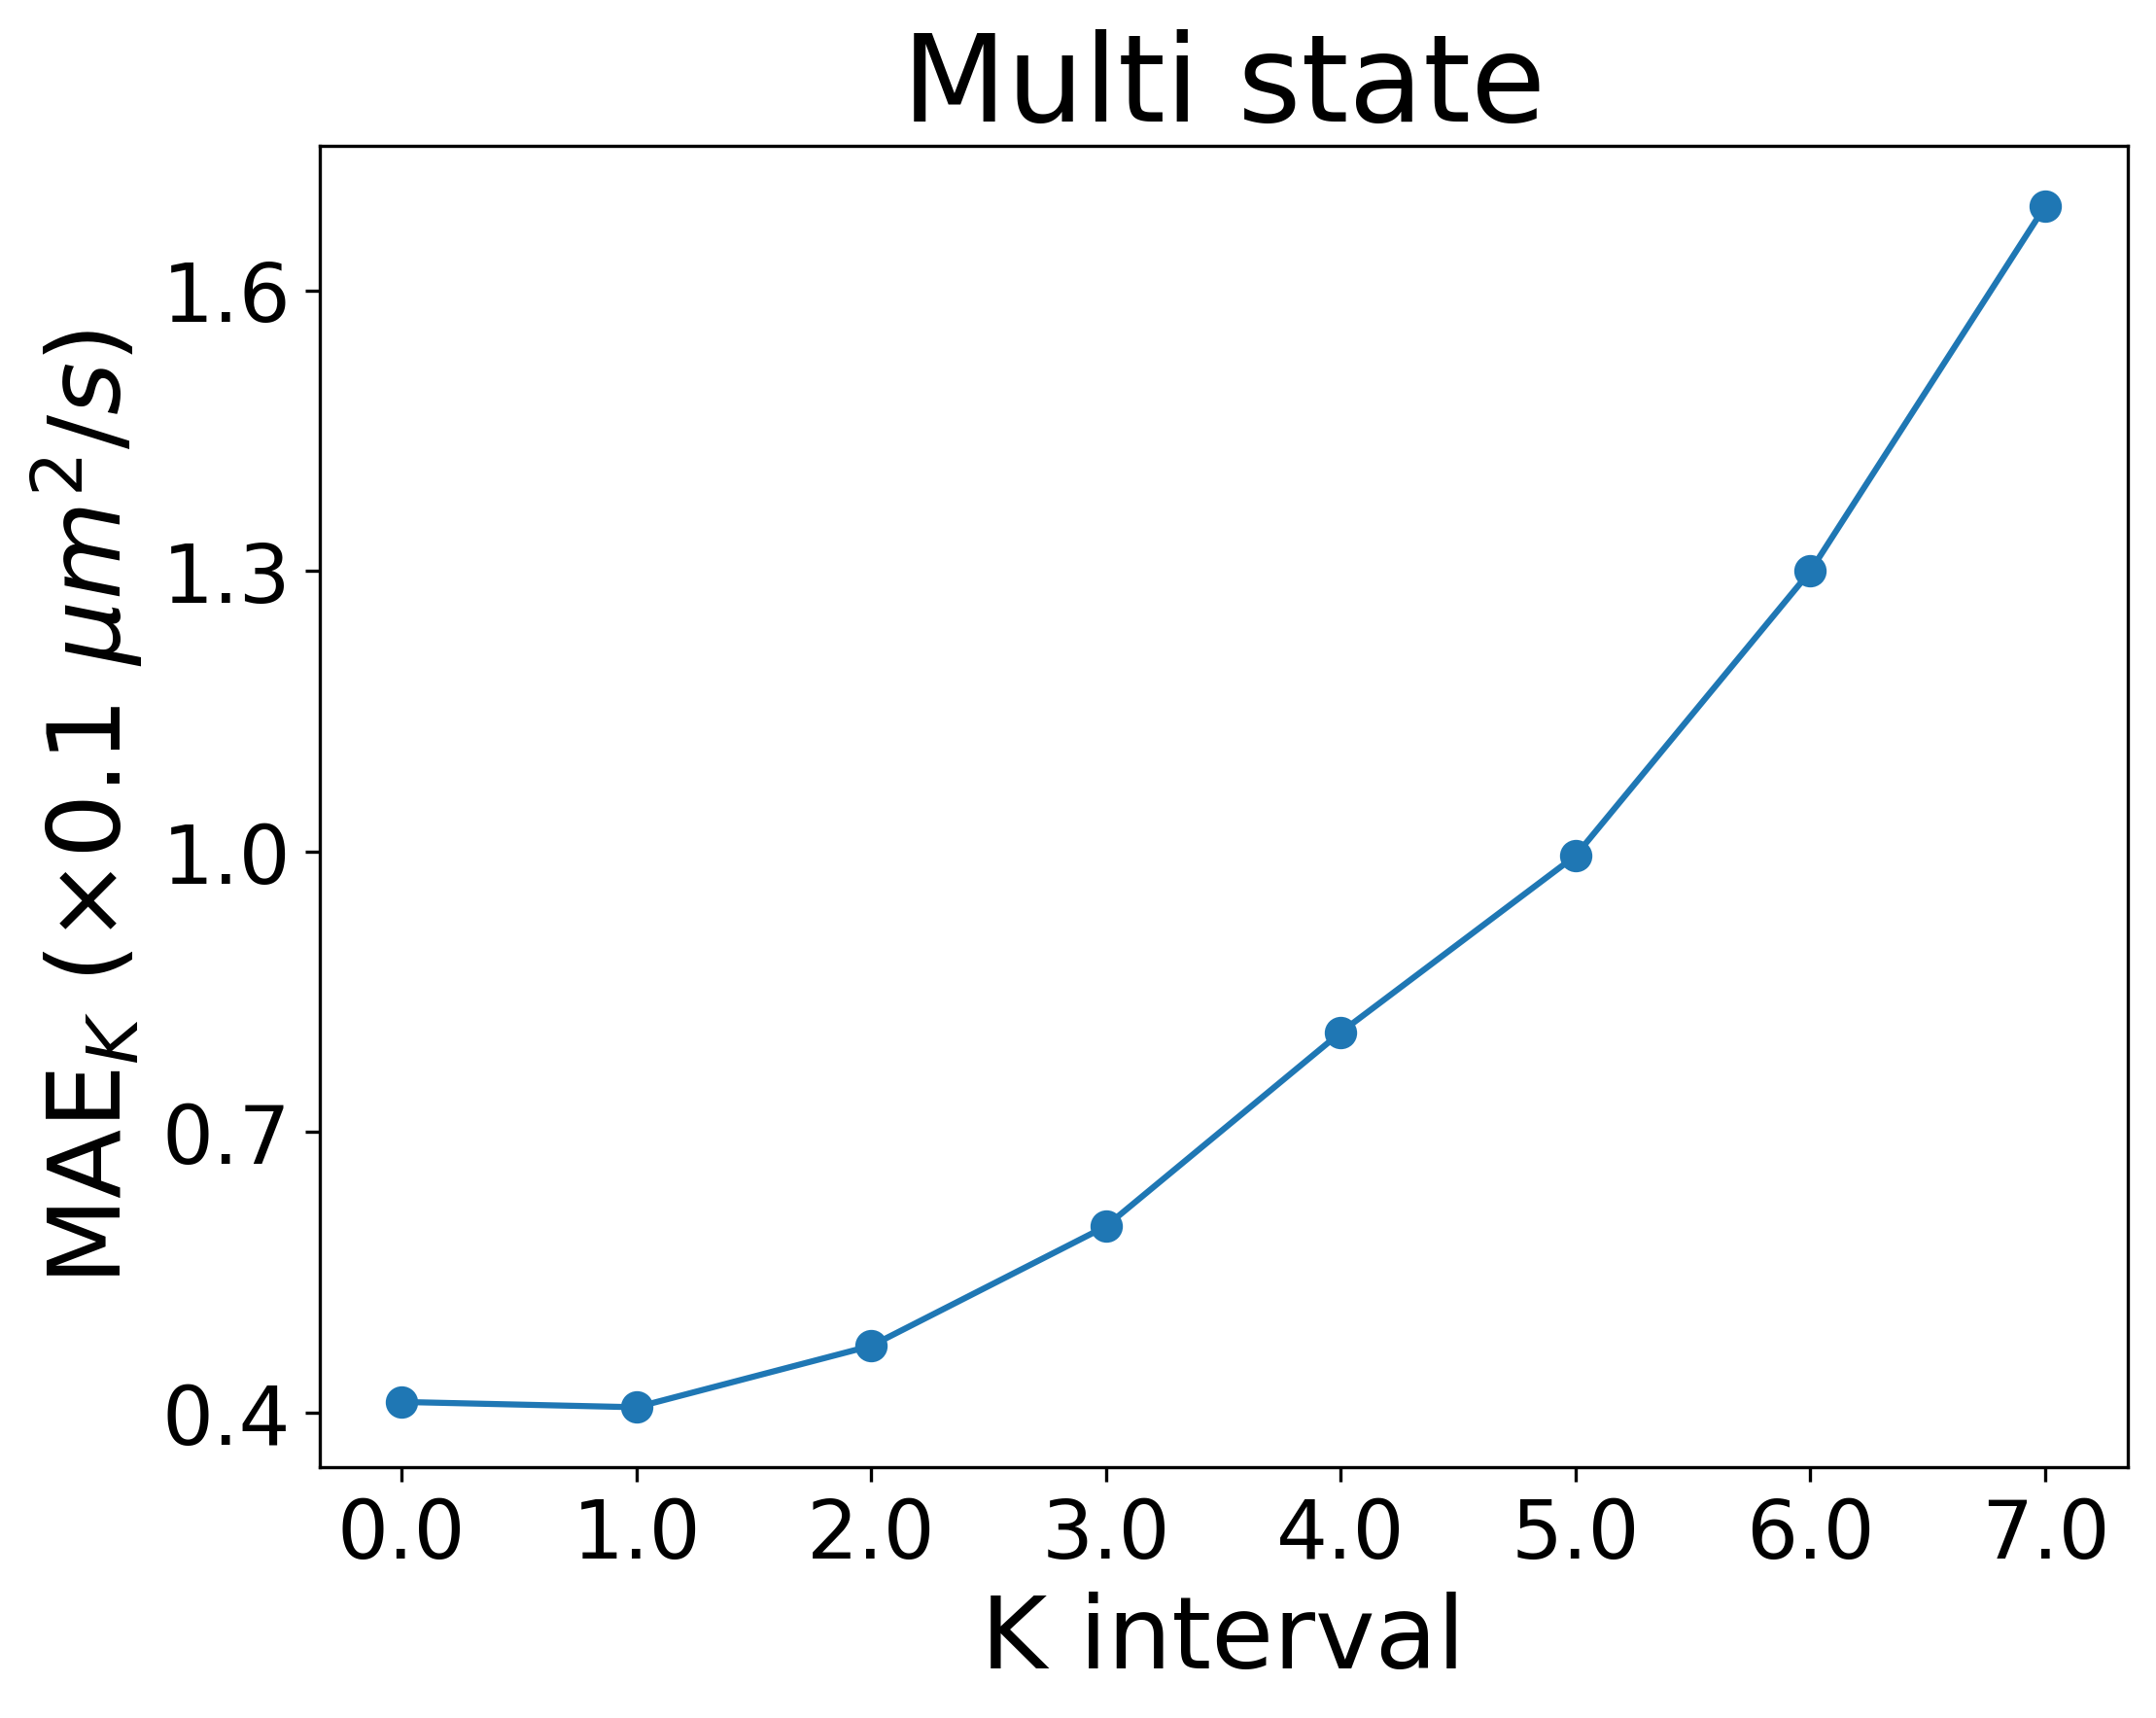

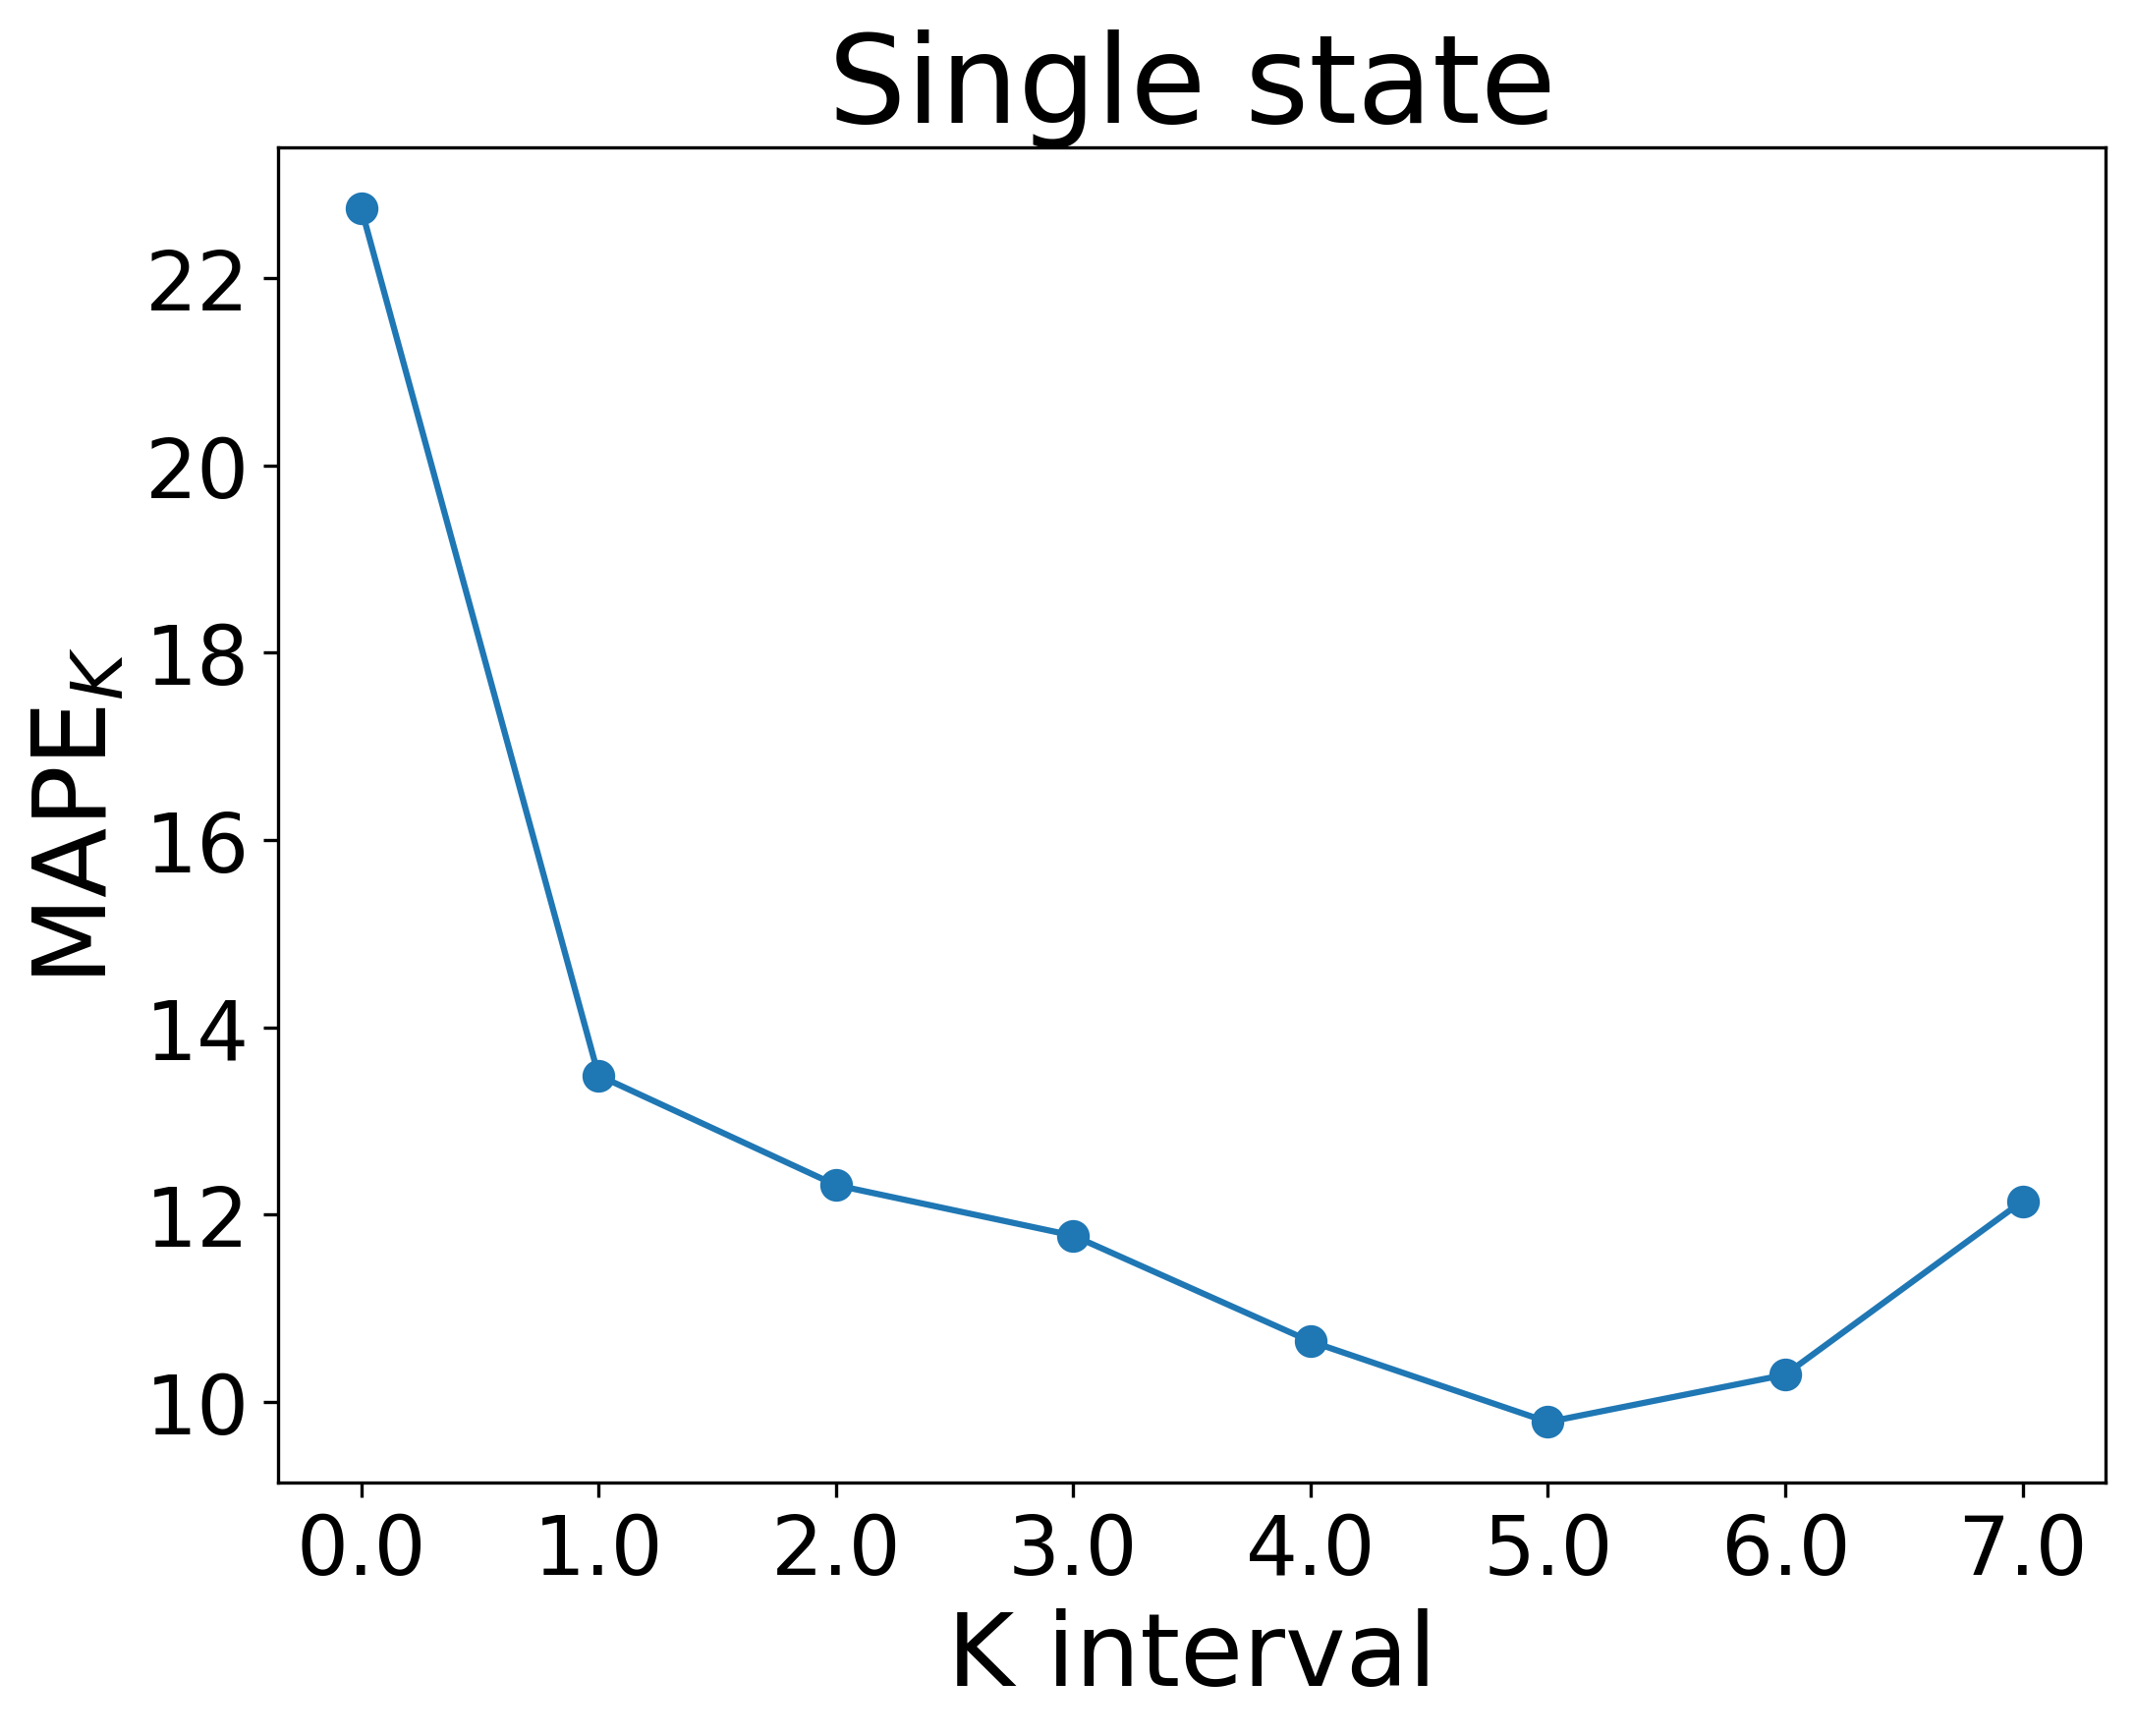

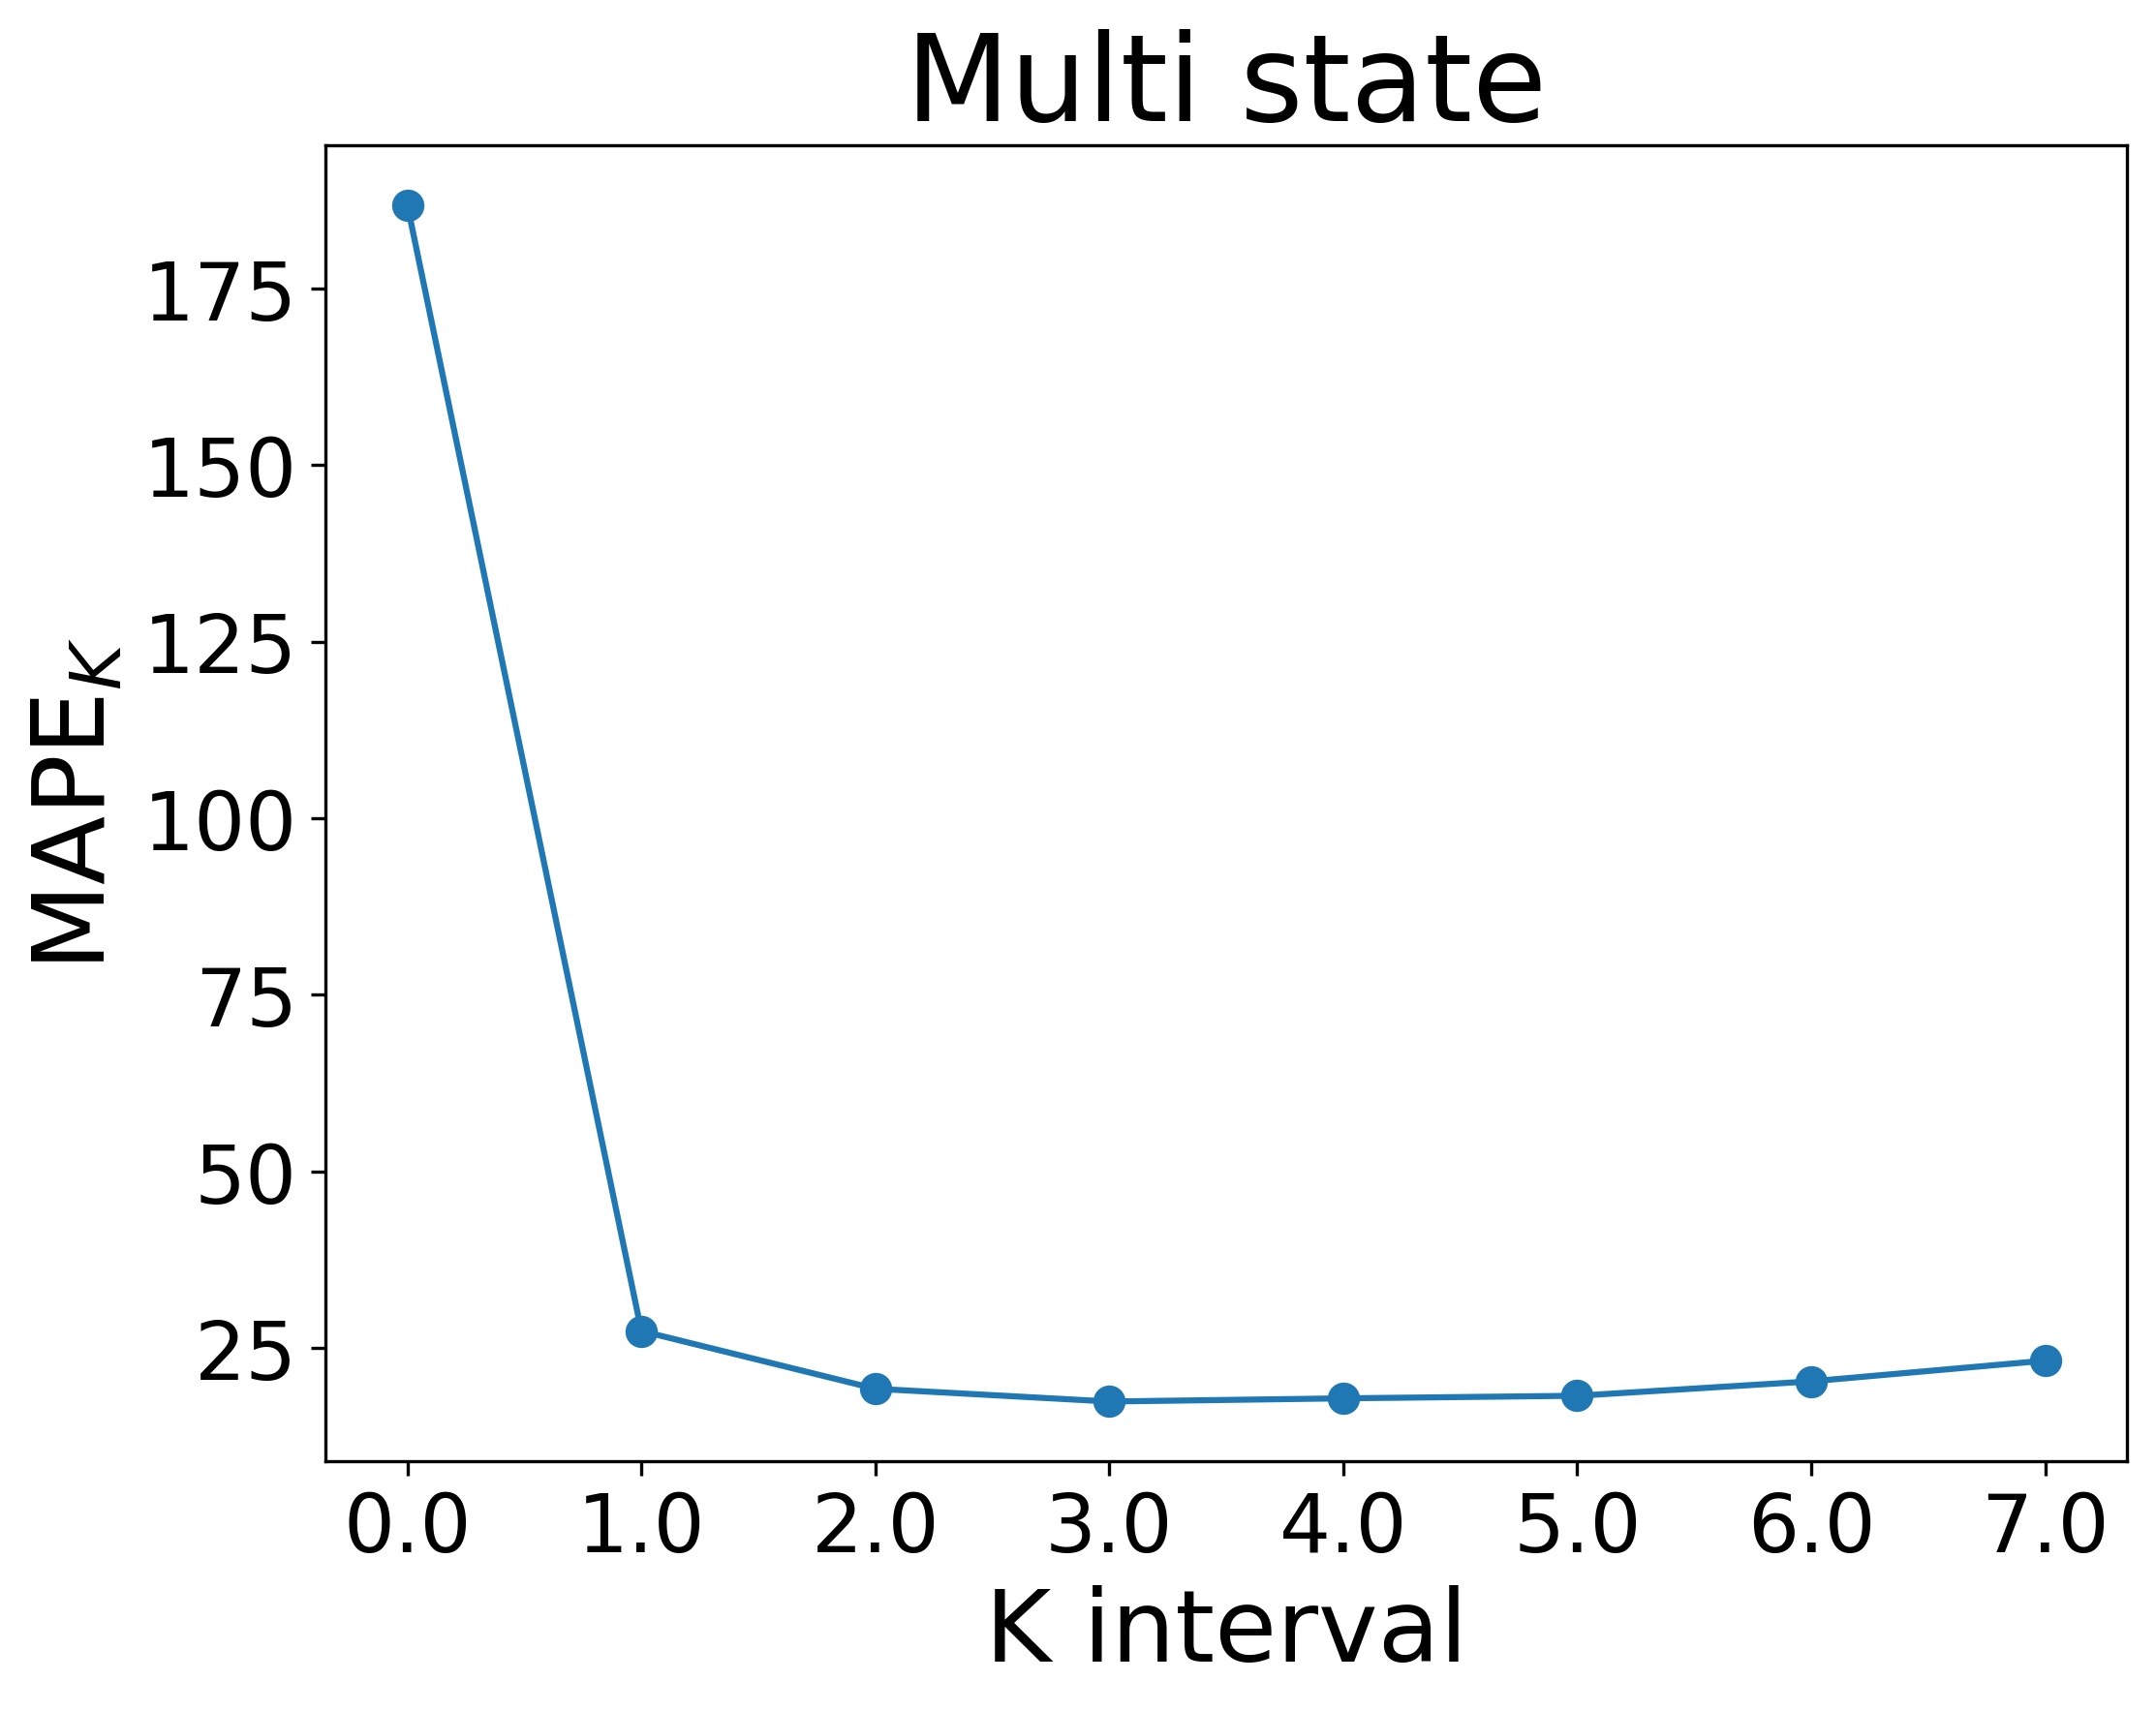

In [662]:
mae_k = {}
mape_k = {}
T = 7
for case in ['single', 'multi']:
    mae_case = np.zeros((2,8))
    mape_case = np.zeros((2,8))
    for i in range(8):
        mae_case[0,i] = np.mean(k_performance[case][0][i])
        mae_case[1,i] = np.std(k_performance[case][0][i])
        mape_case[0,i] = np.mean(k_performance[case][1][i])
        mape_case[1,i] = np.std(k_performance[case][1][i])
        
    mae_k[case] = mae_case
    mape_k[case] = mape_case
    
plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)
plt.plot(mae_k['single'][0], 'o-', ms = 7)
plt.xticks(np.linspace(0,T,T+1), np.round(np.linspace(0,T,T+1),2), fontsize = 20)
plt.yticks([0.00,0.25,0.50,0.75,1.00], fontsize = 20)
plt.xlabel('K' +' interval',fontsize = 25)
plt.ylabel(r'MAE$_{K}$' + ' ' + r'$(\times0.1\ \mu m^2/s)$', fontsize=25)
plt.title('Single state', fontsize = 30)
plt.show()

plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)
plt.plot(mae_k['multi'][0], 'o-', ms = 7)
plt.xticks(np.linspace(0,T,T+1), np.round(np.linspace(0,T,T+1),2), fontsize = 20)
plt.yticks([0.40,0.70,1.00,1.30,1.60], fontsize = 20)
plt.xlabel('K' +' interval',fontsize = 25)
plt.ylabel(r'MAE$_{K}$' + ' ' + r'$(\times0.1\ \mu m^2/s)$', fontsize=25)
plt.title('Multi state', fontsize = 30)
plt.show()

plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)
plt.plot(mape_k['single'][0], 'o-', ms = 7)
plt.xticks(np.linspace(0,T,T+1), np.round(np.linspace(0,T,T+1),2), fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('K' +' interval',fontsize = 25)
plt.ylabel(r'MAPE$_{K}$', fontsize=25)
plt.title('Single state', fontsize = 30)
plt.show()

plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)
plt.plot(mape_k['multi'][0], 'o-', ms = 7)
plt.xticks(np.linspace(0,T,T+1), np.round(np.linspace(0,T,T+1),2), fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('K' +' interval',fontsize = 25)
plt.ylabel(r'MAPE$_{K}$', fontsize=25)
plt.title('Multi state', fontsize = 30)
plt.show()

In [663]:
mape_alpha['multi'][0]

array([2352.49866786,   75.52972033,   39.15938785,   23.93953118,
         17.60059803,   14.67443829,   14.10821741,   14.26141316,
         15.09926187,   15.83958208])

In [664]:

T = 200



with open('Data/Feature/length_data (200, {})'.format(3), 'rb') as f:
    length_origin = pickle.load(f)
    
with open('Data/Feature/cp_data (200, {})'.format(3), 'rb') as f:
    cp_origin = pickle.load(f)

    
length_multi = []
cp_multi = []
for case in cases[1:]:
    for n in range(len(length_origin[case][2])):
        length_multi.append(length_origin[case][2][n])
        cp_multi.append(cp_origin[case][2][n])


length_data = {}
cp_data = {}

length_data['single'] = length_origin['single'][2]
length_data['multi'] = length_multi

cp_data['single'] = cp_origin['single'][2]
cp_data['multi'] = cp_multi


def loss_mae(pred_data, true_data,length, scale,case):
    mae_list = []
    for n in range(len(pred_data)):
        mae_n = []
        for t in range(length[n]):
            mae = np.abs(pred_data[n][t]*scale - true_data[n][t]*scale)
            mae_n.append(mae)
        mae_list.append(np.mean(mae_n))
        
    return mae_list


mae_alpha = {}
mae_k = {}

for case in cases[:2]:
    mae_alpha[case] = loss_mae(pred_data[case]['alpha'], true_data[case]['alpha'],length_data[case], 1,case)
    mae_k[case] = loss_mae(pred_data[case]['k'], true_data[case]['k'],length_data[case], 1,case)

    print(len(mae_alpha[case]))
    print(len(mae_k[case]))

12000
12000
48000
48000


In [665]:
print(len(mae_alpha['single']))
print(len(mae_alpha['multi']))
print(len(mae_k['single']))
print(len(mae_k['multi']))

12000
48000
12000
48000


In [666]:
loss_alpha = [mae_alpha['single'],mae_alpha['multi']]
loss_k = [mae_k['single'],mae_k['multi']]

2.5% = 0.005561669535535521
12.5% = 0.010918614858995354
87.5% = 0.19127078159949906
97.5% = 0.38195602225972525
median = 0.05133190438872217
mean = 0.08840928736207236
//
2.5% = 0.008223627011571515
12.5% = 0.020720545700234776
87.5% = 0.23483834028881134
97.5% = 0.4749260583138488
median = 0.07510840052090122
mean = 0.11711429741605675
//
0.005561669535535521 0.38195602225972525
0.008223627011571515 0.4749260583138488


Text(0, 0.5, '$\\mathit{MAE}_{\\alpha}$')

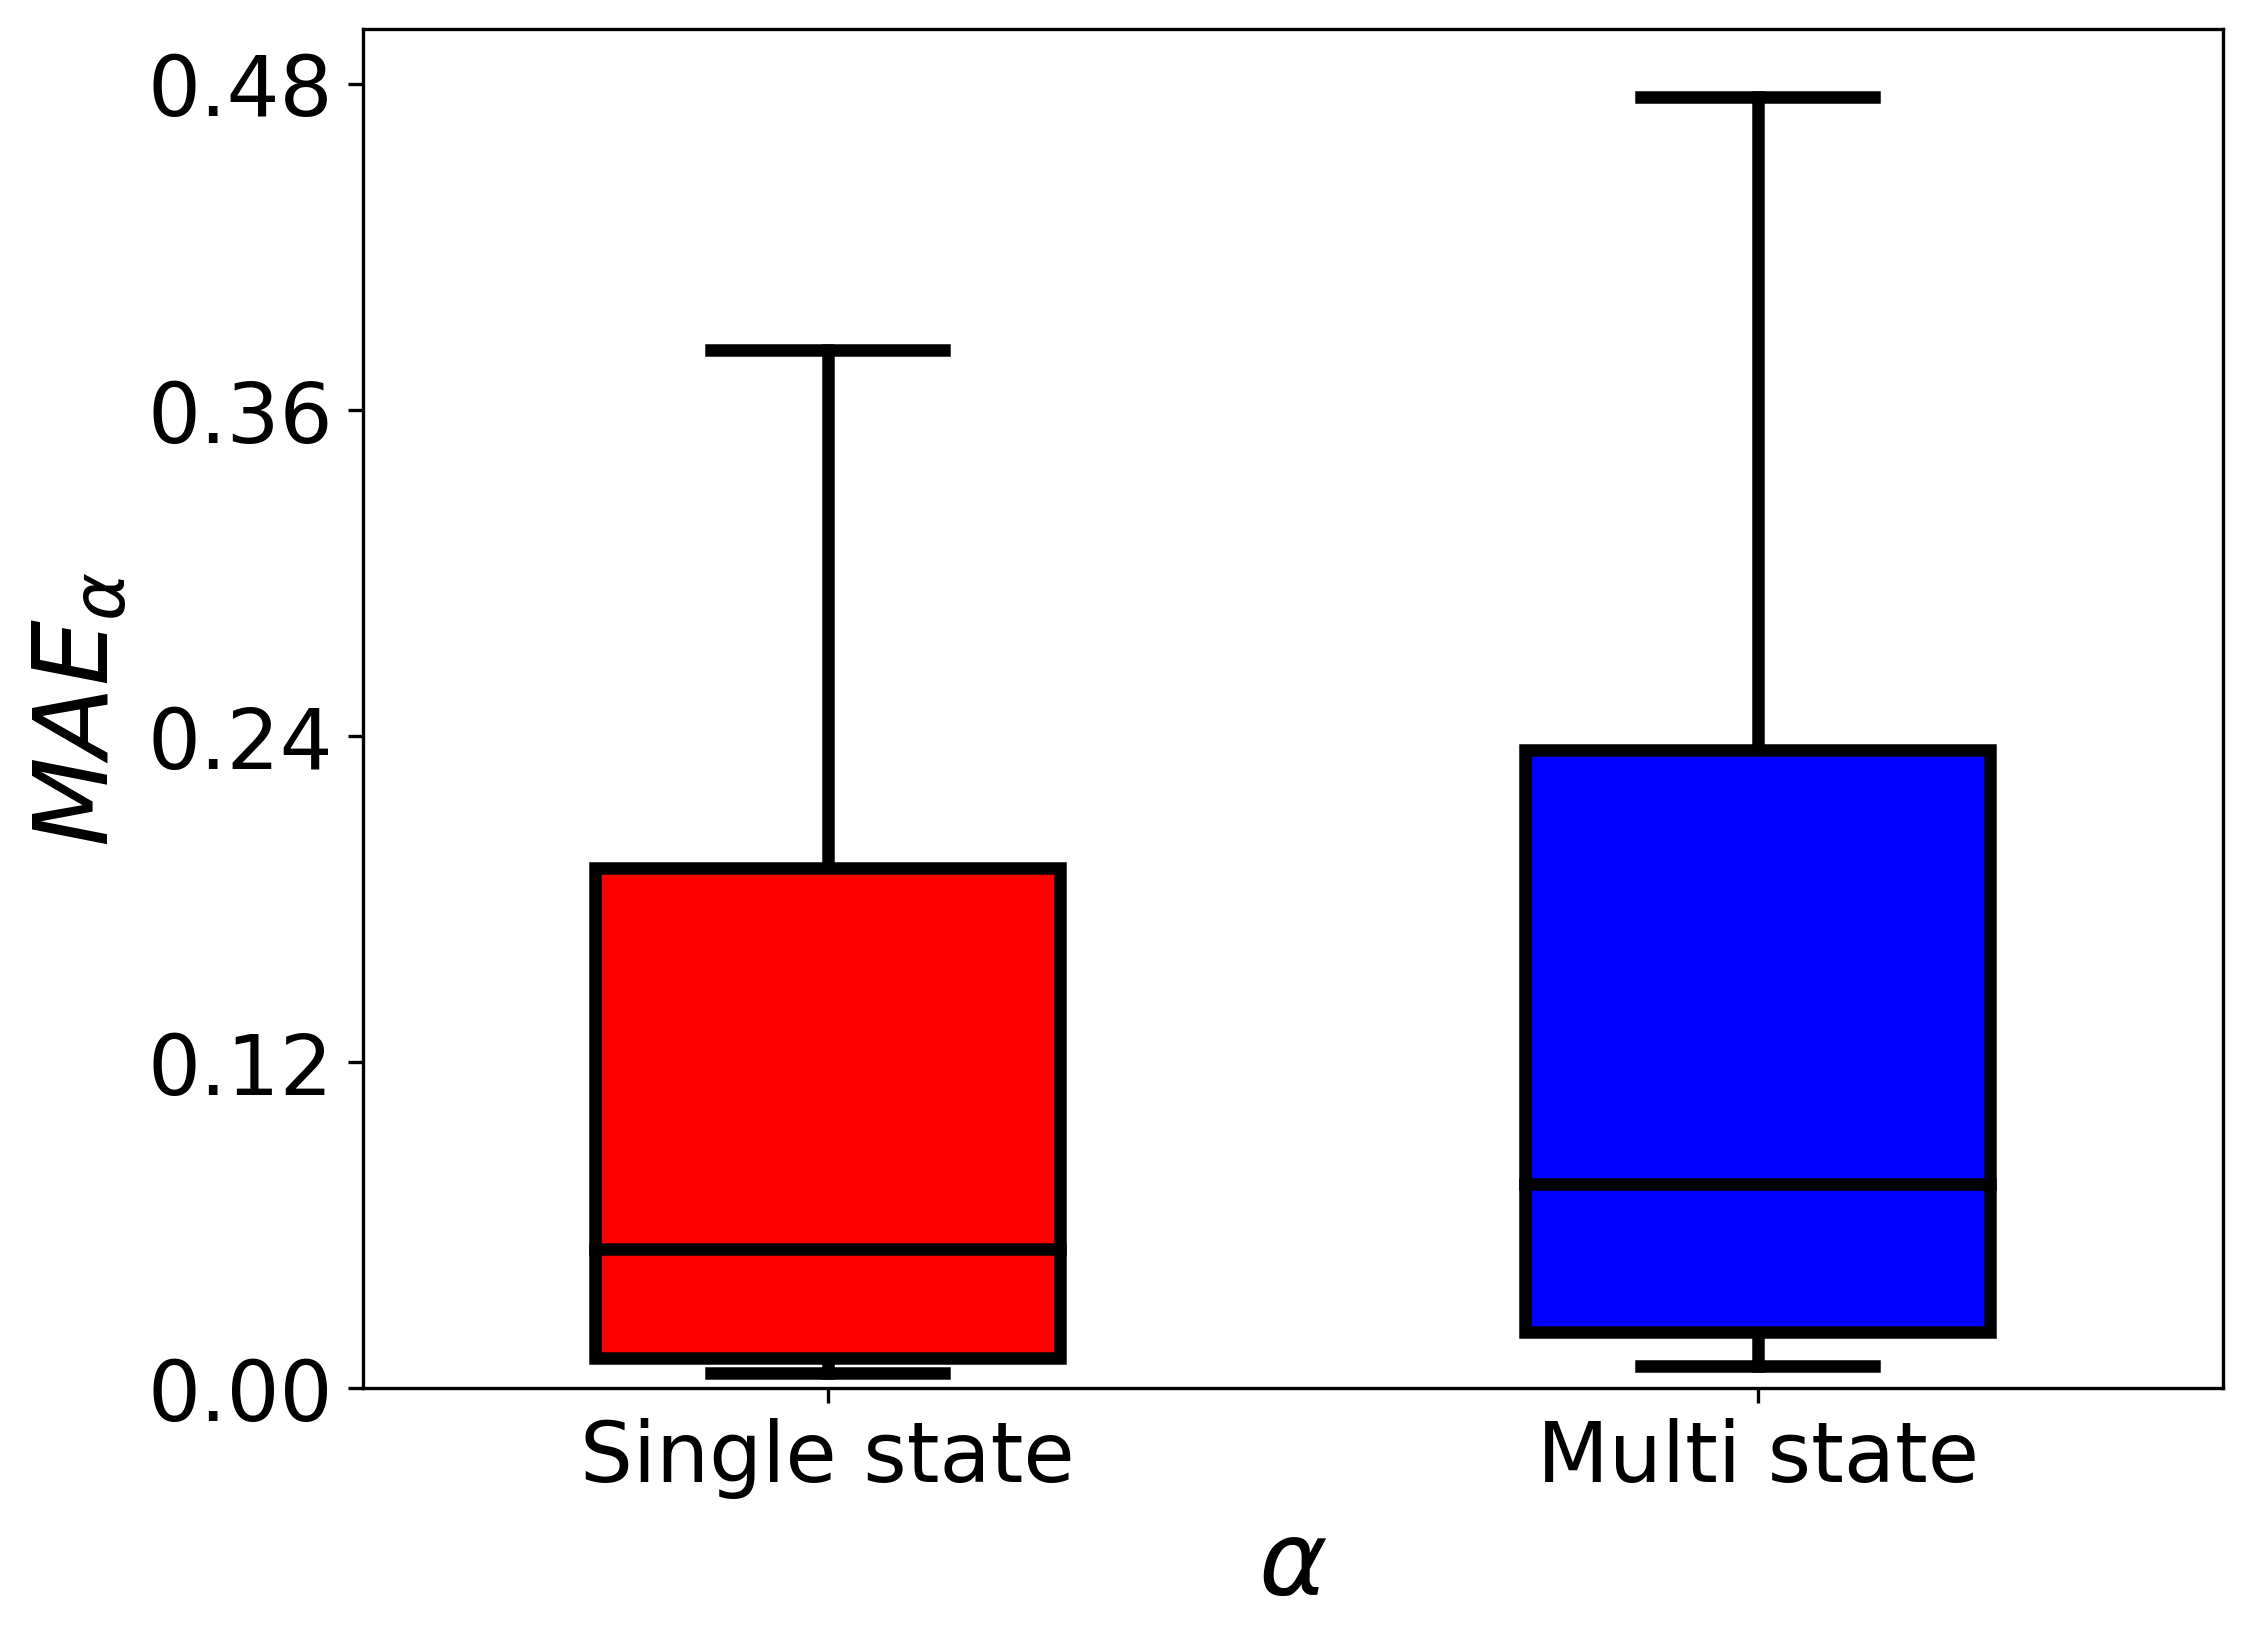

In [667]:
# loss_alpha

plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)


box = plt.boxplot(loss_alpha, widths=0.5, patch_artist=True,showfliers = False,
                 whis = [2.5,97.5],
                boxprops={'linewidth': 3},        
                 medianprops={'linewidth': 3,'color': 'black'},     
                 whiskerprops={'linewidth': 3},    
                 capprops={'linewidth': 3})



# 박스 위치 수정
for bn, b in enumerate(box['boxes']):
    q_low, q_high = np.percentile(loss_alpha[bn], [12.5, 87.5])
    q_lower, q_higher = np.percentile(loss_alpha[bn], [2.5, 97.5])
    median = np.median(loss_alpha[bn])
    mean = np.mean(loss_alpha[bn])
    
    
    path = box['boxes'][bn].get_path()
    vertices = path.vertices  # 박스의 꼭짓점 좌표 가져오기
    vertices[0] = [0.75+bn, q_low]  # 왼쪽 아래
    vertices[1] = [0.75+bn, q_high]  # 왼쪽 위
    vertices[2] = [1.25+bn, q_high]  # 오른쪽 위
    vertices[3] = [1.25+bn, q_low]  # 오른쪽 아래
    vertices[4] = vertices[0]  # 닫힘
    
#     print(vertices[5])
    box['boxes'][bn].set_path(path)
    


    print('2.5% = {}'.format(q_lower))
    print('12.5% = {}'.format(q_low))
    print('87.5% = {}'.format(q_high))
    print('97.5% = {}'.format(q_higher))
    print('median = {}'.format(median))
    print('mean = {}'.format(mean))
    print('//')

for bn in range(2):
    
    q_lower, q_higher = np.percentile(loss_alpha[bn], [2.5, 97.5])
    print(q_lower,q_higher)
    median = np.median(loss_alpha[bn])
    box['medians'][bn].set_ydata([median, median])

    


for bn, wn in enumerate(range(0,4,2)):
    q_low, q_high = np.percentile(loss_alpha[bn], [12.5, 87.5])
    q_lower, q_higher = np.percentile(loss_alpha[bn], [2.5, 97.5])
    
    box['whiskers'][wn].set_ydata([q_lower, q_low]) 
    box['whiskers'][wn+1].set_ydata([q_high, q_higher])
    box['caps'][wn].set_ydata([q_lower])
    box['caps'][wn+1].set_ydata([q_higher])
    
colors = ['red', 'blue']
for bp, color in zip(box['boxes'], colors):
    bp.set_facecolor(color)


    
plt.xticks([1,2], ['Single state', 'Multi state'], fontsize = 20)
plt.yticks([0.0,0.12,0.24,0.36,0.48],fontsize = 20)
plt.ylim([0,0.5])
#     plt.yticks(fontsize = 15)
plt.xlabel(r'$\alpha$', fontsize = 25)
plt.ylabel(r'$\mathit{MAE}_{\alpha}$', fontsize = 25)

2.5% = 0.013996699597726743
12.5% = 0.03150272081349822
87.5% = 0.7400028674717368
97.5% = 1.515493370831018
median = 0.16389668601501012
mean = 0.3276447171131288
//
2.5% = 0.027028486138089395
12.5% = 0.06393677153863384
87.5% = 0.6361217857404959
97.5% = 1.2289549635306745
median = 0.2084890580391202
mean = 0.3159648114555623
//
0.013996699597726743 1.515493370831018
0.027028486138089395 1.2289549635306745


Text(0, 0.5, '$\\mathit{MAE}_{k}$ $(\\mu m^2/s)$')

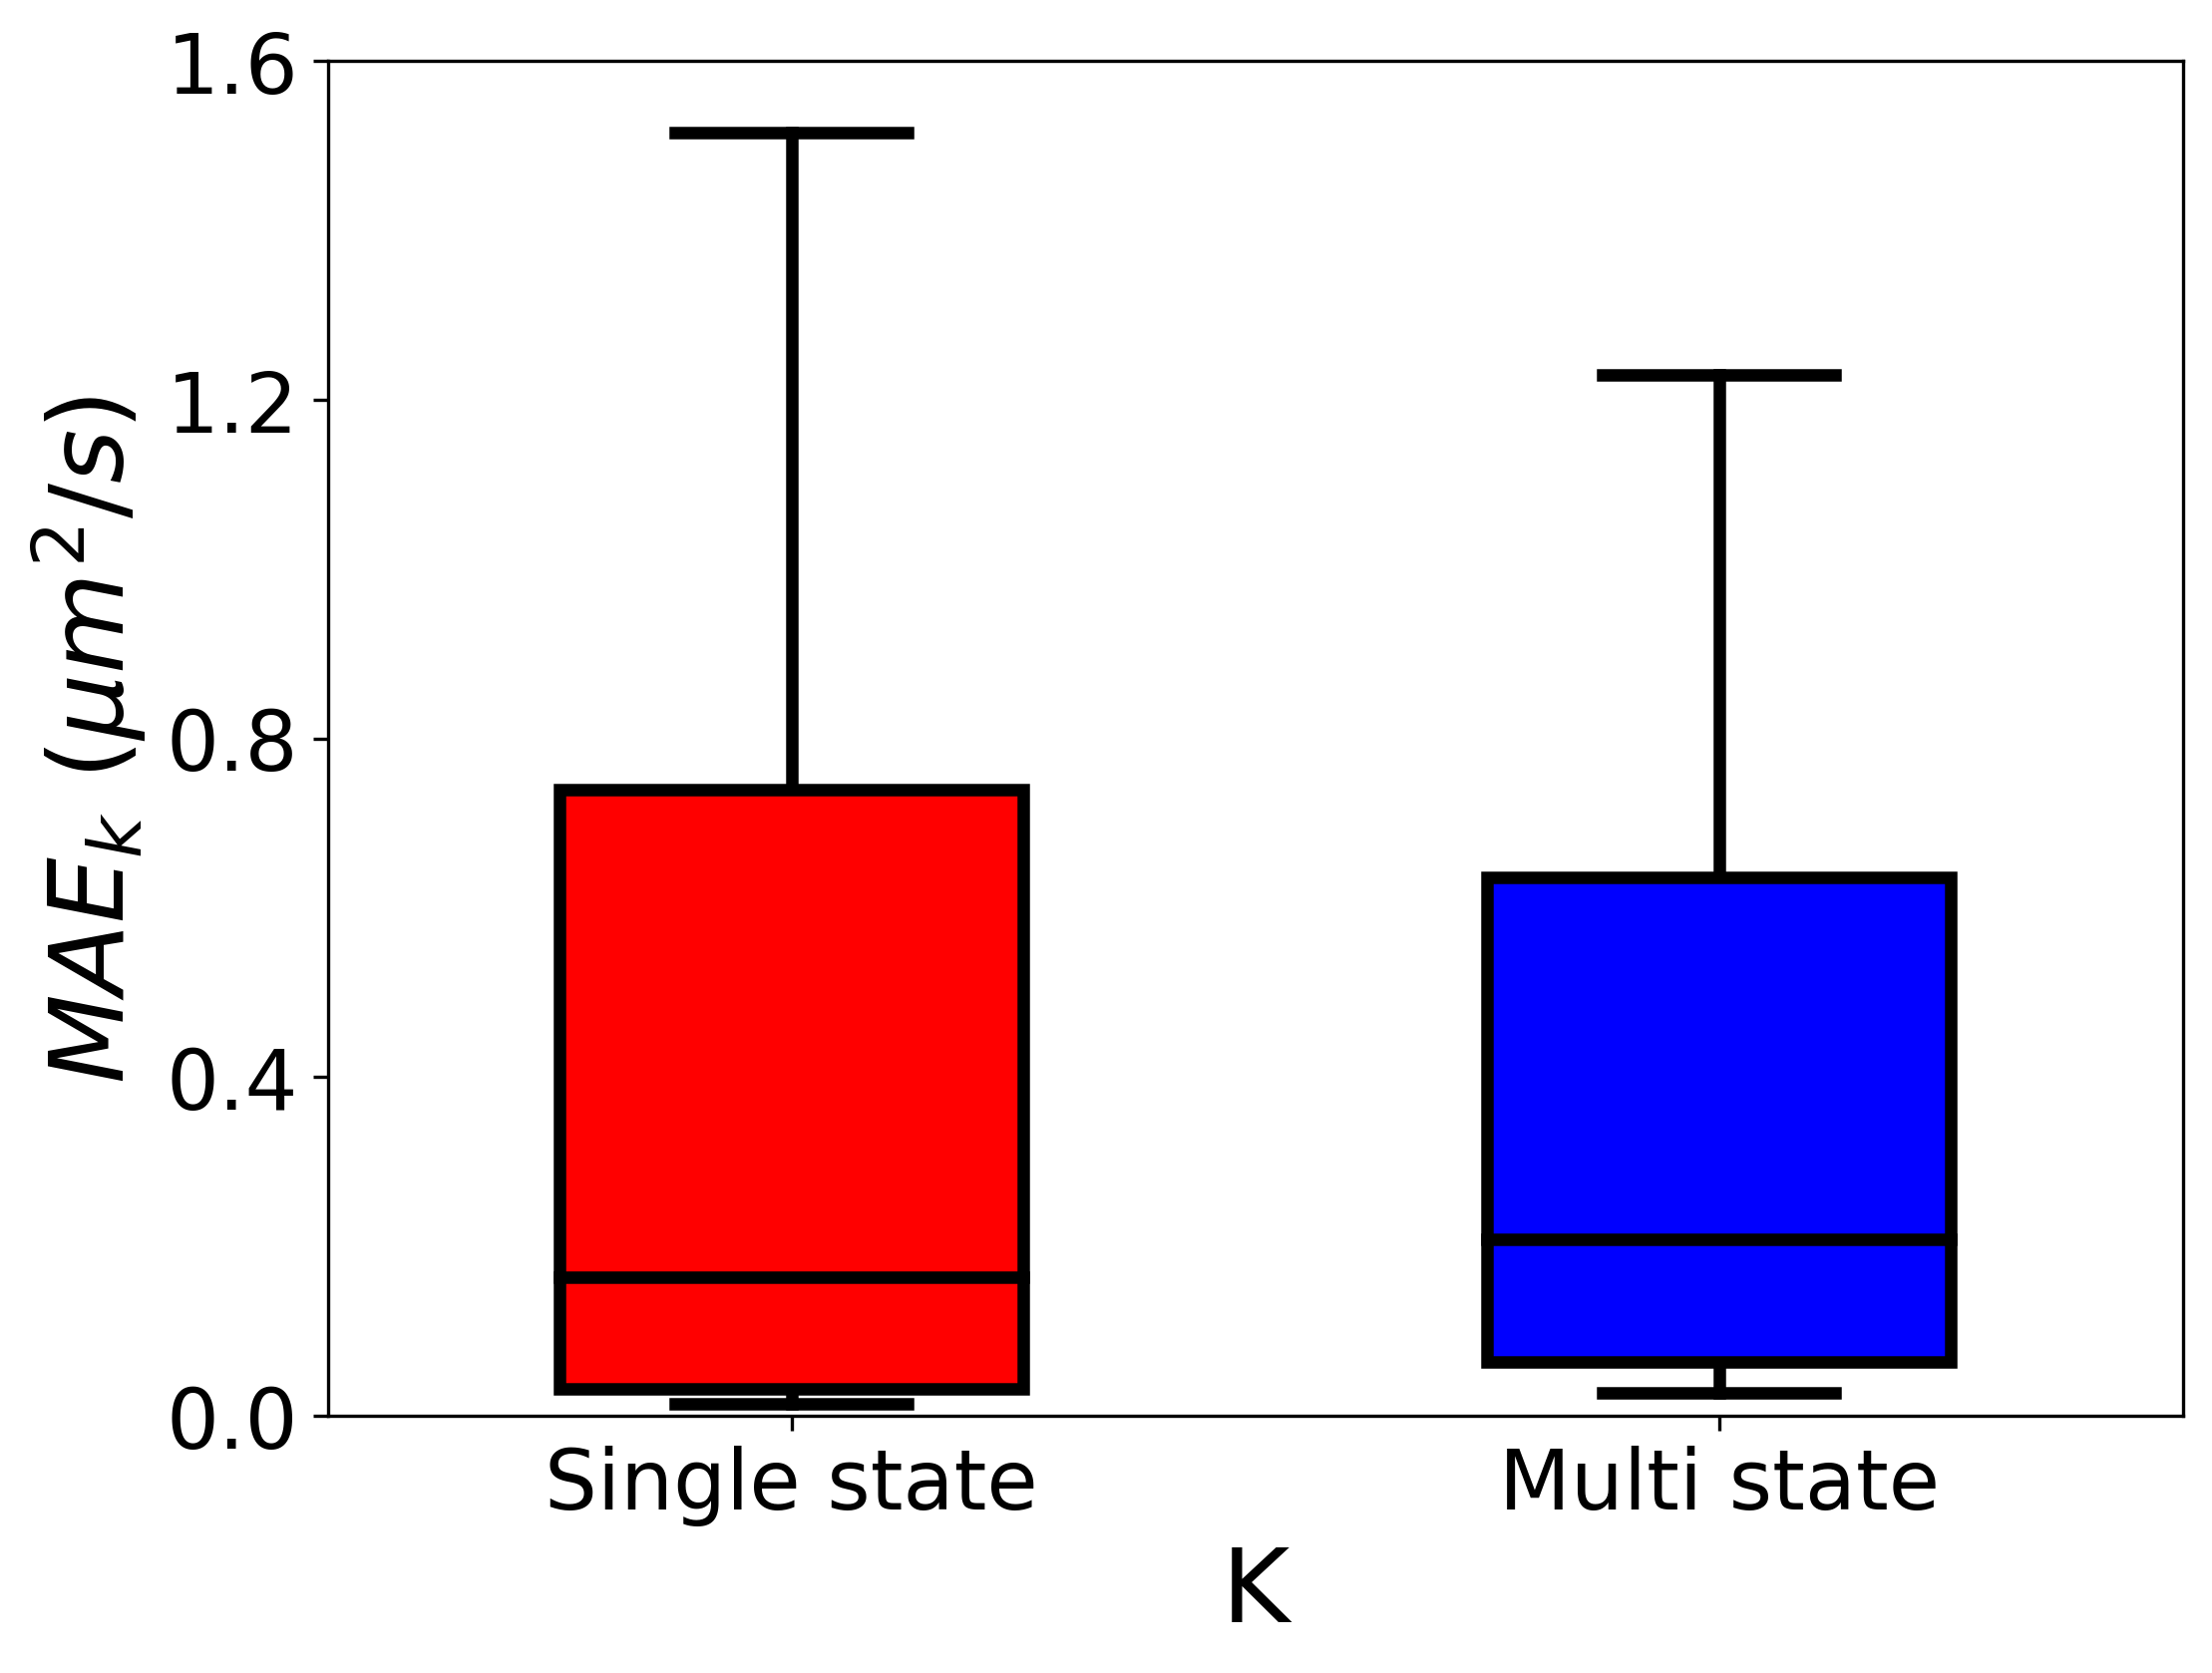

In [668]:
# loss_k

plt.figure(figsize=(8, 6), dpi=300, facecolor='white',edgecolor='black', frameon=True)


box = plt.boxplot(loss_k, widths=0.5, patch_artist=True,showfliers = False,
                 whis = [2.5,97.5],
                boxprops={'linewidth': 3},        
                 medianprops={'linewidth': 3,'color': 'black'},     
                 whiskerprops={'linewidth': 3},    
                 capprops={'linewidth': 3})



# 박스 위치 수정
for bn, b in enumerate(box['boxes']):
    q_low, q_high = np.percentile(loss_k[bn], [12.5, 87.5])
    q_lower, q_higher = np.percentile(loss_k[bn], [2.5, 97.5])
    median = np.median(loss_k[bn])
    mean = np.mean(loss_k[bn])
    
    
    path = box['boxes'][bn].get_path()
    vertices = path.vertices  # 박스의 꼭짓점 좌표 가져오기
    vertices[0] = [0.75+bn, q_low]  # 왼쪽 아래
    vertices[1] = [0.75+bn, q_high]  # 왼쪽 위
    vertices[2] = [1.25+bn, q_high]  # 오른쪽 위
    vertices[3] = [1.25+bn, q_low]  # 오른쪽 아래
    vertices[4] = vertices[0]  # 닫힘
    
#     print(vertices[5])
    box['boxes'][bn].set_path(path)
    


    print('2.5% = {}'.format(q_lower))
    print('12.5% = {}'.format(q_low))
    print('87.5% = {}'.format(q_high))
    print('97.5% = {}'.format(q_higher))
    print('median = {}'.format(median))
    print('mean = {}'.format(mean))
    print('//')

for bn in range(2):
    
    q_lower, q_higher = np.percentile(loss_k[bn], [2.5, 97.5])
    print(q_lower,q_higher)
    median = np.median(loss_k[bn])
    box['medians'][bn].set_ydata([median, median])

    


for bn, wn in enumerate(range(0,4,2)):
    q_low, q_high = np.percentile(loss_k[bn], [12.5, 87.5])
    q_lower, q_higher = np.percentile(loss_k[bn], [2.5, 97.5])
    
    box['whiskers'][wn].set_ydata([q_lower, q_low]) 
    box['whiskers'][wn+1].set_ydata([q_high, q_higher])
    box['caps'][wn].set_ydata([q_lower])
    box['caps'][wn+1].set_ydata([q_higher])
    
colors = ['red', 'blue']
for bp, color in zip(box['boxes'], colors):
    bp.set_facecolor(color)


    
plt.xticks([1,2], ['Single state', 'Multi state'], fontsize = 20)
plt.yticks([0.0,0.4,0.8,1.2,1.6],fontsize = 20)
plt.ylim([0,1.6])
#     plt.yticks(fontsize = 15)
plt.xlabel('K', fontsize = 25)
plt.ylabel(r'$\mathit{MAE}_{k}$'+ ' ' + r'$(\mu m^2/s)$', fontsize = 25)

In [669]:
np.min(mae_k['multi'][2])

0.09391844495594025

In [670]:
pred_data[case]['alpha'].shape

(48000, 200)

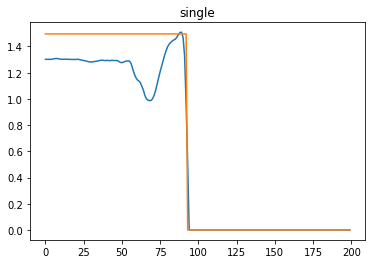

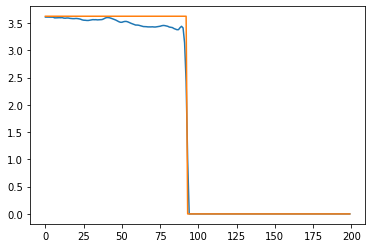

real_cp = [93]
alpha_based = [93]
k_based = [93]
both_based = [93]
alpha_based jsc = 1.0
k_based jsc = 1.0
both_based jsc = 1.0
alpha_based cp_loss = 0.0
k_based cp_loss = 0.0
both_based cp_loss = 0.0


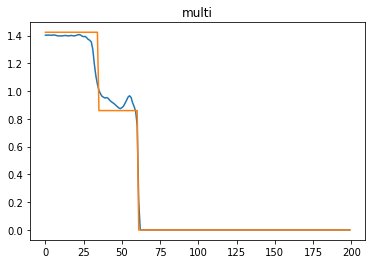

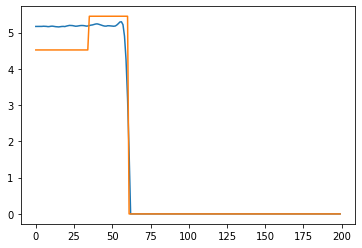

real_cp = [35, 61]
alpha_based = [32, 61]
k_based = [61]
both_based = [32, 61]
alpha_based jsc = 1.0
k_based jsc = 0.5
both_based jsc = 1.0
alpha_based cp_loss = 1.5
k_based cp_loss = 0.0
both_based cp_loss = 1.5


In [671]:
# example cpd_two side

dynamic_feature1 = 'alpha'
dynamic_feature2 = 'k'
n = 9000
T = 200
end_index = 3
for case in cases[:2]:


    Th_alpha = 0.06
    Th_k = 0.06

    pred_cp = []


    T_length = length_data[case][n]
    true_cp = cp_data[case][n]
    predicted_alpha = pred_data[case]['alpha'][n]
    predicted_k = pred_data[case]['k'][n]
    
    true_alpha = true_data[case]['alpha'][n]
    true_k = true_data[case]['k'][n]
    
    alpha_based_pred_cp = cpd_v1_alpha_one_side(predicted_alpha,predicted_k,T_length,Th_alpha,end_index)
    
    k_based_pred_cp = cpd_v1_k_one_side(predicted_alpha,predicted_k,T_length,Th_k,end_index)
    
    both_based_pred_cp = cpd_v1_two_side(predicted_alpha,predicted_k,T_length,Th_alpha,Th_k,end_index)
    
    jsc_alpha = jaccard_similarity_with_tolerance([alpha_based_pred_cp], [true_cp], 9)[0]
    jsc_k = jaccard_similarity_with_tolerance([k_based_pred_cp], [true_cp], 9)[0]
    jsc_both = jaccard_similarity_with_tolerance([both_based_pred_cp], [true_cp], 9)[0]
    
    jsc_alpha_loss = jaccard_similarity_with_tolerance([alpha_based_pred_cp], [true_cp], 9)[1]
    jsc_k_loss = jaccard_similarity_with_tolerance([k_based_pred_cp], [true_cp], 9)[1]
    jsc_both_loss = jaccard_similarity_with_tolerance([both_based_pred_cp], [true_cp], 9)[1]
    
    plt.title(case,fontsize = 12)
    plt.plot(predicted_alpha)
    plt.plot(true_alpha)
    plt.show()
    plt.plot(predicted_k)
    plt.plot(true_k)
    plt.show()
    
    print('real_cp = {}'.format(true_cp))
    print('alpha_based = {}'.format(alpha_based_pred_cp))
    print('k_based = {}'.format(k_based_pred_cp))
    print('both_based = {}'.format(both_based_pred_cp))
    
    print('alpha_based jsc = {}'.format(jsc_alpha))
    print('k_based jsc = {}'.format(jsc_k))
    print('both_based jsc = {}'.format(jsc_both))
    
    print('alpha_based cp_loss = {}'.format(jsc_alpha_loss))
    print('k_based cp_loss = {}'.format(jsc_k_loss))
    print('both_based cp_loss = {}'.format(jsc_both_loss))
    


In [672]:
ths_alpha = []
ths_k = []
for i in range(3,21):
    ths_alpha.append(i*0.01)
    
for i in range(3,21):
    ths_k.append(i*0.01)
    
print(ths_alpha,ths_k)

[0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2] [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]


In [673]:
cpd_v1_two_side(predicted_alpha,predicted_k,T_length,Th_alpha,Th_k,end_index)

[32, 61]

In [674]:
anomaly_case = []

JSC_length_range = {}


JSC_ths = {}
Loss_ths = {}

epsilon_cp = 9
for Th_alpha in ths_alpha:
    for Th_k in ths_k:
        Th_alpha = np.round(Th_alpha,2)
        Th_k = np.round(Th_k,2)
        print('Th_alpha = {}, Th_k = {} starting..'.format(Th_alpha,Th_k))
        predicted_cp = {}
        cp_loss = {}
        jsc = {}
        for case in cases[:2]:
            cp_loss[case] = []
            jsc[case] = []
            predicted_cp[case] = []
        for case in cases[:2]:

            print('{} starting..'.format(case))

            N = len(length_data[case])
            for n in range(N):
                T_length = length_data[case][n]
                true_cp = cp_data[case][n]
                predicted_alpha = pred_data[case]['alpha'][n]
                predicted_k = pred_data[case]['k'][n]

                true_alpha = true_data[case]['alpha'][n]
                true_k = true_data[case]['k'][n]

                pred_cp = cpd_v1_two_side(predicted_alpha,predicted_k,T_length,Th_alpha,Th_k,end_index)

                jsc[case].append(jaccard_similarity_with_tolerance([pred_cp], [true_cp], epsilon_cp)[0])  

                cp_loss[case].append(jaccard_similarity_with_tolerance([pred_cp], [true_cp], epsilon_cp)[1])
                
                predicted_cp[case].append(pred_cp)

        jsc_mean = {}
        cp_loss_mean = {}
        for case in cases[:2]:
            jsc_mean[case] = np.mean(jsc[case])
            cp_loss_mean[case] = np.mean(cp_loss[case])
                
        JSC_ths[(Th_alpha,Th_k)] = jsc_mean
        Loss_ths[(Th_alpha,Th_k)] = cp_loss_mean


        anomaly_score = 0
        anomaly_case = []
        for case in cases[:2]:
            N = len(length_data[case])
            for n in range(N):
                if len(predicted_cp[case][n]) > 2:
                    if np.min(np.diff(predicted_cp[case][n])) < 3:
                        anomaly_score +=1 
                        anomaly_case.append((case,n))

        if anomaly_score != 0:
            anomaly_case.append(1)

        else:
            print('Clear!')
            print(JSC_ths[(Th_alpha,Th_k)])
            print(Loss_ths[(Th_alpha,Th_k)])
            print('\n')
            


Th_alpha = 0.03, Th_k = 0.03 starting..
single starting..
multi starting..
Clear!
{'single': 0.8936391655395731, 'multi': 0.8111038862922076}
{'single': 0.6569027777777777, 'multi': 2.1481581127909184}


Th_alpha = 0.03, Th_k = 0.04 starting..
single starting..
multi starting..
Clear!
{'single': 0.9286642195767196, 'multi': 0.8329282842122141}
{'single': 0.47590277777777773, 'multi': 1.9475598860177321}


Th_alpha = 0.03, Th_k = 0.05 starting..
single starting..
multi starting..
Clear!
{'single': 0.9459621031746032, 'multi': 0.8421827926345709}
{'single': 0.36534722222222216, 'multi': 1.8011933501975648}


Th_alpha = 0.03, Th_k = 0.06 starting..
single starting..
multi starting..
Clear!
{'single': 0.9545386574074073, 'multi': 0.8455381342701256}
{'single': 0.2891111111111111, 'multi': 1.69157694744968}


Th_alpha = 0.03, Th_k = 0.07 starting..
single starting..
multi starting..
Clear!
{'single': 0.9599219576719578, 'multi': 0.8466927604103365}
{'single': 0.23552777777777775, 'multi': 1

In [680]:
jsc_sum = []
i = 0
for Th_alpha in ths_alpha:
    for Th_k in ths_k:
        jsc_sum.append(JSC_ths[(Th_alpha,Th_k)]['multi'] + JSC_ths[(Th_alpha,Th_k)]['single'])
        if i == 25:
            print([Th_alpha,Th_k])
        i += 1
print(np.argmax(jsc_sum))



[0.04, 0.1]
25
